In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2021-10-27 12:33:27.722651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
IS_KAGGLE = True

IS_SCALLER_ON = False

In [3]:
if IS_KAGGLE:
    #Kaggle
    train_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv")
    test_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv")
else:
    train_df = pd.read_csv("../data/ventilator-pressure-prediction/train.csv")
    test_df = pd.read_csv("../data/ventilator-pressure-prediction/test.csv")

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [6]:
train_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6036000.0,3.018000e+06,1.742443e+06,1.000000,1.509001e+06,3.018000e+06,4.527000e+06,6.036000e+06
breath_id,6036000.0,6.283886e+04,3.633526e+04,1.000000,3.137700e+04,6.276550e+04,9.430100e+04,1.257490e+05
R,6036000.0,2.703618e+01,1.959549e+01,5.000000,5.000000e+00,2.000000e+01,5.000000e+01,5.000000e+01
C,6036000.0,2.608072e+01,1.715231e+01,10.000000,1.000000e+01,2.000000e+01,5.000000e+01,5.000000e+01
time_step,6036000.0,1.307225e+00,7.659778e-01,0.000000,6.428995e-01,1.308123e+00,1.965502e+00,2.937238e+00
u_in,6036000.0,7.321615e+00,1.343470e+01,0.000000,3.936623e-01,4.386146e+00,4.983895e+00,1.000000e+02
u_out,6036000.0,6.204493e-01,4.852752e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
pressure,6036000.0,1.122041e+01,8.109703e+00,-1.895744,6.329607e+00,7.032628e+00,1.364103e+01,6.482099e+01


R distribution and C
Lung attribute indicating how restricted the airway is

C - lung attribute indicating how compliant the lung is (in mL/cmH2O).
Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.


                         Normal lungs	ARDS
    Compliance (ml/cmH2O)	50–60	35–45
    Resistance (cmH2O/(l/s))	10–15	10–15
    Expiratory time constant (s)	0.5–0.7	0.4–0.6



In [8]:
train_df.query("pressure<0")

,id,breath_id,R,C,time_step,u_in,u_out,pressure
28720,28721,542,50,10,0.000000,0.000000,0,-1.825442
28721,28722,542,50,10,0.033468,0.074189,0,-1.825442
28722,28723,542,50,10,0.066892,0.143197,0,-1.755140
28723,28724,542,50,10,0.100245,0.208192,0,-1.825442
28724,28725,542,50,10,0.133618,0.268278,0,-1.684838
...,...,...,...,...,...,...,...,...
5979915,5979916,124575,50,10,2.504311,0.057006,1,-0.700608
5979916,5979917,124575,50,10,2.537637,0.057709,1,-0.770910
5979917,5979918,124575,50,10,2.570976,0.058412,1,-0.841212
5979918,5979919,124575,50,10,2.604315,0.057709,1,-0.770910


<AxesSubplot:>

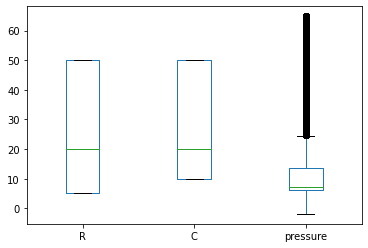

In [9]:
train_df[['R', 'C', 'pressure']].plot(kind='box')

In [10]:
train_df['log_pressure'] = np.log(train_df['pressure']+0.1)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

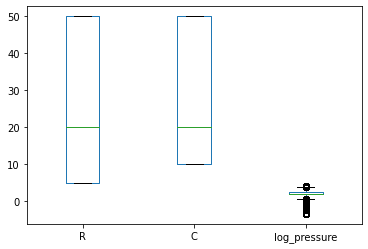

In [11]:
train_df[['R', 'C', 'log_pressure']].plot(kind='box')

In [12]:
# u_in goes from 0 to 100.
# u_out foes from 0 to 1.

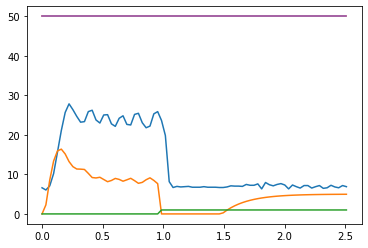

In [13]:
breath_sample = train_df.query("breath_id==10").sort_values(by='time_step')

selonid_in_valve = breath_sample.u_in

plt.plot(breath_sample.time_step, breath_sample.pressure)

plt.plot(breath_sample.time_step, breath_sample.u_in)

plt.plot(breath_sample.time_step, breath_sample.u_out)

plt.plot(breath_sample.time_step, breath_sample.R)

plt.plot(breath_sample.time_step, breath_sample.C)

<AxesSubplot:>

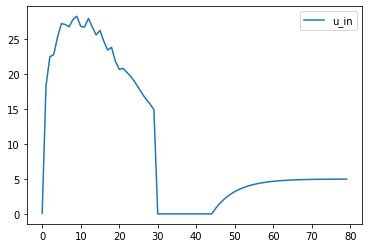

In [14]:
train_df.query("breath_id==1").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['u_in']].plot()

(array([[2.899e+03, 1.712e+03, 2.089e+03, ..., 3.100e+01, 8.000e+00,
         2.000e+00],
        [1.000e+00, 3.400e+01, 3.780e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 1.000e+00, 1.780e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 array([-1.89574429, -0.56140957,  0.77292515,  2.10725987,  3.44159459,
         4.77592931,  6.

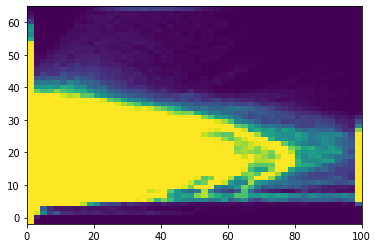

In [15]:
plt.hist2d(train_df['u_in'], train_df['pressure'], bins=(50, 50), vmax=400)

(array([[1141.,  718., 2406., ...,  264.,  202., 1066.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [1759., 1029., 1011., ...,    0.,    0.,    0.]]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 array([-1.89574429, -0.56140957,  0.77292515,  2.10725987,  3.44159459,
         4.77592931,  6.11026403,  7.44459875,  8.77893347, 10.11326819,
        11.44760291, 12.78193763, 14.11627235, 15.45060707, 16.78494179,
        18.11927652, 19.45361124, 20.78794596, 22.12228068, 23.4566154 ,
   

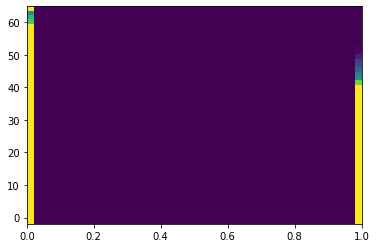

In [16]:
plt.hist2d(train_df['u_out'], train_df['pressure'], bins=(50, 50), vmax=400)

In [17]:
total_u_in = train_df.u_in.max() #per steps

In [18]:
#train

In [19]:
#log scale

train_df['log_u_in']=np.log(train_df['u_in']+0.001)

test_df['log_u_in']=np.log(test_df['u_in']+0.001)

train_df['log_R']=np.log(train_df['R']+0.001)

test_df['log_R']=np.log(test_df['R']+0.001)

train_df['log_C']=np.log(train_df['C']+0.001)

test_df['log_C']=np.log(test_df['C']+0.001)

In [20]:
u_in = train_df['u_in'].copy()

u_in_test = test_df['u_in'].copy()

In [21]:
#over 3 time steps

sin_u_in = u_in*np.sin(2*np.pi*(u_in/3))

cos_u_in = u_in*np.cos(2*np.pi*(u_in/3))

train_df['sin_u_in'] = sin_u_in

train_df['cos_u_in'] = cos_u_in

In [22]:
#test

In [23]:
sin_u_in_test = u_in_test*np.sin(2*np.pi*(u_in_test/3))

cos_u_in_test = u_in_test*np.cos(2*np.pi*(u_in_test/3))

test_df['sin_u_in'] = sin_u_in_test

test_df['cos_u_in'] = cos_u_in_test

In [24]:
#time_step

time_step = train_df['time_step'].copy()

sin_time_step = np.sin(2*np.pi*(time_step/3))

cos_time_step = np.cos(2*np.pi*(time_step/3))

train_df['sin_time_step'] = sin_time_step

train_df['cos_time_step'] = cos_time_step

<AxesSubplot:>

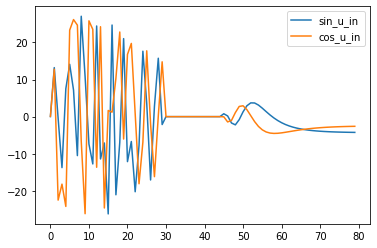

In [25]:
train_df.query("breath_id==1").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['sin_u_in', 'cos_u_in']].plot()

<AxesSubplot:>

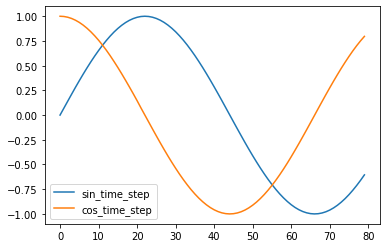

In [26]:
train_df.query("breath_id==1").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['sin_time_step', 'cos_time_step']].plot()

<AxesSubplot:>

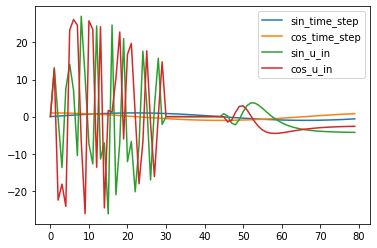

In [27]:
train_df.query("breath_id==1").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['sin_time_step', 'cos_time_step', 'sin_u_in', 'cos_u_in']].plot()

In [28]:
#time_step

time_step = test_df['time_step'].copy()

sin_time_step = np.sin(2*np.pi*(time_step/3))

cos_time_step = np.cos(2*np.pi*(time_step/3))

test_df['sin_time_step'] = sin_time_step

test_df['cos_time_step'] = cos_time_step

In [29]:
test_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,log_u_in,log_R,log_C,sin_u_in,cos_u_in,sin_time_step,cos_time_step
0,1,0,5,20,0.000000,0.000000,0,-6.907755,1.609638,2.995782,0.000000,0.000000,0.000000,1.000000
1,2,0,5,20,0.031904,7.515046,0,2.017040,1.609638,2.995782,-0.236770,-7.511315,0.066769,0.997768
2,3,0,5,20,0.063827,14.651675,0,2.684623,1.609638,2.995782,-9.765618,10.922651,0.133282,0.991078
3,4,0,5,20,0.095751,21.230610,0,3.055491,1.609638,2.995782,9.860087,18.802061,0.199199,0.979959
4,5,0,5,20,0.127644,26.320956,0,3.270403,1.609638,2.995782,-26.030842,3.897177,0.264163,0.964478


<AxesSubplot:>

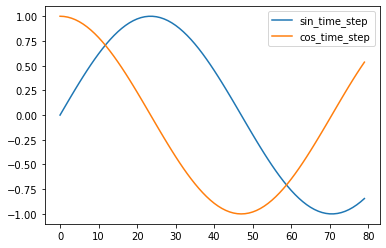

In [30]:
test_df.query("breath_id==0").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['sin_time_step', 'cos_time_step']].plot()

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             int64  
 1   breath_id      int64  
 2   R              int64  
 3   C              int64  
 4   time_step      float64
 5   u_in           float64
 6   u_out          int64  
 7   log_u_in       float64
 8   log_R          float64
 9   log_C          float64
 10  sin_u_in       float64
 11  cos_u_in       float64
 12  sin_time_step  float64
 13  cos_time_step  float64
dtypes: float64(9), int64(5)
memory usage: 429.8 MB


In [32]:
#log scale

train_df['log_u_in']=np.log(train_df['u_in']+0.001)

test_df['log_u_in']=np.log(test_df['u_in']+0.001)

train_df['log_R']=np.log(train_df['R']+0.001)

test_df['log_R']=np.log(test_df['R']+0.001)

train_df['log_C']=np.log(train_df['C']+0.001)

test_df['log_C']=np.log(test_df['C']+0.001)

In [33]:
target = ['pressure']
features = ['log_R', 'log_C', 'sin_u_in', 'cos_u_in', 'u_out', 'sin_time_step', 'cos_time_step']
# features = ['R', 'C', 'u_in', 'u_out', 'sin_time_step', 'cos_time_step']
# features = ['log_R', 'log_C', 'log_u_in', 'u_out', 'sin_time_step', 'cos_time_step', 'u_out']

<AxesSubplot:>

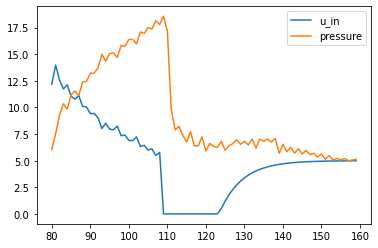

In [34]:
train_df.query("breath_id==2").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['u_in', 'pressure']].plot()

<AxesSubplot:>

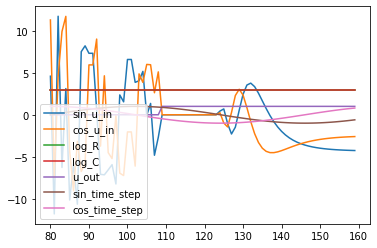

In [35]:
train_df.query("breath_id==2").sort_values(['breath_id', 'time_step'],
                                           ascending=True)[['sin_u_in', 'cos_u_in', 'log_R', 'log_C', 'u_out', 'sin_time_step', 'cos_time_step']].plot()


In [36]:
train_df.groupby(by=['breath_id']).size()[train_df.groupby(by=['breath_id']).size()>80]

Series([], dtype: int64)

In [37]:
test_df.groupby(by=['breath_id']).size()[test_df.groupby(by=['breath_id']).size()<80]

Series([], dtype: int64)

Each secuence has 80 points or timesteps

Dataset has 1 row per timestep 

the first 80 rows belong to the first series. My window lenght is 80 and the stride is 80 with 4 features.

In [38]:
test_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,log_u_in,log_R,log_C,sin_u_in,cos_u_in,sin_time_step,cos_time_step
0,1,0,5,20,0.000000,0.000000,0,-6.907755,1.609638,2.995782,0.000000,0.000000,0.000000,1.000000
1,2,0,5,20,0.031904,7.515046,0,2.017040,1.609638,2.995782,-0.236770,-7.511315,0.066769,0.997768
2,3,0,5,20,0.063827,14.651675,0,2.684623,1.609638,2.995782,-9.765618,10.922651,0.133282,0.991078
3,4,0,5,20,0.095751,21.230610,0,3.055491,1.609638,2.995782,9.860087,18.802061,0.199199,0.979959
4,5,0,5,20,0.127644,26.320956,0,3.270403,1.609638,2.995782,-26.030842,3.897177,0.264163,0.964478


In [39]:
# First thing should be to order the dataset by breath_id and time_step

train_ordered_features_df = train_df.sort_values(['id', 'breath_id', 'time_step'], ascending=True)[features].copy()

test_ordered_features_df = test_df.sort_values(['id', 'breath_id', 'time_step'], ascending=True)[features].copy()

In [40]:
train_ordered_features_df.head(10)

,log_R,log_C,sin_u_in,cos_u_in,u_out,sin_time_step,cos_time_step
0,2.995782,3.912043,0.014471,0.082068,0,0.000000,1.000000
1,2.995782,3.912043,13.215845,12.778014,0,0.070423,0.997517
2,2.995782,3.912043,-0.437357,-22.505028,0,0.140931,0.990019
3,2.995782,3.912043,-13.745338,-18.201870,0,0.211070,0.977471
4,2.995782,3.912043,7.539333,-24.209040,0,0.280510,0.959851
5,2.995782,3.912043,14.114795,23.321081,0,0.347979,0.937502
6,2.995782,3.912043,7.157426,26.166233,0,0.413819,0.910359
7,2.995782,3.912043,-10.505698,24.663430,0,0.477568,0.878595
8,2.995782,3.912043,27.064337,-6.630536,0,0.538964,0.842329
9,2.995782,3.912043,10.805570,-26.169976,0,0.597455,0.801903


In [41]:
# Those 2 should be the same

In [42]:
train_ordered_target_df = train_df.sort_values(['id', 'breath_id', 'time_step'], ascending=True)[target].copy()

In [43]:
train_ordered_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6036000 entries, 0 to 6035999
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   log_R          float64
 1   log_C          float64
 2   sin_u_in       float64
 3   cos_u_in       float64
 4   u_out          int64  
 5   sin_time_step  float64
 6   cos_time_step  float64
dtypes: float64(6), int64(1)
memory usage: 368.4 MB


In [44]:
from sklearn import preprocessing

if IS_SCALLER_ON:
    scaler = preprocessing.StandardScaler().fit(train_ordered_features_df)

    train_ordered_features = scaler.transform(train_ordered_features_df)

    test_ordered_features = scaler.transform(test_ordered_features_df)
else:
    train_ordered_features = train_ordered_features_df.to_numpy()

    test_ordered_features = test_ordered_features_df.to_numpy()

In [45]:
#Split between train and test
from sklearn.model_selection import train_test_split

X_train= train_ordered_features
y_train= train_ordered_target_df.to_numpy()

In [46]:
feature_lenght = len(features)

In [47]:
def build_windows(X):
    size=80
    shift=80
    stride=1
    drop_remainder=True
    
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(size, shift, stride, drop_remainder)
    dataset = dataset.flat_map(lambda window: window.batch(size))
    dataset = dataset.map(lambda window: (window[:, :feature_lenght], window[:, feature_lenght:]))
    dataset = dataset.batch(2048).shuffle(4196).prefetch(128)

    return dataset

def build_windows_predict(X):
    size=80
    shift=80
    stride=1
    drop_remainder=True

    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(size, shift, stride, drop_remainder)
    dataset = dataset.flat_map(lambda window: window.batch(size))
    dataset = dataset.batch(256).prefetch(32)

    return dataset

In [48]:
test_dataset = build_windows_predict(test_ordered_features)

dataset_train = build_windows(np.concatenate([X_train, y_train], axis=1))

2021-10-27 12:34:16.726273: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-27 12:34:16.729461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-27 12:34:16.772207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 12:34:16.772883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-27 12:34:16.772956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-27 12:34:16.796789: I tensorflow/stream_executor/platform/def

In [49]:
layer = tf.keras.layers.Dropout(0.4)
layer(tf.constant(np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])), training=True)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.6666666, 1.6666666, 1.6666666, 0.       , 1.6666666, 0.       ,
       0.       , 0.       , 0.       , 1.6666666], dtype=float32)>

In [50]:
#Base LSTM model
X_input = tf.keras.layers.Input(shape=(80, feature_lenght))

X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True))(X_input)
X = tf.keras.layers.Conv1D(32, 2, 1, padding='valid', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(X)
X = tf.keras.layers.Conv1D(64, 3, 1, padding='valid', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True))(X)
X = tf.keras.layers.Conv1D(128, 5, 1, padding='valid', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=True))(X)

X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(512, activation='swish')(X)
X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(512, activation='swish')(X)
X = tf.keras.layers.Dropout(0.5)(X)

X_output = tf.keras.layers.Dense(80, activation='swish')(X)

lstm_model = tf.keras.Model(inputs=X_input, outputs=X_output)

In [51]:
# #Base LSTM model
# X_input = tf.keras.layers.Input(shape=(80, feature_lenght))

# X = tf.keras.layers.Conv1D(64, 2, 1, padding='valid', activation='relu')(X_input)
# X = tf.keras.layers.Conv1D(32, 2, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.MaxPool1D(2)(X)
# X = tf.keras.layers.Conv1D(128, 3, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.Conv1D(64, 3, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.Conv1D(64, 3, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.MaxPool1D(2)(X)
# X = tf.keras.layers.Conv1D(256, 5, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.Conv1D(256, 5, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.Conv1D(128, 5, 1, padding='valid', activation='relu')(X)
# X = tf.keras.layers.MaxPool1D(2)(X)

# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=True))(X)

# X = tf.keras.layers.Flatten()(X)
# X = tf.keras.layers.Dense(512, activation='swish')(X)
# X = tf.keras.layers.Dropout(0.4)(X)
# X = tf.keras.layers.Dense(512, activation='swish')(X)
# X = tf.keras.layers.Dropout(0.4)(X)

# X_output = tf.keras.layers.Dense(80, activation='swish')(X)

# lstm_model = tf.keras.Model(inputs=X_input, outputs=X_output)

In [52]:
# #Base LSTM model
# X_input = tf.keras.layers.Input(shape=(80, feature_lenght))

# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(80))(X_input)
# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40))(X)
# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40))(X)
# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True))(X_input)
# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True))(X)
# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True))(X)
# # X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10))(X)

# # X = tf.keras.layers.Flatten()(X)

# # X = tf.keras.layers.Dropout(0.50)(X)
# X = tf.keras.layers.Dense(32, activation='swish')(X)
# # X = tf.keras.layers.Dropout(0.50)(X)

# X_output = tf.keras.layers.Dense(80, activation='swish')(X)

# lstm_model = tf.keras.Model(inputs=X_input, outputs=X_output)

In [53]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer="Adam",
            metrics=[tf.keras.metrics.MeanSquaredError()])

In [54]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 7)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 80)            15360     
_________________________________________________________________
conv1d (Conv1D)              (None, 79, 32)            5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 39, 40)            8480      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 64)            7744      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 64)            0     

In [55]:
# lstm_model.fit(dataset_train, epochs=1000)
if IS_KAGGLE:
    print("Kaggle")
    lstm_model.fit(dataset_train, epochs=1000)
else:
    print("CPU")
    with tf.device('/CPU:0'):
        lstm_model.fit(dataset_train, epochs=500)

Kaggle
Epoch 1/1000


2021-10-27 12:34:30.450999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-27 12:34:30.501692: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000144999 Hz
2021-10-27 12:34:31.545272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-27 12:34:32.453272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-27 12:34:41.688658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 12:34:51.875498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196
2021-10-27 12:34:56.944590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2021-10-27 12:34:56.985017: I ten

37/37 [==============================] - 43s 68ms/step - loss: 139.2538 - mean_squared_error: 139.2538
Epoch 2/1000


2021-10-27 12:35:16.110638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:35:26.037369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 37.7935 - mean_squared_error: 37.7935

2021-10-27 12:35:30.475310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 35.1049 - mean_squared_error: 35.1049
Epoch 3/1000


2021-10-27 12:35:43.115747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:35:53.582949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 28.7972 - mean_squared_error: 28.7972

2021-10-27 12:35:58.207777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 24.0629 - mean_squared_error: 24.0629
Epoch 4/1000


2021-10-27 12:36:11.072206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:36:21.154582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 15.3866 - mean_squared_error: 15.3866

2021-10-27 12:36:26.686190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 14.7064 - mean_squared_error: 14.7064
Epoch 5/1000


2021-10-27 12:36:39.619996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:36:49.609042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 12.7195 - mean_squared_error: 12.7195

2021-10-27 12:36:53.859603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 12.3947 - mean_squared_error: 12.3947
Epoch 6/1000


2021-10-27 12:37:06.912035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:37:16.760501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 11.3513 - mean_squared_error: 11.3513

2021-10-27 12:37:20.534052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 64ms/step - loss: 11.1105 - mean_squared_error: 11.1105
Epoch 7/1000


2021-10-27 12:37:33.446630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:37:43.824343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 10.4526 - mean_squared_error: 10.4526

2021-10-27 12:37:47.615365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 10.5520 - mean_squared_error: 10.5520
Epoch 8/1000


2021-10-27 12:38:00.660271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:38:10.197426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 10.1254 - mean_squared_error: 10.1254

2021-10-27 12:38:14.557898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 10.1816 - mean_squared_error: 10.1816
Epoch 9/1000


2021-10-27 12:38:27.574887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:38:37.312372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 9.7396 - mean_squared_error: 9.7396

2021-10-27 12:38:41.813078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 9.9199 - mean_squared_error: 9.9199
Epoch 10/1000


2021-10-27 12:38:54.483006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:39:04.437026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 9.6139 - mean_squared_error: 9.6139

2021-10-27 12:39:08.778638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 9.5423 - mean_squared_error: 9.5423
Epoch 11/1000


2021-10-27 12:39:21.835908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:39:31.742702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 9.6612 - mean_squared_error: 9.6612

2021-10-27 12:39:36.468968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 9.4389 - mean_squared_error: 9.4389
Epoch 12/1000


2021-10-27 12:39:49.162636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:39:59.108591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 9.1113 - mean_squared_error: 9.1113

2021-10-27 12:40:03.487348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 9.2099 - mean_squared_error: 9.2099
Epoch 13/1000


2021-10-27 12:40:16.492552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:40:26.643849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 9.1099 - mean_squared_error: 9.1099

2021-10-27 12:40:31.356468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 9.1170 - mean_squared_error: 9.1170
Epoch 14/1000


2021-10-27 12:40:44.522338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:40:54.353456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 9.1729 - mean_squared_error: 9.1729

2021-10-27 12:40:58.833024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 8.8743 - mean_squared_error: 8.8743
Epoch 15/1000


2021-10-27 12:41:12.075728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:41:21.978225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 8.4046 - mean_squared_error: 8.4046

2021-10-27 12:41:27.206205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 8.5409 - mean_squared_error: 8.5409
Epoch 16/1000


2021-10-27 12:41:39.790830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:41:49.849424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 8.4630 - mean_squared_error: 8.4630

2021-10-27 12:41:54.401450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 8.1789 - mean_squared_error: 8.1789
Epoch 17/1000


2021-10-27 12:42:08.031943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:42:17.609519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 7.5389 - mean_squared_error: 7.5389

2021-10-27 12:42:21.668623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 7.3553 - mean_squared_error: 7.3553
Epoch 18/1000


2021-10-27 12:42:34.496560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:42:44.358103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.9168 - mean_squared_error: 6.9168

2021-10-27 12:42:48.793881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 6.9250 - mean_squared_error: 6.9250
Epoch 19/1000


2021-10-27 12:43:02.014100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:43:11.581101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.4583 - mean_squared_error: 6.4583

2021-10-27 12:43:16.921821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 6.6691 - mean_squared_error: 6.6691
Epoch 20/1000


2021-10-27 12:43:29.671129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:43:39.948420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.5561 - mean_squared_error: 6.5561

2021-10-27 12:43:45.312786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 6.4513 - mean_squared_error: 6.4513
Epoch 21/1000


2021-10-27 12:43:58.387592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:44:08.584816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.2360 - mean_squared_error: 6.2360

2021-10-27 12:44:12.448679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 6.2622 - mean_squared_error: 6.2622
Epoch 22/1000


2021-10-27 12:44:25.316082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:44:35.068813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 6.5002 - mean_squared_error: 6.5002   

2021-10-27 12:44:38.769161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 64ms/step - loss: 6.3362 - mean_squared_error: 6.3362
Epoch 23/1000


2021-10-27 12:44:51.845990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:45:01.927631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.1458 - mean_squared_error: 6.1458

2021-10-27 12:45:06.041031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 6.0680 - mean_squared_error: 6.0680
Epoch 24/1000


2021-10-27 12:45:18.817964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:45:28.876273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.2124 - mean_squared_error: 6.2124

2021-10-27 12:45:33.612254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 6.0289 - mean_squared_error: 6.0289
Epoch 25/1000


2021-10-27 12:45:46.693152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:45:56.526023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.2031 - mean_squared_error: 6.2031

2021-10-27 12:46:01.153122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 6.0572 - mean_squared_error: 6.0572
Epoch 26/1000


2021-10-27 12:46:14.259299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:46:23.815750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.7808 - mean_squared_error: 5.7808

2021-10-27 12:46:28.311438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 5.7741 - mean_squared_error: 5.7741
Epoch 27/1000


2021-10-27 12:46:40.970891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:46:51.010663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.7453 - mean_squared_error: 5.7453

2021-10-27 12:46:56.246702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 5.7044 - mean_squared_error: 5.7044
Epoch 28/1000


2021-10-27 12:47:09.193985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:47:19.090709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.7593 - mean_squared_error: 5.7593

2021-10-27 12:47:23.539172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 5.6849 - mean_squared_error: 5.6849
Epoch 29/1000


2021-10-27 12:47:36.724894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:47:46.593419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.3278 - mean_squared_error: 5.3278

2021-10-27 12:47:50.725970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 5.4939 - mean_squared_error: 5.4939
Epoch 30/1000


2021-10-27 12:48:03.846352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:48:13.824264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.3690 - mean_squared_error: 5.3690

2021-10-27 12:48:17.551779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 5.3299 - mean_squared_error: 5.3299
Epoch 31/1000


2021-10-27 12:48:30.603494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:48:40.324588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.2202 - mean_squared_error: 5.2202

2021-10-27 12:48:45.782623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 5.2068 - mean_squared_error: 5.2068
Epoch 32/1000


2021-10-27 12:48:58.691706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:49:08.622107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 5.2306 - mean_squared_error: 5.2306

2021-10-27 12:49:13.306793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 5.1949 - mean_squared_error: 5.1949
Epoch 33/1000


2021-10-27 12:49:26.096861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:49:36.175510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.8131 - mean_squared_error: 4.8131

2021-10-27 12:49:41.546291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 5.0526 - mean_squared_error: 5.0526
Epoch 34/1000


2021-10-27 12:49:54.180938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:50:04.767283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.8762 - mean_squared_error: 4.8762

2021-10-27 12:50:09.290072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 4.8828 - mean_squared_error: 4.8828
Epoch 35/1000


2021-10-27 12:50:21.980048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:50:32.419244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.9365 - mean_squared_error: 4.9365

2021-10-27 12:50:37.655116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 4.8267 - mean_squared_error: 4.8267
Epoch 36/1000


2021-10-27 12:50:50.609212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 12:51:00.687265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.8798 - mean_squared_error: 4.8798

2021-10-27 12:51:07.446769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 4.7230 - mean_squared_error: 4.7230
Epoch 37/1000


2021-10-27 12:51:20.012987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:51:30.048338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.6174 - mean_squared_error: 4.6174

2021-10-27 12:51:34.629956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 4.5072 - mean_squared_error: 4.5072
Epoch 38/1000


2021-10-27 12:51:47.877461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:51:57.357347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.5616 - mean_squared_error: 4.5616

2021-10-27 12:52:02.737260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 4.4091 - mean_squared_error: 4.4091
Epoch 39/1000


2021-10-27 12:52:15.955260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:52:25.332819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.3131 - mean_squared_error: 4.3131

2021-10-27 12:52:30.338788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 4.2763 - mean_squared_error: 4.2763
Epoch 40/1000


2021-10-27 12:52:43.348552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:52:53.439291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.2531 - mean_squared_error: 4.2531

2021-10-27 12:52:58.019181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 4.1888 - mean_squared_error: 4.1888
Epoch 41/1000


2021-10-27 12:53:11.066394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:53:20.933386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 4.0683 - mean_squared_error: 4.0683

2021-10-27 12:53:25.600879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 4.0898 - mean_squared_error: 4.0898
Epoch 42/1000


2021-10-27 12:53:38.700897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:53:48.484503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.9952 - mean_squared_error: 3.9952

2021-10-27 12:53:52.402904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 4.0900 - mean_squared_error: 4.0900
Epoch 43/1000


2021-10-27 12:54:05.276916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:54:15.029936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.9599 - mean_squared_error: 3.9599

2021-10-27 12:54:19.397078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.9447 - mean_squared_error: 3.9447
Epoch 44/1000


2021-10-27 12:54:32.626170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:54:42.151733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.8500 - mean_squared_error: 3.8500

2021-10-27 12:54:47.471447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 3.8477 - mean_squared_error: 3.8477
Epoch 45/1000


2021-10-27 12:55:00.561586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:55:10.718125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.8079 - mean_squared_error: 3.8079

2021-10-27 12:55:15.100429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.8374 - mean_squared_error: 3.8374
Epoch 46/1000


2021-10-27 12:55:28.212587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:55:37.967997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.9504 - mean_squared_error: 3.9504

2021-10-27 12:55:41.945013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 3.8370 - mean_squared_error: 3.8370
Epoch 47/1000


2021-10-27 12:55:55.164255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:56:04.725924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.6982 - mean_squared_error: 3.6982

2021-10-27 12:56:09.878580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.7000 - mean_squared_error: 3.7000
Epoch 48/1000


2021-10-27 12:56:22.846858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:56:32.535537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.5309 - mean_squared_error: 3.5309

2021-10-27 12:56:37.798814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.6772 - mean_squared_error: 3.6772
Epoch 49/1000


2021-10-27 12:56:50.540843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:57:00.826486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.7172 - mean_squared_error: 3.7172

2021-10-27 12:57:05.531256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.6877 - mean_squared_error: 3.6877
Epoch 50/1000


2021-10-27 12:57:18.579996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:57:28.492426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 3.5686 - mean_squared_error: 3.5686   

2021-10-27 12:57:32.620121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.5967 - mean_squared_error: 3.5967
Epoch 51/1000


2021-10-27 12:57:45.848364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:57:55.304639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.6146 - mean_squared_error: 3.6146

2021-10-27 12:57:59.797026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.5649 - mean_squared_error: 3.5649
Epoch 52/1000


2021-10-27 12:58:12.905369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 12:58:22.741907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.5908 - mean_squared_error: 3.5908

2021-10-27 12:58:28.260401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.5722 - mean_squared_error: 3.5722
Epoch 53/1000


2021-10-27 12:58:41.022459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 12:58:50.895351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.5135 - mean_squared_error: 3.5135

2021-10-27 12:58:56.326815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.5462 - mean_squared_error: 3.5462
Epoch 54/1000


2021-10-27 12:59:09.389804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:59:19.055447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.5162 - mean_squared_error: 3.5162

2021-10-27 12:59:23.626499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.5316 - mean_squared_error: 3.5316
Epoch 55/1000


2021-10-27 12:59:36.781443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 12:59:46.327620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.5626 - mean_squared_error: 3.5626

2021-10-27 12:59:50.889971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.5357 - mean_squared_error: 3.5357
Epoch 56/1000


2021-10-27 13:00:03.998680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:00:13.716362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.4569 - mean_squared_error: 3.4569

2021-10-27 13:00:18.603505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.4583 - mean_squared_error: 3.4583
Epoch 57/1000


2021-10-27 13:00:31.735947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:00:41.789365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.4040 - mean_squared_error: 3.4040

2021-10-27 13:00:45.955853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.4065 - mean_squared_error: 3.4065
Epoch 58/1000


2021-10-27 13:00:58.909379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:01:08.878862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.5169 - mean_squared_error: 3.5169

2021-10-27 13:01:14.150218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 3.4570 - mean_squared_error: 3.4570
Epoch 59/1000


2021-10-27 13:01:27.039816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:01:37.121117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.4451 - mean_squared_error: 3.4451

2021-10-27 13:01:41.497349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.4202 - mean_squared_error: 3.4202
Epoch 60/1000


2021-10-27 13:01:54.208762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:02:04.371190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.3577 - mean_squared_error: 3.3577

2021-10-27 13:02:09.549903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.3746 - mean_squared_error: 3.3746
Epoch 61/1000


2021-10-27 13:02:22.713282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:02:32.793225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.3938 - mean_squared_error: 3.3938

2021-10-27 13:02:37.787739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.3656 - mean_squared_error: 3.3656
Epoch 62/1000


2021-10-27 13:02:50.840474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:03:00.481859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.4117 - mean_squared_error: 3.4117

2021-10-27 13:03:04.992382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.3521 - mean_squared_error: 3.3521
Epoch 63/1000


2021-10-27 13:03:17.751669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:03:27.892514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.3688 - mean_squared_error: 3.3688

2021-10-27 13:03:32.319787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.3521 - mean_squared_error: 3.3521
Epoch 64/1000


2021-10-27 13:03:45.127796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:03:55.406947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.3051 - mean_squared_error: 3.3051

2021-10-27 13:03:59.995266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.3459 - mean_squared_error: 3.3459
Epoch 65/1000


2021-10-27 13:04:12.867471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:04:22.758975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1217 - mean_squared_error: 3.1217

2021-10-27 13:04:27.557177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.2923 - mean_squared_error: 3.2923
Epoch 66/1000


2021-10-27 13:04:40.809500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:04:50.528500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.2538 - mean_squared_error: 3.2538

2021-10-27 13:04:55.073079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.2799 - mean_squared_error: 3.2799
Epoch 67/1000


2021-10-27 13:05:08.236124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:05:17.713765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1985 - mean_squared_error: 3.1985

2021-10-27 13:05:22.557559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.2422 - mean_squared_error: 3.2422
Epoch 68/1000


2021-10-27 13:05:35.942387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:05:45.830669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.4077 - mean_squared_error: 3.4077

2021-10-27 13:05:50.580567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.2954 - mean_squared_error: 3.2954
Epoch 69/1000


2021-10-27 13:06:03.260792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:06:13.336719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.2103 - mean_squared_error: 3.2103

2021-10-27 13:06:18.318259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.2123 - mean_squared_error: 3.2123
Epoch 70/1000


2021-10-27 13:06:31.050706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:06:41.285441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1803 - mean_squared_error: 3.1803

2021-10-27 13:06:45.138526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.1848 - mean_squared_error: 3.1848
Epoch 71/1000


2021-10-27 13:06:58.303660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:07:08.188501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.2243 - mean_squared_error: 3.2243

2021-10-27 13:07:12.598384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.2041 - mean_squared_error: 3.2041
Epoch 72/1000


2021-10-27 13:07:25.882892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:07:35.774434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1685 - mean_squared_error: 3.1685

2021-10-27 13:07:40.375782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.1646 - mean_squared_error: 3.1646
Epoch 73/1000


2021-10-27 13:07:53.491326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:08:03.423690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.2868 - mean_squared_error: 3.2868

2021-10-27 13:08:07.957583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 3.1900 - mean_squared_error: 3.1900
Epoch 74/1000


2021-10-27 13:08:20.903568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:08:31.082970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 32 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1824 - mean_squared_error: 3.1824

2021-10-27 13:08:34.388181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 64ms/step - loss: 3.1793 - mean_squared_error: 3.1793
Epoch 75/1000


2021-10-27 13:08:47.354827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:08:57.778910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1061 - mean_squared_error: 3.1061

2021-10-27 13:09:01.515375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 3.0828 - mean_squared_error: 3.0828
Epoch 76/1000


2021-10-27 13:09:14.728499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:09:24.373522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1442 - mean_squared_error: 3.1442

2021-10-27 13:09:29.547087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 3.0946 - mean_squared_error: 3.0946
Epoch 77/1000


2021-10-27 13:09:42.772502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:09:52.295641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1480 - mean_squared_error: 3.1480

2021-10-27 13:09:57.219377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.1189 - mean_squared_error: 3.1189
Epoch 78/1000


2021-10-27 13:10:10.352996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:10:20.060821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.0776 - mean_squared_error: 3.0776

2021-10-27 13:10:24.633715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 61ms/step - loss: 3.1077 - mean_squared_error: 3.1077
Epoch 79/1000


2021-10-27 13:10:37.270816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:10:47.216078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1582 - mean_squared_error: 3.1582

2021-10-27 13:10:52.024666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.0859 - mean_squared_error: 3.0859
Epoch 80/1000


2021-10-27 13:11:04.976257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:11:14.735579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.0470 - mean_squared_error: 3.0470

2021-10-27 13:11:19.630954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.1246 - mean_squared_error: 3.1246
Epoch 81/1000


2021-10-27 13:11:32.392521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:11:42.283024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.0410 - mean_squared_error: 3.0410

2021-10-27 13:11:47.191209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.0318 - mean_squared_error: 3.0318
Epoch 82/1000


2021-10-27 13:12:00.174610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:12:10.035826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 2.9231 - mean_squared_error: 2.9231   

2021-10-27 13:12:14.675354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.0319 - mean_squared_error: 3.0319
Epoch 83/1000


2021-10-27 13:12:27.491989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:12:37.729635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.0746 - mean_squared_error: 3.0746

2021-10-27 13:12:42.165998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.0150 - mean_squared_error: 3.0150
Epoch 84/1000


2021-10-27 13:12:55.477853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:13:05.374078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.0311 - mean_squared_error: 3.0311

2021-10-27 13:13:10.787271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.9918 - mean_squared_error: 2.9918
Epoch 85/1000


2021-10-27 13:13:23.401443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:13:33.442041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8906 - mean_squared_error: 2.8906

2021-10-27 13:13:38.674508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.9981 - mean_squared_error: 2.9981
Epoch 86/1000


2021-10-27 13:13:51.835680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:14:01.845195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9918 - mean_squared_error: 2.9918

2021-10-27 13:14:06.016084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.9845 - mean_squared_error: 2.9845
Epoch 87/1000


2021-10-27 13:14:18.925635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:14:28.691495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8981 - mean_squared_error: 2.8981

2021-10-27 13:14:32.471704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 2.9569 - mean_squared_error: 2.9569
Epoch 88/1000


2021-10-27 13:14:45.643316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:14:55.190021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.0242 - mean_squared_error: 3.0242

2021-10-27 13:15:00.408099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.9613 - mean_squared_error: 2.9613
Epoch 89/1000


2021-10-27 13:15:13.283109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:15:23.194875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8295 - mean_squared_error: 2.8295

2021-10-27 13:15:28.374428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.9049 - mean_squared_error: 2.9049
Epoch 90/1000


2021-10-27 13:15:41.545419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:15:51.704831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9536 - mean_squared_error: 2.9536

2021-10-27 13:15:55.393654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.9282 - mean_squared_error: 2.9282
Epoch 91/1000


2021-10-27 13:16:08.361459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:16:18.442442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 3.1620 - mean_squared_error: 3.1620

2021-10-27 13:16:22.200676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 3.0054 - mean_squared_error: 3.0054
Epoch 92/1000


2021-10-27 13:16:35.466064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:16:45.172788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8261 - mean_squared_error: 2.8261

2021-10-27 13:16:49.768602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.8868 - mean_squared_error: 2.8868
Epoch 93/1000


2021-10-27 13:17:02.450100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:17:12.520030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8836 - mean_squared_error: 2.8836

2021-10-27 13:17:17.605946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.8949 - mean_squared_error: 2.8949
Epoch 94/1000


2021-10-27 13:17:30.998604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:17:40.493437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7212 - mean_squared_error: 2.7212

2021-10-27 13:17:44.475737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.8586 - mean_squared_error: 2.8586
Epoch 95/1000


2021-10-27 13:17:57.443111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:18:07.546346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9326 - mean_squared_error: 2.9326

2021-10-27 13:18:11.984161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.8777 - mean_squared_error: 2.8777
Epoch 96/1000


2021-10-27 13:18:24.928606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:18:35.130126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9854 - mean_squared_error: 2.9854

2021-10-27 13:18:40.116009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.9335 - mean_squared_error: 2.9335
Epoch 97/1000


2021-10-27 13:18:53.165370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:19:03.226864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8274 - mean_squared_error: 2.8274

2021-10-27 13:19:07.857820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 2.8524 - mean_squared_error: 2.8524
Epoch 98/1000


2021-10-27 13:19:21.106770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:19:30.836691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6776 - mean_squared_error: 2.6776

2021-10-27 13:19:34.796015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 68ms/step - loss: 2.8248 - mean_squared_error: 2.8248
Epoch 99/1000


2021-10-27 13:19:47.870392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:19:57.791173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9683 - mean_squared_error: 2.9683

2021-10-27 13:20:02.245651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.8664 - mean_squared_error: 2.8664
Epoch 100/1000


2021-10-27 13:20:15.034873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:20:24.915574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9970 - mean_squared_error: 2.9970

2021-10-27 13:20:30.963420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.8655 - mean_squared_error: 2.8655
Epoch 101/1000


2021-10-27 13:20:43.893825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:20:53.982142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 2.8285 - mean_squared_error: 2.8285   

2021-10-27 13:20:59.193269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.8215 - mean_squared_error: 2.8215
Epoch 102/1000


2021-10-27 13:21:12.372091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:21:21.994506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7523 - mean_squared_error: 2.7523

2021-10-27 13:21:26.330596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.7949 - mean_squared_error: 2.7949
Epoch 103/1000


2021-10-27 13:21:39.042369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:21:49.102657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7008 - mean_squared_error: 2.7008

2021-10-27 13:21:54.410654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7804 - mean_squared_error: 2.7804
Epoch 104/1000


2021-10-27 13:22:07.617441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:22:17.091857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7454 - mean_squared_error: 2.7454

2021-10-27 13:22:22.515163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7861 - mean_squared_error: 2.7861
Epoch 105/1000


2021-10-27 13:22:35.115115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:22:45.706095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7837 - mean_squared_error: 2.7837

2021-10-27 13:22:50.431957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7938 - mean_squared_error: 2.7938
Epoch 106/1000


2021-10-27 13:23:02.992525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:23:13.455121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7949 - mean_squared_error: 2.7949

2021-10-27 13:23:17.240356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.7579 - mean_squared_error: 2.7579
Epoch 107/1000


2021-10-27 13:23:30.427250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:23:40.356457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.9191 - mean_squared_error: 2.9191

2021-10-27 13:23:45.138294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7973 - mean_squared_error: 2.7973
Epoch 108/1000


2021-10-27 13:23:58.049831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:24:07.795165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8038 - mean_squared_error: 2.8038

2021-10-27 13:24:12.933099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7535 - mean_squared_error: 2.7535
Epoch 109/1000


2021-10-27 13:24:26.037336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:24:35.591743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7113 - mean_squared_error: 2.7113

2021-10-27 13:24:40.758359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7385 - mean_squared_error: 2.7385
Epoch 110/1000


2021-10-27 13:24:53.865915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:25:03.739289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7161 - mean_squared_error: 2.7161

2021-10-27 13:25:08.137780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.7390 - mean_squared_error: 2.7390
Epoch 111/1000


2021-10-27 13:25:20.833471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:25:30.789166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7232 - mean_squared_error: 2.7232

2021-10-27 13:25:35.980913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7728 - mean_squared_error: 2.7728
Epoch 112/1000


2021-10-27 13:25:49.150572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:25:59.073937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6559 - mean_squared_error: 2.6559

2021-10-27 13:26:03.420858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.7141 - mean_squared_error: 2.7141
Epoch 113/1000


2021-10-27 13:26:16.274233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:26:26.199441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6910 - mean_squared_error: 2.6910

2021-10-27 13:26:31.727038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.7132 - mean_squared_error: 2.7132
Epoch 114/1000


2021-10-27 13:26:44.558038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:26:54.513643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6544 - mean_squared_error: 2.6544

2021-10-27 13:26:59.098654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.6645 - mean_squared_error: 2.6645
Epoch 115/1000


2021-10-27 13:27:12.168710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:27:22.202220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.8249 - mean_squared_error: 2.8249

2021-10-27 13:27:26.821636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.7081 - mean_squared_error: 2.7081
Epoch 116/1000


2021-10-27 13:27:39.712823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:27:49.555625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.7039 - mean_squared_error: 2.7039

2021-10-27 13:27:55.421303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 2.7029 - mean_squared_error: 2.7029
Epoch 117/1000


2021-10-27 13:28:08.778419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:28:18.269756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6699 - mean_squared_error: 2.6699

2021-10-27 13:28:23.664423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.6849 - mean_squared_error: 2.6849
Epoch 118/1000


2021-10-27 13:28:36.555492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:28:46.384547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5808 - mean_squared_error: 2.5808

2021-10-27 13:28:50.215783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 65ms/step - loss: 2.6417 - mean_squared_error: 2.6417
Epoch 119/1000


2021-10-27 13:29:03.166080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:29:13.090979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6789 - mean_squared_error: 2.6789

2021-10-27 13:29:17.657968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.6509 - mean_squared_error: 2.6509
Epoch 120/1000


2021-10-27 13:29:30.331726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:29:40.754395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6662 - mean_squared_error: 2.6662

2021-10-27 13:29:45.108347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.6385 - mean_squared_error: 2.6385
Epoch 121/1000


2021-10-27 13:29:57.969657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:30:07.930402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5213 - mean_squared_error: 2.5213

2021-10-27 13:30:13.432310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.5959 - mean_squared_error: 2.5959
Epoch 122/1000


2021-10-27 13:30:26.623702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:30:36.295928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6434 - mean_squared_error: 2.6434

2021-10-27 13:30:40.652908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 2.6248 - mean_squared_error: 2.6248
Epoch 123/1000


2021-10-27 13:30:53.976941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:31:03.989839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6024 - mean_squared_error: 2.6024

2021-10-27 13:31:07.878940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.6231 - mean_squared_error: 2.6231
Epoch 124/1000


2021-10-27 13:31:20.948728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:31:30.851794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5138 - mean_squared_error: 2.5138

2021-10-27 13:31:35.237718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 2.5875 - mean_squared_error: 2.5875
Epoch 125/1000


2021-10-27 13:31:48.477814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:31:58.225369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5151 - mean_squared_error: 2.5151

2021-10-27 13:32:03.444142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.5733 - mean_squared_error: 2.5733
Epoch 126/1000


2021-10-27 13:32:16.521559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:32:26.552617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5784 - mean_squared_error: 2.5784

2021-10-27 13:32:30.910596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 2.5774 - mean_squared_error: 2.5774
Epoch 127/1000


2021-10-27 13:32:43.897256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 13:32:53.760143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5989 - mean_squared_error: 2.5989

2021-10-27 13:32:59.131245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.5954 - mean_squared_error: 2.5954
Epoch 128/1000


2021-10-27 13:33:11.701996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:33:22.285341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5775 - mean_squared_error: 2.5775

2021-10-27 13:33:27.300011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.5775 - mean_squared_error: 2.5775
Epoch 129/1000


2021-10-27 13:33:40.346872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:33:49.901876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5439 - mean_squared_error: 2.5439

2021-10-27 13:33:55.312626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 2.5451 - mean_squared_error: 2.5451
Epoch 130/1000


2021-10-27 13:34:08.314417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:34:18.472502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5052 - mean_squared_error: 2.5052

2021-10-27 13:34:22.803448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.5279 - mean_squared_error: 2.5279
Epoch 131/1000


2021-10-27 13:34:35.494647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:34:45.584782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5477 - mean_squared_error: 2.5477

2021-10-27 13:34:50.121608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.5353 - mean_squared_error: 2.5353
Epoch 132/1000


2021-10-27 13:35:03.190093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:35:12.942175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5812 - mean_squared_error: 2.5812

2021-10-27 13:35:19.127701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.5504 - mean_squared_error: 2.5504
Epoch 133/1000


2021-10-27 13:35:32.157795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:35:42.177841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.6454 - mean_squared_error: 2.6454

2021-10-27 13:35:47.449173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.5599 - mean_squared_error: 2.5599
Epoch 134/1000


2021-10-27 13:36:00.345138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:36:10.594603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5593 - mean_squared_error: 2.5593

2021-10-27 13:36:14.616158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.5256 - mean_squared_error: 2.5256
Epoch 135/1000


2021-10-27 13:36:27.847758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:36:37.339262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4744 - mean_squared_error: 2.4744

2021-10-27 13:36:41.756106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.5034 - mean_squared_error: 2.5034
Epoch 136/1000


2021-10-27 13:36:54.859744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:37:04.690817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4644 - mean_squared_error: 2.4644

2021-10-27 13:37:10.429113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.5046 - mean_squared_error: 2.5046
Epoch 137/1000


2021-10-27 13:37:23.272822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:37:33.212941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4991 - mean_squared_error: 2.4991

2021-10-27 13:37:38.479891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 65ms/step - loss: 2.4965 - mean_squared_error: 2.4965
Epoch 138/1000


2021-10-27 13:37:51.656046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:38:01.363221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5184 - mean_squared_error: 2.5184

2021-10-27 13:38:05.338964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.5425 - mean_squared_error: 2.5425
Epoch 139/1000


2021-10-27 13:38:18.609685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:38:28.319750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3866 - mean_squared_error: 2.3866

2021-10-27 13:38:32.759673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.4566 - mean_squared_error: 2.4566
Epoch 140/1000


2021-10-27 13:38:45.907791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:38:55.882205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5566 - mean_squared_error: 2.5566

2021-10-27 13:39:01.254318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.4982 - mean_squared_error: 2.4982
Epoch 141/1000


2021-10-27 13:39:13.918744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:39:24.166120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4847 - mean_squared_error: 2.4847

2021-10-27 13:39:29.510795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.4638 - mean_squared_error: 2.4638
Epoch 142/1000


2021-10-27 13:39:42.700259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:39:52.266574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4030 - mean_squared_error: 2.4030

2021-10-27 13:39:56.582455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.4413 - mean_squared_error: 2.4413
Epoch 143/1000


2021-10-27 13:40:09.497434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:40:19.655140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4376 - mean_squared_error: 2.4376

2021-10-27 13:40:24.156843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.4302 - mean_squared_error: 2.4302
Epoch 144/1000


2021-10-27 13:40:36.981191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:40:47.057481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4434 - mean_squared_error: 2.4434

2021-10-27 13:40:52.349752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.4253 - mean_squared_error: 2.4253
Epoch 145/1000


2021-10-27 13:41:04.934386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 13:41:14.925851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3716 - mean_squared_error: 2.3716

2021-10-27 13:41:21.209143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.4056 - mean_squared_error: 2.4056
Epoch 146/1000


2021-10-27 13:41:33.939750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:41:43.917753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4100 - mean_squared_error: 2.4100

2021-10-27 13:41:48.294266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.4512 - mean_squared_error: 2.4512
Epoch 147/1000


2021-10-27 13:42:01.172165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:42:11.471184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4593 - mean_squared_error: 2.4593

2021-10-27 13:42:16.278737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.4406 - mean_squared_error: 2.4406
Epoch 148/1000


2021-10-27 13:42:29.519578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:42:38.925947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4267 - mean_squared_error: 2.4267

2021-10-27 13:42:45.993341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.4060 - mean_squared_error: 2.4060
Epoch 149/1000


2021-10-27 13:42:59.045623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:43:08.994183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 2.4294 - mean_squared_error: 2.4294   

2021-10-27 13:43:14.237801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.3922 - mean_squared_error: 2.3922
Epoch 150/1000


2021-10-27 13:43:27.066201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:43:37.055043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2216 - mean_squared_error: 2.2216

2021-10-27 13:43:41.505262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 2.3638 - mean_squared_error: 2.3638
Epoch 151/1000


2021-10-27 13:43:54.738892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 13:44:04.716016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4097 - mean_squared_error: 2.4097

2021-10-27 13:44:09.919967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.4130 - mean_squared_error: 2.4130
Epoch 152/1000


2021-10-27 13:44:22.836555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:44:32.653301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3361 - mean_squared_error: 2.3361

2021-10-27 13:44:37.617175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.3527 - mean_squared_error: 2.3527
Epoch 153/1000


2021-10-27 13:44:50.821296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:45:00.992707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3801 - mean_squared_error: 2.3801

2021-10-27 13:45:05.726623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.3514 - mean_squared_error: 2.3514
Epoch 154/1000


2021-10-27 13:45:18.862490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:45:28.625088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2538 - mean_squared_error: 2.2538

2021-10-27 13:45:32.403048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 2.3346 - mean_squared_error: 2.3346
Epoch 155/1000


2021-10-27 13:45:45.210806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 13:45:55.707624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3110 - mean_squared_error: 2.3110

2021-10-27 13:46:00.757180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.3557 - mean_squared_error: 2.3557
Epoch 156/1000


2021-10-27 13:46:13.641872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:46:23.732821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3266 - mean_squared_error: 2.3266

2021-10-27 13:46:28.968381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.3183 - mean_squared_error: 2.3183
Epoch 157/1000


2021-10-27 13:46:42.136269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:46:51.896184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3497 - mean_squared_error: 2.3497

2021-10-27 13:46:57.484276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.3330 - mean_squared_error: 2.3330
Epoch 158/1000


2021-10-27 13:47:10.502228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:47:20.348886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3409 - mean_squared_error: 2.3409

2021-10-27 13:47:24.683246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.3092 - mean_squared_error: 2.3092
Epoch 159/1000


2021-10-27 13:47:37.425318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 13:47:47.852586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2962 - mean_squared_error: 2.2962

2021-10-27 13:47:53.004348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.3093 - mean_squared_error: 2.3093
Epoch 160/1000


2021-10-27 13:48:05.714031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:48:16.224103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3239 - mean_squared_error: 2.3239

2021-10-27 13:48:21.459232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.3198 - mean_squared_error: 2.3198
Epoch 161/1000


2021-10-27 13:48:34.387344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:48:44.255129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4034 - mean_squared_error: 2.4034

2021-10-27 13:48:49.792397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.3766 - mean_squared_error: 2.3766
Epoch 162/1000


2021-10-27 13:49:02.881087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:49:12.855505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3011 - mean_squared_error: 2.3011

2021-10-27 13:49:17.628938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.3110 - mean_squared_error: 2.3110
Epoch 163/1000


2021-10-27 13:49:30.563312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:49:40.873593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3184 - mean_squared_error: 2.3184

2021-10-27 13:49:45.271666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.3030 - mean_squared_error: 2.3030
Epoch 164/1000


2021-10-27 13:49:58.288944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:50:07.914346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2791 - mean_squared_error: 2.2791

2021-10-27 13:50:14.599811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.2937 - mean_squared_error: 2.2937
Epoch 165/1000


2021-10-27 13:50:27.678466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:50:37.275007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.4482 - mean_squared_error: 2.4482

2021-10-27 13:50:42.998512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.3232 - mean_squared_error: 2.3232
Epoch 166/1000


2021-10-27 13:50:56.110194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:51:05.922146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2977 - mean_squared_error: 2.2977

2021-10-27 13:51:10.106592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.2707 - mean_squared_error: 2.2707
Epoch 167/1000


2021-10-27 13:51:23.300189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:51:33.087221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1556 - mean_squared_error: 2.1556

2021-10-27 13:51:37.657105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.2532 - mean_squared_error: 2.2532
Epoch 168/1000


2021-10-27 13:51:50.413401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:52:00.640437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2854 - mean_squared_error: 2.2854

2021-10-27 13:52:05.589217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.2515 - mean_squared_error: 2.2515
Epoch 169/1000


2021-10-27 13:52:18.679951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:52:28.275015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1063 - mean_squared_error: 2.1063

2021-10-27 13:52:34.099296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.2188 - mean_squared_error: 2.2188
Epoch 170/1000


2021-10-27 13:52:47.180407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:52:57.129038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1705 - mean_squared_error: 2.1705

2021-10-27 13:53:02.268876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.2477 - mean_squared_error: 2.2477
Epoch 171/1000


2021-10-27 13:53:15.246498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:53:25.670120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2543 - mean_squared_error: 2.2543

2021-10-27 13:53:30.225198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.2187 - mean_squared_error: 2.2187
Epoch 172/1000


2021-10-27 13:53:43.323241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:53:53.037777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2297 - mean_squared_error: 2.2297

2021-10-27 13:53:58.060753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.2625 - mean_squared_error: 2.2625
Epoch 173/1000


2021-10-27 13:54:10.887713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:54:21.091834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2324 - mean_squared_error: 2.2324

2021-10-27 13:54:26.219206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.2427 - mean_squared_error: 2.2427
Epoch 174/1000


2021-10-27 13:54:39.132782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:54:49.234320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3130 - mean_squared_error: 2.3130

2021-10-27 13:54:53.619293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.2412 - mean_squared_error: 2.2412
Epoch 175/1000


2021-10-27 13:55:06.523586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 13:55:16.459633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1479 - mean_squared_error: 2.1479

2021-10-27 13:55:22.371879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.2103 - mean_squared_error: 2.2103
Epoch 176/1000


2021-10-27 13:55:34.923382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:55:45.346021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2133 - mean_squared_error: 2.2133

2021-10-27 13:55:50.464256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.2002 - mean_squared_error: 2.2002
Epoch 177/1000


2021-10-27 13:56:03.310458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:56:13.386862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2438 - mean_squared_error: 2.2438

2021-10-27 13:56:19.204282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.1927 - mean_squared_error: 2.1927
Epoch 178/1000


2021-10-27 13:56:32.485774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:56:41.804979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2793 - mean_squared_error: 2.2793

2021-10-27 13:56:46.433491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.2539 - mean_squared_error: 2.2539
Epoch 179/1000


2021-10-27 13:56:59.548457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:57:09.456937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1897 - mean_squared_error: 2.1897

2021-10-27 13:57:14.527653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.2338 - mean_squared_error: 2.2338
Epoch 180/1000


2021-10-27 13:57:27.293799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:57:37.611198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1760 - mean_squared_error: 2.1760

2021-10-27 13:57:43.894905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.1885 - mean_squared_error: 2.1885
Epoch 181/1000


2021-10-27 13:57:56.521524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:58:06.953597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1689 - mean_squared_error: 2.1689

2021-10-27 13:58:13.321028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.1740 - mean_squared_error: 2.1740
Epoch 182/1000


2021-10-27 13:58:26.360459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 13:58:36.332100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1382 - mean_squared_error: 2.1382

2021-10-27 13:58:40.044014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 2.1637 - mean_squared_error: 2.1637
Epoch 183/1000


2021-10-27 13:58:53.182973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 13:59:02.987897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1107 - mean_squared_error: 2.1107

2021-10-27 13:59:08.278358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.1623 - mean_squared_error: 2.1623
Epoch 184/1000


2021-10-27 13:59:21.459863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:59:31.372432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2889 - mean_squared_error: 2.2889

2021-10-27 13:59:37.036244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.2458 - mean_squared_error: 2.2458
Epoch 185/1000


2021-10-27 13:59:49.831161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 13:59:59.822435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0646 - mean_squared_error: 2.0646

2021-10-27 14:00:05.517823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1509 - mean_squared_error: 2.1509
Epoch 186/1000


2021-10-27 14:00:18.201469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:00:28.555559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1055 - mean_squared_error: 2.1055

2021-10-27 14:00:33.048115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.1427 - mean_squared_error: 2.1427
Epoch 187/1000


2021-10-27 14:00:46.277823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:00:55.966076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1150 - mean_squared_error: 2.1150

2021-10-27 14:01:01.183561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1444 - mean_squared_error: 2.1444
Epoch 188/1000


2021-10-27 14:01:14.350745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:01:23.937049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1379 - mean_squared_error: 2.1379

2021-10-27 14:01:29.602495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1340 - mean_squared_error: 2.1340
Epoch 189/1000


2021-10-27 14:01:42.543925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:01:52.504153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2251 - mean_squared_error: 2.2251

2021-10-27 14:01:58.302829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1786 - mean_squared_error: 2.1786
Epoch 190/1000


2021-10-27 14:02:11.327823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:02:21.163877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1429 - mean_squared_error: 2.1429

2021-10-27 14:02:24.858023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 62ms/step - loss: 2.1398 - mean_squared_error: 2.1398
Epoch 191/1000


2021-10-27 14:02:37.540961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:02:47.675321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1772 - mean_squared_error: 2.1772

2021-10-27 14:02:53.772833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.1496 - mean_squared_error: 2.1496
Epoch 192/1000


2021-10-27 14:03:06.639722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:03:16.565725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1624 - mean_squared_error: 2.1624

2021-10-27 14:03:22.477971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.1718 - mean_squared_error: 2.1718
Epoch 193/1000


2021-10-27 14:03:35.065021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:03:45.381265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1143 - mean_squared_error: 2.1143

2021-10-27 14:03:50.857282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.1313 - mean_squared_error: 2.1313
Epoch 194/1000


2021-10-27 14:04:03.857675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:04:13.526416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1288 - mean_squared_error: 2.1288

2021-10-27 14:04:18.091288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.1306 - mean_squared_error: 2.1306
Epoch 195/1000


2021-10-27 14:04:30.885880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:04:41.408396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1841 - mean_squared_error: 2.1841

2021-10-27 14:04:46.564332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1622 - mean_squared_error: 2.1622
Epoch 196/1000


2021-10-27 14:04:59.349709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:05:09.432253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1168 - mean_squared_error: 2.1168

2021-10-27 14:05:16.149737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.1107 - mean_squared_error: 2.1107
Epoch 197/1000


2021-10-27 14:05:29.192854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:05:39.267748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.9657 - mean_squared_error: 1.9657   

2021-10-27 14:05:44.428933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 2.0883 - mean_squared_error: 2.0883
Epoch 198/1000


2021-10-27 14:05:57.350480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:06:07.099675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1249 - mean_squared_error: 2.1249

2021-10-27 14:06:10.853382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 62ms/step - loss: 2.1021 - mean_squared_error: 2.1021
Epoch 199/1000


2021-10-27 14:06:24.056466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:06:33.522660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1395 - mean_squared_error: 2.1395

2021-10-27 14:06:40.092895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.1309 - mean_squared_error: 2.1309
Epoch 200/1000


2021-10-27 14:06:53.073216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:07:03.044793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0469 - mean_squared_error: 2.0469

2021-10-27 14:07:08.767832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.1073 - mean_squared_error: 2.1073
Epoch 201/1000


2021-10-27 14:07:21.413049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:07:31.752212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1519 - mean_squared_error: 2.1519

2021-10-27 14:07:38.000871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.0961 - mean_squared_error: 2.0961
Epoch 202/1000


2021-10-27 14:07:51.130512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:08:00.975051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0873 - mean_squared_error: 2.0873

2021-10-27 14:08:05.399743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 2.0935 - mean_squared_error: 2.0935
Epoch 203/1000


2021-10-27 14:08:18.593199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:08:28.466831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0503 - mean_squared_error: 2.0503

2021-10-27 14:08:34.134669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.0886 - mean_squared_error: 2.0886
Epoch 204/1000


2021-10-27 14:08:47.201896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:08:57.149542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 2.1119 - mean_squared_error: 2.1119   

2021-10-27 14:09:02.595489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1203 - mean_squared_error: 2.1203
Epoch 205/1000


2021-10-27 14:09:15.660091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:09:25.738549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0213 - mean_squared_error: 2.0213

2021-10-27 14:09:31.359802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0603 - mean_squared_error: 2.0603
Epoch 206/1000


2021-10-27 14:09:44.377104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:09:54.198865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0139 - mean_squared_error: 2.0139

2021-10-27 14:09:58.885491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.0392 - mean_squared_error: 2.0392
Epoch 207/1000


2021-10-27 14:10:12.074054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:10:21.631968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0586 - mean_squared_error: 2.0586

2021-10-27 14:10:27.466110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.0813 - mean_squared_error: 2.0813
Epoch 208/1000


2021-10-27 14:10:40.866521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:10:50.626596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1560 - mean_squared_error: 2.1560

2021-10-27 14:10:56.434148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0984 - mean_squared_error: 2.0984
Epoch 209/1000


2021-10-27 14:11:09.603286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:11:19.195807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9995 - mean_squared_error: 1.9995

2021-10-27 14:11:25.243827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.0644 - mean_squared_error: 2.0644
Epoch 210/1000


2021-10-27 14:11:38.403397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:11:48.347474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1203 - mean_squared_error: 2.1203

2021-10-27 14:11:52.455420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.0923 - mean_squared_error: 2.0923
Epoch 211/1000


2021-10-27 14:12:05.462935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:12:15.653512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0903 - mean_squared_error: 2.0903

2021-10-27 14:12:20.926911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.0509 - mean_squared_error: 2.0509
Epoch 212/1000


2021-10-27 14:12:33.583369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:12:43.588077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0615 - mean_squared_error: 2.0615

2021-10-27 14:12:49.593117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.0535 - mean_squared_error: 2.0535
Epoch 213/1000


2021-10-27 14:13:02.701007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:13:12.552772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0470 - mean_squared_error: 2.0470

2021-10-27 14:13:18.706356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0514 - mean_squared_error: 2.0514
Epoch 214/1000


2021-10-27 14:13:31.744559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:13:41.502995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0558 - mean_squared_error: 2.0558

2021-10-27 14:13:45.795518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.0509 - mean_squared_error: 2.0509
Epoch 215/1000


2021-10-27 14:13:58.963773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:14:08.912045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9903 - mean_squared_error: 1.9903

2021-10-27 14:14:14.334776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.0244 - mean_squared_error: 2.0244
Epoch 216/1000


2021-10-27 14:14:27.362322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:14:37.295133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0970 - mean_squared_error: 2.0970

2021-10-27 14:14:43.255258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0575 - mean_squared_error: 2.0575
Epoch 217/1000


2021-10-27 14:14:56.275477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:15:06.500549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1464 - mean_squared_error: 2.1464

2021-10-27 14:15:12.239359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0434 - mean_squared_error: 2.0434
Epoch 218/1000


2021-10-27 14:15:25.386044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:15:35.292261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9629 - mean_squared_error: 1.9629

2021-10-27 14:15:39.408277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.0343 - mean_squared_error: 2.0343
Epoch 219/1000


2021-10-27 14:15:52.055326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:16:02.585833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9951 - mean_squared_error: 1.9951

2021-10-27 14:16:07.627840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.0423 - mean_squared_error: 2.0423
Epoch 220/1000


2021-10-27 14:16:20.421489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:16:30.719149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1051 - mean_squared_error: 2.1051

2021-10-27 14:16:36.453973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.0649 - mean_squared_error: 2.0649
Epoch 221/1000


2021-10-27 14:16:49.171266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:16:59.152683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0003 - mean_squared_error: 2.0003

2021-10-27 14:17:05.072830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.0140 - mean_squared_error: 2.0140
Epoch 222/1000


2021-10-27 14:17:17.955236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:17:27.822156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0880 - mean_squared_error: 2.0880

2021-10-27 14:17:32.244425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.0458 - mean_squared_error: 2.0458
Epoch 223/1000


2021-10-27 14:17:45.279272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:17:55.319979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1100 - mean_squared_error: 2.1100

2021-10-27 14:18:01.178628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.0705 - mean_squared_error: 2.0705
Epoch 224/1000


2021-10-27 14:18:13.758295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:18:24.101709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0394 - mean_squared_error: 2.0394

2021-10-27 14:18:30.175750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0052 - mean_squared_error: 2.0052
Epoch 225/1000


2021-10-27 14:18:43.074090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:18:53.064693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0686 - mean_squared_error: 2.0686

2021-10-27 14:18:59.176635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.0004 - mean_squared_error: 2.0004
Epoch 226/1000


2021-10-27 14:19:12.409239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:19:22.417605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9119 - mean_squared_error: 1.9119

2021-10-27 14:19:26.093622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.9952 - mean_squared_error: 1.9952
Epoch 227/1000


2021-10-27 14:19:39.464389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:19:49.395067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0016 - mean_squared_error: 2.0016

2021-10-27 14:19:55.304890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9841 - mean_squared_error: 1.9841
Epoch 228/1000


2021-10-27 14:20:08.507072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:20:18.399184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0018 - mean_squared_error: 2.0018

2021-10-27 14:20:25.138016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.9931 - mean_squared_error: 1.9931
Epoch 229/1000


2021-10-27 14:20:37.759242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:20:48.040017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0137 - mean_squared_error: 2.0137

2021-10-27 14:20:53.888144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9933 - mean_squared_error: 1.9933
Epoch 230/1000


2021-10-27 14:21:06.974879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:21:16.989479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9292 - mean_squared_error: 1.9292

2021-10-27 14:21:21.166766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.9678 - mean_squared_error: 1.9678
Epoch 231/1000


2021-10-27 14:21:34.150036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:21:44.117904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9584 - mean_squared_error: 1.9584

2021-10-27 14:21:49.272050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.9738 - mean_squared_error: 1.9738
Epoch 232/1000


2021-10-27 14:22:02.326269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:22:12.318860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9814 - mean_squared_error: 1.9814

2021-10-27 14:22:17.584455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.9699 - mean_squared_error: 1.9699
Epoch 233/1000


2021-10-27 14:22:30.652226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:22:40.585014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9669 - mean_squared_error: 1.9669

2021-10-27 14:22:46.614785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.9665 - mean_squared_error: 1.9665
Epoch 234/1000


2021-10-27 14:23:00.040069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:23:09.441822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9970 - mean_squared_error: 1.9970

2021-10-27 14:23:13.980496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.9886 - mean_squared_error: 1.9886
Epoch 235/1000


2021-10-27 14:23:27.061455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:23:36.681399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0176 - mean_squared_error: 2.0176

2021-10-27 14:23:42.618361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.9924 - mean_squared_error: 1.9924
Epoch 236/1000


2021-10-27 14:23:55.319803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:24:05.571521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9162 - mean_squared_error: 1.9162

2021-10-27 14:24:11.426204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9661 - mean_squared_error: 1.9661
Epoch 237/1000


2021-10-27 14:24:24.613745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:24:34.444587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9684 - mean_squared_error: 1.9684

2021-10-27 14:24:40.191105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9578 - mean_squared_error: 1.9578
Epoch 238/1000


2021-10-27 14:24:53.152052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:25:03.155357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0123 - mean_squared_error: 2.0123

2021-10-27 14:25:06.891590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.9684 - mean_squared_error: 1.9684
Epoch 239/1000


2021-10-27 14:25:19.990706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:25:29.883757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9791 - mean_squared_error: 1.9791

2021-10-27 14:25:36.551674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.9754 - mean_squared_error: 1.9754
Epoch 240/1000


2021-10-27 14:25:49.307546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:25:59.154575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9441 - mean_squared_error: 1.9441

2021-10-27 14:26:05.180497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.9332 - mean_squared_error: 1.9332
Epoch 241/1000


2021-10-27 14:26:17.855629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:26:27.774880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0279 - mean_squared_error: 2.0279

2021-10-27 14:26:32.947363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.9579 - mean_squared_error: 1.9579
Epoch 242/1000


2021-10-27 14:26:45.812235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:26:55.621060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9237 - mean_squared_error: 1.9237

2021-10-27 14:27:01.525800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.9470 - mean_squared_error: 1.9470
Epoch 243/1000


2021-10-27 14:27:14.512877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:27:24.357174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9603 - mean_squared_error: 1.9603

2021-10-27 14:27:30.951915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9638 - mean_squared_error: 1.9638
Epoch 244/1000


2021-10-27 14:27:43.949602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:27:54.091487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9461 - mean_squared_error: 1.9461

2021-10-27 14:28:01.014336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.9690 - mean_squared_error: 1.9690
Epoch 245/1000


2021-10-27 14:28:14.016942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:28:24.002543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9700 - mean_squared_error: 1.9700

2021-10-27 14:28:28.485576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.9275 - mean_squared_error: 1.9275
Epoch 246/1000


2021-10-27 14:28:41.758102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:28:51.251249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0156 - mean_squared_error: 2.0156

2021-10-27 14:28:57.199925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.9347 - mean_squared_error: 1.9347
Epoch 247/1000


2021-10-27 14:29:10.362141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:29:20.011815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8708 - mean_squared_error: 1.8708

2021-10-27 14:29:26.549327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9207 - mean_squared_error: 1.9207
Epoch 248/1000


2021-10-27 14:29:39.376961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:29:49.268849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8937 - mean_squared_error: 1.8937

2021-10-27 14:29:55.540786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9328 - mean_squared_error: 1.9328
Epoch 249/1000


2021-10-27 14:30:08.702482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:30:18.752767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9163 - mean_squared_error: 1.9163

2021-10-27 14:30:23.226676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.9172 - mean_squared_error: 1.9172
Epoch 250/1000


2021-10-27 14:30:36.151645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:30:46.123682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9407 - mean_squared_error: 1.9407

2021-10-27 14:30:52.037519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.9273 - mean_squared_error: 1.9273
Epoch 251/1000


2021-10-27 14:31:05.208421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:31:15.135017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0460 - mean_squared_error: 2.0460

2021-10-27 14:31:21.454590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.9391 - mean_squared_error: 1.9391
Epoch 252/1000


2021-10-27 14:31:34.495629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:31:44.303890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9027 - mean_squared_error: 1.9027

2021-10-27 14:31:50.473692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.9115 - mean_squared_error: 1.9115
Epoch 253/1000


2021-10-27 14:32:03.537104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:32:13.345714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9864 - mean_squared_error: 1.9864

2021-10-27 14:32:17.901341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 2.5534 - mean_squared_error: 2.5534
Epoch 254/1000


2021-10-27 14:32:30.640130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:32:40.803558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 7.2368 - mean_squared_error: 7.2368

2021-10-27 14:32:46.978145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 5.2423 - mean_squared_error: 5.2423
Epoch 255/1000


2021-10-27 14:32:59.864462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:33:10.120029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 2.9181 - mean_squared_error: 2.9181   

2021-10-27 14:33:16.879408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 2.8690 - mean_squared_error: 2.8690
Epoch 256/1000


2021-10-27 14:33:29.553551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:33:39.541326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.5495 - mean_squared_error: 2.5495

2021-10-27 14:33:45.553581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.5063 - mean_squared_error: 2.5063
Epoch 257/1000


2021-10-27 14:33:58.506589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:34:08.689952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3944 - mean_squared_error: 2.3944

2021-10-27 14:34:13.332077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.3640 - mean_squared_error: 2.3640
Epoch 258/1000


2021-10-27 14:34:26.107502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 14:34:36.159564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.3842 - mean_squared_error: 2.3842

2021-10-27 14:34:42.977757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.3626 - mean_squared_error: 2.3626
Epoch 259/1000


2021-10-27 14:34:55.963828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:35:05.773992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1865 - mean_squared_error: 2.1865

2021-10-27 14:35:12.319637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.2143 - mean_squared_error: 2.2143
Epoch 260/1000


2021-10-27 14:35:25.785029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:35:35.581996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.2300 - mean_squared_error: 2.2300

2021-10-27 14:35:42.016574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.1646 - mean_squared_error: 2.1646
Epoch 261/1000


2021-10-27 14:35:54.726439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:36:05.205495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1862 - mean_squared_error: 2.1862

2021-10-27 14:36:09.854258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.1631 - mean_squared_error: 2.1631
Epoch 262/1000


2021-10-27 14:36:23.015554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:36:32.877160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0819 - mean_squared_error: 2.0819

2021-10-27 14:36:38.345789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 2.1307 - mean_squared_error: 2.1307
Epoch 263/1000


2021-10-27 14:36:51.313166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:37:01.024014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1868 - mean_squared_error: 2.1868

2021-10-27 14:37:07.014210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.1026 - mean_squared_error: 2.1026
Epoch 264/1000


2021-10-27 14:37:20.166666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:37:30.091337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0838 - mean_squared_error: 2.0838

2021-10-27 14:37:35.641439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.0537 - mean_squared_error: 2.0537
Epoch 265/1000


2021-10-27 14:37:48.543419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:37:58.496402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0669 - mean_squared_error: 2.0669

2021-10-27 14:38:03.146957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 2.0489 - mean_squared_error: 2.0489
Epoch 266/1000


2021-10-27 14:38:16.288948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:38:26.238928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0783 - mean_squared_error: 2.0783

2021-10-27 14:38:32.018927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0441 - mean_squared_error: 2.0441
Epoch 267/1000


2021-10-27 14:38:44.891697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:38:54.642318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0331 - mean_squared_error: 2.0331

2021-10-27 14:39:01.660230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 2.0351 - mean_squared_error: 2.0351
Epoch 268/1000


2021-10-27 14:39:14.246958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:39:24.822995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0603 - mean_squared_error: 2.0603

2021-10-27 14:39:31.231407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 2.0242 - mean_squared_error: 2.0242
Epoch 269/1000


2021-10-27 14:39:44.407492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:39:54.172170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0113 - mean_squared_error: 2.0113

2021-10-27 14:39:58.742710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.9918 - mean_squared_error: 1.9918
Epoch 270/1000


2021-10-27 14:40:12.028187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:40:21.809147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9884 - mean_squared_error: 1.9884

2021-10-27 14:40:27.435137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 2.0157 - mean_squared_error: 2.0157
Epoch 271/1000


2021-10-27 14:40:40.248176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:40:50.256784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0241 - mean_squared_error: 2.0241

2021-10-27 14:40:56.909000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9866 - mean_squared_error: 1.9866
Epoch 272/1000


2021-10-27 14:41:09.884427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:41:19.905144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9916 - mean_squared_error: 1.9916

2021-10-27 14:41:26.290732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9712 - mean_squared_error: 1.9712
Epoch 273/1000


2021-10-27 14:41:39.108666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:41:49.488156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.0459 - mean_squared_error: 2.0459

2021-10-27 14:41:53.568419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.9923 - mean_squared_error: 1.9923
Epoch 274/1000


2021-10-27 14:42:06.664079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:42:16.392960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9238 - mean_squared_error: 1.9238

2021-10-27 14:42:22.069591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.9890 - mean_squared_error: 1.9890
Epoch 275/1000


2021-10-27 14:42:34.920991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:42:45.176588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9785 - mean_squared_error: 1.9785

2021-10-27 14:42:51.874484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.9439 - mean_squared_error: 1.9439
Epoch 276/1000


2021-10-27 14:43:04.806824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:43:14.736871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8825 - mean_squared_error: 1.8825

2021-10-27 14:43:21.854085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.9323 - mean_squared_error: 1.9323
Epoch 277/1000


2021-10-27 14:43:34.420482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:43:44.801223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8874 - mean_squared_error: 1.8874

2021-10-27 14:43:48.978327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.9159 - mean_squared_error: 1.9159
Epoch 278/1000


2021-10-27 14:44:02.109441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:44:11.908775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9216 - mean_squared_error: 1.9216

2021-10-27 14:44:17.691693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.9141 - mean_squared_error: 1.9141
Epoch 279/1000


2021-10-27 14:44:30.420987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:44:40.372362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9248 - mean_squared_error: 1.9248

2021-10-27 14:44:47.895727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.9168 - mean_squared_error: 1.9168
Epoch 280/1000


2021-10-27 14:45:01.074141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:45:11.037366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9999 - mean_squared_error: 1.9999

2021-10-27 14:45:17.198556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.9298 - mean_squared_error: 1.9298
Epoch 281/1000


2021-10-27 14:45:29.983471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:45:40.080928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9295 - mean_squared_error: 1.9295

2021-10-27 14:45:43.995199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.9252 - mean_squared_error: 1.9252
Epoch 282/1000


2021-10-27 14:45:57.077835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:46:06.584779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8548 - mean_squared_error: 1.8548

2021-10-27 14:46:13.330257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8862 - mean_squared_error: 1.8862
Epoch 283/1000


2021-10-27 14:46:25.915356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:46:36.649213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9002 - mean_squared_error: 1.9002

2021-10-27 14:46:42.738597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8986 - mean_squared_error: 1.8986
Epoch 284/1000


2021-10-27 14:46:55.838643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:47:05.565139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9865 - mean_squared_error: 1.9865

2021-10-27 14:47:11.222259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.9185 - mean_squared_error: 1.9185
Epoch 285/1000


2021-10-27 14:47:24.250749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:47:34.407683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8745 - mean_squared_error: 1.8745

2021-10-27 14:47:38.946445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.8792 - mean_squared_error: 1.8792
Epoch 286/1000


2021-10-27 14:47:51.920401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 14:48:01.834152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9147 - mean_squared_error: 1.9147

2021-10-27 14:48:08.578823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8910 - mean_squared_error: 1.8910
Epoch 287/1000


2021-10-27 14:48:21.514003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:48:31.255016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9488 - mean_squared_error: 1.9488

2021-10-27 14:48:38.957900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.9291 - mean_squared_error: 1.9291
Epoch 288/1000


2021-10-27 14:48:51.604027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:49:01.657314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7854 - mean_squared_error: 1.7854

2021-10-27 14:49:08.641340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8530 - mean_squared_error: 1.8530
Epoch 289/1000


2021-10-27 14:49:21.703568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:49:31.228749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9038 - mean_squared_error: 1.9038

2021-10-27 14:49:35.221850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.8734 - mean_squared_error: 1.8734
Epoch 290/1000


2021-10-27 14:49:47.839221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:49:58.258643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8672 - mean_squared_error: 1.8672

2021-10-27 14:50:04.602503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8910 - mean_squared_error: 1.8910
Epoch 291/1000


2021-10-27 14:50:17.287574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:50:27.206598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7888 - mean_squared_error: 1.7888

2021-10-27 14:50:34.517629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.8619 - mean_squared_error: 1.8619
Epoch 292/1000


2021-10-27 14:50:47.389329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:50:57.417658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9082 - mean_squared_error: 1.9082

2021-10-27 14:51:02.968388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.8722 - mean_squared_error: 1.8722
Epoch 293/1000


2021-10-27 14:51:16.177551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 14:51:25.841176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9389 - mean_squared_error: 1.9389

2021-10-27 14:51:31.556960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.8865 - mean_squared_error: 1.8865
Epoch 294/1000


2021-10-27 14:51:44.725471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:51:54.966404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8487 - mean_squared_error: 1.8487

2021-10-27 14:52:01.261254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8586 - mean_squared_error: 1.8586
Epoch 295/1000


2021-10-27 14:52:14.435446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:52:23.854651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7943 - mean_squared_error: 1.7943

2021-10-27 14:52:31.081397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.8385 - mean_squared_error: 1.8385
Epoch 296/1000


2021-10-27 14:52:43.784427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:52:54.267833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8384 - mean_squared_error: 1.8384

2021-10-27 14:52:58.005559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.8556 - mean_squared_error: 1.8556
Epoch 297/1000


2021-10-27 14:53:10.773575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 14:53:20.808451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8783 - mean_squared_error: 1.8783

2021-10-27 14:53:27.883873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.8468 - mean_squared_error: 1.8468
Epoch 298/1000


2021-10-27 14:53:40.758113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:53:50.672520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8483 - mean_squared_error: 1.8483

2021-10-27 14:53:57.435129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8513 - mean_squared_error: 1.8513
Epoch 299/1000


2021-10-27 14:54:10.506313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:54:20.553396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8122 - mean_squared_error: 1.8122

2021-10-27 14:54:27.004317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8499 - mean_squared_error: 1.8499
Epoch 300/1000


2021-10-27 14:54:40.116217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:54:49.844754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8762 - mean_squared_error: 1.8762

2021-10-27 14:54:55.531771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.8573 - mean_squared_error: 1.8573
Epoch 301/1000


2021-10-27 14:55:08.236099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:55:18.565698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8867 - mean_squared_error: 1.8867

2021-10-27 14:55:24.128662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.8313 - mean_squared_error: 1.8313
Epoch 302/1000


2021-10-27 14:55:37.084257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:55:47.331577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9198 - mean_squared_error: 1.9198

2021-10-27 14:55:53.316163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8737 - mean_squared_error: 1.8737
Epoch 303/1000


2021-10-27 14:56:06.273485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:56:15.910061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7918 - mean_squared_error: 1.7918

2021-10-27 14:56:23.902871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.8209 - mean_squared_error: 1.8209
Epoch 304/1000


2021-10-27 14:56:36.467353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:56:47.023074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8289 - mean_squared_error: 1.8289

2021-10-27 14:56:50.715105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 1.8348 - mean_squared_error: 1.8348
Epoch 305/1000


2021-10-27 14:57:03.756264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 14:57:14.345932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7745 - mean_squared_error: 1.7745

2021-10-27 14:57:20.320205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8125 - mean_squared_error: 1.8125
Epoch 306/1000


2021-10-27 14:57:33.385557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:57:43.509354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8376 - mean_squared_error: 1.8376

2021-10-27 14:57:50.121395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.8260 - mean_squared_error: 1.8260
Epoch 307/1000


2021-10-27 14:58:03.080609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:58:13.127796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.9055 - mean_squared_error: 1.9055

2021-10-27 14:58:19.563958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8519 - mean_squared_error: 1.8519
Epoch 308/1000


2021-10-27 14:58:32.381435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 14:58:42.318171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8196 - mean_squared_error: 1.8196

2021-10-27 14:58:47.825573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.8057 - mean_squared_error: 1.8057
Epoch 309/1000


2021-10-27 14:59:00.849704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 14:59:10.857231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7877 - mean_squared_error: 1.7877

2021-10-27 14:59:17.369095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8106 - mean_squared_error: 1.8106
Epoch 310/1000


2021-10-27 14:59:30.326391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 14:59:40.247446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8441 - mean_squared_error: 1.8441

2021-10-27 14:59:46.571628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8355 - mean_squared_error: 1.8355
Epoch 311/1000


2021-10-27 14:59:59.275567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:00:09.571041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8355 - mean_squared_error: 1.8355

2021-10-27 15:00:17.028692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.8111 - mean_squared_error: 1.8111
Epoch 312/1000


2021-10-27 15:00:29.759600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:00:40.038555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7938 - mean_squared_error: 1.7938

2021-10-27 15:00:45.382800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.8026 - mean_squared_error: 1.8026
Epoch 313/1000


2021-10-27 15:00:58.277170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:01:08.605398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8133 - mean_squared_error: 1.8133

2021-10-27 15:01:13.571215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.7893 - mean_squared_error: 1.7893
Epoch 314/1000


2021-10-27 15:01:26.321043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:01:36.290494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7816 - mean_squared_error: 1.7816

2021-10-27 15:01:42.963177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.7854 - mean_squared_error: 1.7854
Epoch 315/1000


2021-10-27 15:01:55.771030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:02:06.138022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7672 - mean_squared_error: 1.7672

2021-10-27 15:02:11.817380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.8053 - mean_squared_error: 1.8053
Epoch 316/1000


2021-10-27 15:02:24.829466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:02:34.709514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7565 - mean_squared_error: 1.7565

2021-10-27 15:02:39.257994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7794 - mean_squared_error: 1.7794
Epoch 317/1000


2021-10-27 15:02:52.432894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:03:02.401903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8162 - mean_squared_error: 1.8162

2021-10-27 15:03:08.884425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.8095 - mean_squared_error: 1.8095
Epoch 318/1000


2021-10-27 15:03:22.028869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:03:31.676230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7172 - mean_squared_error: 1.7172

2021-10-27 15:03:38.315775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.7748 - mean_squared_error: 1.7748
Epoch 319/1000


2021-10-27 15:03:51.233241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:04:01.395135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7504 - mean_squared_error: 1.7504

2021-10-27 15:04:07.291866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.7636 - mean_squared_error: 1.7636
Epoch 320/1000


2021-10-27 15:04:20.040924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:04:30.290626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8291 - mean_squared_error: 1.8291

2021-10-27 15:04:36.274511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.7849 - mean_squared_error: 1.7849
Epoch 321/1000


2021-10-27 15:04:49.409994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:04:59.224189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7734 - mean_squared_error: 1.7734

2021-10-27 15:05:05.455601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.7779 - mean_squared_error: 1.7779
Epoch 322/1000


2021-10-27 15:05:18.425480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:05:28.559174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7922 - mean_squared_error: 1.7922

2021-10-27 15:05:35.673254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.8013 - mean_squared_error: 1.8013
Epoch 323/1000


2021-10-27 15:05:48.360467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:05:58.406836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8286 - mean_squared_error: 1.8286

2021-10-27 15:06:03.079104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.8083 - mean_squared_error: 1.8083
Epoch 324/1000


2021-10-27 15:06:16.109979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:06:26.362125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7928 - mean_squared_error: 1.7928

2021-10-27 15:06:30.949415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.7732 - mean_squared_error: 1.7732
Epoch 325/1000


2021-10-27 15:06:44.087344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:06:54.089761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7997 - mean_squared_error: 1.7997

2021-10-27 15:07:00.823982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7592 - mean_squared_error: 1.7592
Epoch 326/1000


2021-10-27 15:07:13.897043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:07:23.799517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8341 - mean_squared_error: 1.8341

2021-10-27 15:07:28.095732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7916 - mean_squared_error: 1.7916
Epoch 327/1000


2021-10-27 15:07:40.806761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:07:51.035774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.7322 - mean_squared_error: 1.7322   

2021-10-27 15:07:58.022604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7674 - mean_squared_error: 1.7674
Epoch 328/1000


2021-10-27 15:08:10.761725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:08:20.631079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7143 - mean_squared_error: 1.7143

2021-10-27 15:08:25.993446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.7501 - mean_squared_error: 1.7501
Epoch 329/1000


2021-10-27 15:08:39.243564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:08:48.924629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7999 - mean_squared_error: 1.7999

2021-10-27 15:08:53.323615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7609 - mean_squared_error: 1.7609
Epoch 330/1000


2021-10-27 15:09:05.989054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:09:16.279810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8126 - mean_squared_error: 1.8126

2021-10-27 15:09:23.442903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.7788 - mean_squared_error: 1.7788
Epoch 331/1000


2021-10-27 15:09:36.271589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:09:46.251141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.8251 - mean_squared_error: 1.8251   

2021-10-27 15:09:50.912064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7863 - mean_squared_error: 1.7863
Epoch 332/1000


2021-10-27 15:10:04.239045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:10:13.767952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7257 - mean_squared_error: 1.7257

2021-10-27 15:10:20.933044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7553 - mean_squared_error: 1.7553
Epoch 333/1000


2021-10-27 15:10:33.605619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:10:43.736372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7804 - mean_squared_error: 1.7804

2021-10-27 15:10:48.500864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7932 - mean_squared_error: 1.7932
Epoch 334/1000


2021-10-27 15:11:01.695560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:11:11.385555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7963 - mean_squared_error: 1.7963

2021-10-27 15:11:16.664679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.7676 - mean_squared_error: 1.7676
Epoch 335/1000


2021-10-27 15:11:29.756004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:11:39.877769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7142 - mean_squared_error: 1.7142

2021-10-27 15:11:47.457673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 62ms/step - loss: 1.7348 - mean_squared_error: 1.7348
Epoch 336/1000


2021-10-27 15:12:00.542477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:12:10.482308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7372 - mean_squared_error: 1.7372

2021-10-27 15:12:14.941215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7358 - mean_squared_error: 1.7358
Epoch 337/1000


2021-10-27 15:12:28.078519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:12:37.682906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7015 - mean_squared_error: 1.7015

2021-10-27 15:12:44.684790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.7337 - mean_squared_error: 1.7337
Epoch 338/1000


2021-10-27 15:12:57.728820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:13:07.312765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7092 - mean_squared_error: 1.7092

2021-10-27 15:13:12.011325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7267 - mean_squared_error: 1.7267
Epoch 339/1000


2021-10-27 15:13:24.775046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:13:35.002298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7452 - mean_squared_error: 1.7452

2021-10-27 15:13:39.924225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.7650 - mean_squared_error: 1.7650
Epoch 340/1000


2021-10-27 15:13:52.684926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:14:03.070650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7407 - mean_squared_error: 1.7407

2021-10-27 15:14:10.518045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7486 - mean_squared_error: 1.7486
Epoch 341/1000


2021-10-27 15:14:23.141633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:14:33.162211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7581 - mean_squared_error: 1.7581

2021-10-27 15:14:37.514476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.7525 - mean_squared_error: 1.7525
Epoch 342/1000


2021-10-27 15:14:50.355889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:15:00.226947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6769 - mean_squared_error: 1.6769

2021-10-27 15:15:07.092142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.7169 - mean_squared_error: 1.7169
Epoch 343/1000


2021-10-27 15:15:20.277986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:15:29.741581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7031 - mean_squared_error: 1.7031

2021-10-27 15:15:35.231898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.7156 - mean_squared_error: 1.7156
Epoch 344/1000


2021-10-27 15:15:48.247051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:15:58.218094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7286 - mean_squared_error: 1.7286

2021-10-27 15:16:02.688860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7407 - mean_squared_error: 1.7407
Epoch 345/1000


2021-10-27 15:16:15.796045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:16:25.874060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7639 - mean_squared_error: 1.7639

2021-10-27 15:16:33.104707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7509 - mean_squared_error: 1.7509
Epoch 346/1000


2021-10-27 15:16:46.286071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:16:56.123558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7429 - mean_squared_error: 1.7429

2021-10-27 15:17:00.445301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7197 - mean_squared_error: 1.7197
Epoch 347/1000


2021-10-27 15:17:13.561147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:17:23.291978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7411 - mean_squared_error: 1.7411

2021-10-27 15:17:27.887085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7286 - mean_squared_error: 1.7286
Epoch 348/1000


2021-10-27 15:17:40.562036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:17:50.544939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7316 - mean_squared_error: 1.7316

2021-10-27 15:17:56.634617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.7071 - mean_squared_error: 1.7071
Epoch 349/1000


2021-10-27 15:18:09.401865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:18:19.753059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6884 - mean_squared_error: 1.6884

2021-10-27 15:18:24.243246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.7055 - mean_squared_error: 1.7055
Epoch 350/1000


2021-10-27 15:18:36.919806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:18:47.194567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7545 - mean_squared_error: 1.7545

2021-10-27 15:18:53.828416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.7464 - mean_squared_error: 1.7464
Epoch 351/1000


2021-10-27 15:19:06.710723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 15:19:17.088766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6669 - mean_squared_error: 1.6669

2021-10-27 15:19:22.328912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.7208 - mean_squared_error: 1.7208
Epoch 352/1000


2021-10-27 15:19:35.350163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:19:45.256907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7623 - mean_squared_error: 1.7623

2021-10-27 15:19:51.991817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.7270 - mean_squared_error: 1.7270
Epoch 353/1000


2021-10-27 15:20:04.913383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:20:14.727111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7664 - mean_squared_error: 1.7664

2021-10-27 15:20:19.131188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7363 - mean_squared_error: 1.7363
Epoch 354/1000


2021-10-27 15:20:32.275990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:20:41.986136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7706 - mean_squared_error: 1.7706

2021-10-27 15:20:46.781185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7217 - mean_squared_error: 1.7217
Epoch 355/1000


2021-10-27 15:20:59.427411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:21:09.678127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7254 - mean_squared_error: 1.7254

2021-10-27 15:21:16.972477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7033 - mean_squared_error: 1.7033
Epoch 356/1000


2021-10-27 15:21:29.910232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:21:40.181949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6918 - mean_squared_error: 1.6918

2021-10-27 15:21:45.009901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.7425 - mean_squared_error: 1.7425
Epoch 357/1000


2021-10-27 15:21:57.727720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:22:08.195429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.6570 - mean_squared_error: 1.6570   

2021-10-27 15:22:14.092292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.7095 - mean_squared_error: 1.7095
Epoch 358/1000


2021-10-27 15:22:26.751211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:22:36.712626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7687 - mean_squared_error: 1.7687

2021-10-27 15:22:41.214081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.7283 - mean_squared_error: 1.7283
Epoch 359/1000


2021-10-27 15:22:54.084524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:23:04.013982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6560 - mean_squared_error: 1.6560

2021-10-27 15:23:08.752463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.7005 - mean_squared_error: 1.7005
Epoch 360/1000


2021-10-27 15:23:21.585469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:23:31.445418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7028 - mean_squared_error: 1.7028

2021-10-27 15:23:38.653968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6941 - mean_squared_error: 1.6941
Epoch 361/1000


2021-10-27 15:23:51.785042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:24:01.565861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6888 - mean_squared_error: 1.6888

2021-10-27 15:24:05.937370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6806 - mean_squared_error: 1.6806
Epoch 362/1000


2021-10-27 15:24:18.587792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:24:29.125589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.6798 - mean_squared_error: 1.6798   

2021-10-27 15:24:33.656262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6961 - mean_squared_error: 1.6961
Epoch 363/1000


2021-10-27 15:24:46.738484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:24:56.731517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7846 - mean_squared_error: 1.7846

2021-10-27 15:25:02.911412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.7465 - mean_squared_error: 1.7465
Epoch 364/1000


2021-10-27 15:25:15.523042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:25:26.060290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7407 - mean_squared_error: 1.7407

2021-10-27 15:25:30.013437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.7023 - mean_squared_error: 1.7023
Epoch 365/1000


2021-10-27 15:25:42.735196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:25:52.984855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7248 - mean_squared_error: 1.7248

2021-10-27 15:25:59.675362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.6967 - mean_squared_error: 1.6967
Epoch 366/1000


2021-10-27 15:26:12.679306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:26:22.456583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6996 - mean_squared_error: 1.6996

2021-10-27 15:26:27.057513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.6904 - mean_squared_error: 1.6904
Epoch 367/1000


2021-10-27 15:26:40.067097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:26:49.994835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7191 - mean_squared_error: 1.7191

2021-10-27 15:26:57.813064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.6921 - mean_squared_error: 1.6921
Epoch 368/1000


2021-10-27 15:27:10.517504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:27:20.735901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6975 - mean_squared_error: 1.6975

2021-10-27 15:27:25.110764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.6820 - mean_squared_error: 1.6820
Epoch 369/1000


2021-10-27 15:27:38.369572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:27:48.022162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7058 - mean_squared_error: 1.7058

2021-10-27 15:27:52.663000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.6914 - mean_squared_error: 1.6914
Epoch 370/1000


2021-10-27 15:28:05.828815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:28:15.582574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6578 - mean_squared_error: 1.6578

2021-10-27 15:28:22.234086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.6867 - mean_squared_error: 1.6867
Epoch 371/1000


2021-10-27 15:28:35.578648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:28:45.546513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7043 - mean_squared_error: 1.7043

2021-10-27 15:28:49.815254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.7059 - mean_squared_error: 1.7059
Epoch 372/1000


2021-10-27 15:29:03.003464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:29:12.587609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6659 - mean_squared_error: 1.6659

2021-10-27 15:29:17.936788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 66ms/step - loss: 1.6836 - mean_squared_error: 1.6836
Epoch 373/1000


2021-10-27 15:29:31.356943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:29:40.939972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6691 - mean_squared_error: 1.6691

2021-10-27 15:29:46.895240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.6696 - mean_squared_error: 1.6696
Epoch 374/1000


2021-10-27 15:29:59.584309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:30:09.518188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6598 - mean_squared_error: 1.6598

2021-10-27 15:30:14.915851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.6828 - mean_squared_error: 1.6828
Epoch 375/1000


2021-10-27 15:30:28.078267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:30:37.668666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6416 - mean_squared_error: 1.6416

2021-10-27 15:30:44.574083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.6607 - mean_squared_error: 1.6607
Epoch 376/1000


2021-10-27 15:30:57.382399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:31:07.668881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6557 - mean_squared_error: 1.6557

2021-10-27 15:31:13.299616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.6637 - mean_squared_error: 1.6637
Epoch 377/1000


2021-10-27 15:31:26.122293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:31:36.448932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7097 - mean_squared_error: 1.7097

2021-10-27 15:31:43.676109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.7019 - mean_squared_error: 1.7019
Epoch 378/1000


2021-10-27 15:31:56.757461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:32:06.643823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6893 - mean_squared_error: 1.6893

2021-10-27 15:32:10.430853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.6677 - mean_squared_error: 1.6677
Epoch 379/1000


2021-10-27 15:32:23.566696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:32:33.392124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8003 - mean_squared_error: 1.8003

2021-10-27 15:32:37.095843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.7421 - mean_squared_error: 1.7421
Epoch 380/1000


2021-10-27 15:32:49.840421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:32:59.933518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7062 - mean_squared_error: 1.7062

2021-10-27 15:33:06.146609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.6894 - mean_squared_error: 1.6894
Epoch 381/1000


2021-10-27 15:33:19.203283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:33:28.949307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6632 - mean_squared_error: 1.6632

2021-10-27 15:33:34.243944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.6459 - mean_squared_error: 1.6459
Epoch 382/1000


2021-10-27 15:33:47.416716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:33:57.015731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6426 - mean_squared_error: 1.6426

2021-10-27 15:34:03.428362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.6642 - mean_squared_error: 1.6642
Epoch 383/1000


2021-10-27 15:34:16.536628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:34:26.251520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6526 - mean_squared_error: 1.6526

2021-10-27 15:34:30.895953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6687 - mean_squared_error: 1.6687
Epoch 384/1000


2021-10-27 15:34:44.009659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:34:53.814132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6089 - mean_squared_error: 1.6089

2021-10-27 15:34:57.965932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.6428 - mean_squared_error: 1.6428
Epoch 385/1000


2021-10-27 15:35:11.062792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:35:20.683956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6215 - mean_squared_error: 1.6215

2021-10-27 15:35:27.805036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.6273 - mean_squared_error: 1.6273
Epoch 386/1000


2021-10-27 15:35:40.617544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:35:50.504619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6265 - mean_squared_error: 1.6265

2021-10-27 15:35:55.057173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6608 - mean_squared_error: 1.6608
Epoch 387/1000


2021-10-27 15:36:08.015881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:36:17.775739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6332 - mean_squared_error: 1.6332

2021-10-27 15:36:22.841725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.6746 - mean_squared_error: 1.6746
Epoch 388/1000


2021-10-27 15:36:35.747550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 15:36:46.070779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6196 - mean_squared_error: 1.6196

2021-10-27 15:36:52.799258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6660 - mean_squared_error: 1.6660
Epoch 389/1000


2021-10-27 15:37:05.461133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:37:16.011609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6416 - mean_squared_error: 1.6416

2021-10-27 15:37:20.554724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.6607 - mean_squared_error: 1.6607
Epoch 390/1000


2021-10-27 15:37:33.692799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:37:43.632802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6963 - mean_squared_error: 1.6963

2021-10-27 15:37:50.911324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6677 - mean_squared_error: 1.6677
Epoch 391/1000


2021-10-27 15:38:03.943562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:38:13.690738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6879 - mean_squared_error: 1.6879

2021-10-27 15:38:18.367105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6505 - mean_squared_error: 1.6505
Epoch 392/1000


2021-10-27 15:38:31.121215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:38:41.319335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6596 - mean_squared_error: 1.6596

2021-10-27 15:38:45.717185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 1.6760 - mean_squared_error: 1.6760
Epoch 393/1000


2021-10-27 15:38:58.640232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 15:39:09.073772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6796 - mean_squared_error: 1.6796

2021-10-27 15:39:16.081325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6915 - mean_squared_error: 1.6915
Epoch 394/1000


2021-10-27 15:39:28.944370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:39:38.809983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6727 - mean_squared_error: 1.6727

2021-10-27 15:39:43.263137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6432 - mean_squared_error: 1.6432
Epoch 395/1000


2021-10-27 15:39:56.195894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:40:06.411388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6564 - mean_squared_error: 1.6564

2021-10-27 15:40:13.255211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6595 - mean_squared_error: 1.6595
Epoch 396/1000


2021-10-27 15:40:26.019902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:40:35.995681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6147 - mean_squared_error: 1.6147

2021-10-27 15:40:40.608703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6320 - mean_squared_error: 1.6320
Epoch 397/1000


2021-10-27 15:40:53.793940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:41:03.250625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 1s - loss: 1.6514 - mean_squared_error: 1.6514

2021-10-27 15:41:07.963599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6297 - mean_squared_error: 1.6297
Epoch 398/1000


2021-10-27 15:41:21.111638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:41:31.149215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6098 - mean_squared_error: 1.6098

2021-10-27 15:41:37.490109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.6324 - mean_squared_error: 1.6324
Epoch 399/1000


2021-10-27 15:41:50.553246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:42:00.633698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6319 - mean_squared_error: 1.6319

2021-10-27 15:42:04.748972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6235 - mean_squared_error: 1.6235
Epoch 400/1000


2021-10-27 15:42:17.387924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:42:27.493908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6298 - mean_squared_error: 1.6298

2021-10-27 15:42:34.665015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6151 - mean_squared_error: 1.6151
Epoch 401/1000


2021-10-27 15:42:47.662509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:42:57.496488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6444 - mean_squared_error: 1.6444

2021-10-27 15:43:01.883440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6530 - mean_squared_error: 1.6530
Epoch 402/1000


2021-10-27 15:43:14.858245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:43:25.191894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6083 - mean_squared_error: 1.6083

2021-10-27 15:43:29.997630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.6344 - mean_squared_error: 1.6344
Epoch 403/1000


2021-10-27 15:43:43.496344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:43:52.902113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6080 - mean_squared_error: 1.6080

2021-10-27 15:43:59.380405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.6145 - mean_squared_error: 1.6145
Epoch 404/1000


2021-10-27 15:44:12.031736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:44:22.506989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5788 - mean_squared_error: 1.5788

2021-10-27 15:44:26.982223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6228 - mean_squared_error: 1.6228
Epoch 405/1000


2021-10-27 15:44:39.768559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:44:49.953595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6414 - mean_squared_error: 1.6414

2021-10-27 15:44:57.812775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.6908 - mean_squared_error: 1.6908
Epoch 406/1000


2021-10-27 15:45:10.956543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:45:20.796253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6612 - mean_squared_error: 1.6612

2021-10-27 15:45:25.241741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6306 - mean_squared_error: 1.6306
Epoch 407/1000


2021-10-27 15:45:38.662611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:45:48.009244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6746 - mean_squared_error: 1.6746

2021-10-27 15:45:52.707857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.6338 - mean_squared_error: 1.6338
Epoch 408/1000


2021-10-27 15:46:05.859565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:46:15.764200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6672 - mean_squared_error: 1.6672

2021-10-27 15:46:21.551264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.6150 - mean_squared_error: 1.6150
Epoch 409/1000


2021-10-27 15:46:34.609716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 15:46:44.180765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5999 - mean_squared_error: 1.5999

2021-10-27 15:46:50.405423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.6174 - mean_squared_error: 1.6174
Epoch 410/1000


2021-10-27 15:47:03.323435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:47:13.183703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6673 - mean_squared_error: 1.6673

2021-10-27 15:47:20.273507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.6267 - mean_squared_error: 1.6267
Epoch 411/1000


2021-10-27 15:47:33.191945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:47:43.398988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5715 - mean_squared_error: 1.5715

2021-10-27 15:47:47.755268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6060 - mean_squared_error: 1.6060
Epoch 412/1000


2021-10-27 15:48:00.813040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:48:10.948052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5725 - mean_squared_error: 1.5725

2021-10-27 15:48:14.900738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.6029 - mean_squared_error: 1.6029
Epoch 413/1000


2021-10-27 15:48:28.018872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:48:38.278487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6327 - mean_squared_error: 1.6327

2021-10-27 15:48:44.071319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.6055 - mean_squared_error: 1.6055
Epoch 414/1000


2021-10-27 15:48:57.111088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:49:06.797671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6831 - mean_squared_error: 1.6831

2021-10-27 15:49:11.458886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6365 - mean_squared_error: 1.6365
Epoch 415/1000


2021-10-27 15:49:24.645861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:49:34.574485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.7016 - mean_squared_error: 1.7016

2021-10-27 15:49:41.516166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.6293 - mean_squared_error: 1.6293
Epoch 416/1000


2021-10-27 15:49:54.669288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:50:04.523668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5967 - mean_squared_error: 1.5967

2021-10-27 15:50:08.198340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.6086 - mean_squared_error: 1.6086
Epoch 417/1000


2021-10-27 15:50:21.109232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:50:31.287139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5922 - mean_squared_error: 1.5922

2021-10-27 15:50:36.029046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.6037 - mean_squared_error: 1.6037
Epoch 418/1000


2021-10-27 15:50:49.304938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:50:59.126558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6360 - mean_squared_error: 1.6360

2021-10-27 15:51:04.807445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.6194 - mean_squared_error: 1.6194
Epoch 419/1000


2021-10-27 15:51:17.912164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:51:27.568220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6166 - mean_squared_error: 1.6166

2021-10-27 15:51:32.248790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5917 - mean_squared_error: 1.5917
Epoch 420/1000


2021-10-27 15:51:45.401216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:51:54.938397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 24 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5867 - mean_squared_error: 1.5867

2021-10-27 15:52:03.384791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.6011 - mean_squared_error: 1.6011
Epoch 421/1000


2021-10-27 15:52:16.576882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:52:26.265749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5267 - mean_squared_error: 1.5267

2021-10-27 15:52:30.646632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5853 - mean_squared_error: 1.5853
Epoch 422/1000


2021-10-27 15:52:43.258045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:52:53.664325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6080 - mean_squared_error: 1.6080

2021-10-27 15:52:57.810265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 1.6233 - mean_squared_error: 1.6233
Epoch 423/1000


2021-10-27 15:53:10.663363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 15:53:21.278712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5255 - mean_squared_error: 1.5255

2021-10-27 15:53:26.968474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.5874 - mean_squared_error: 1.5874
Epoch 424/1000


2021-10-27 15:53:40.196041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:53:49.661221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5968 - mean_squared_error: 1.5968

2021-10-27 15:53:55.036598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.5982 - mean_squared_error: 1.5982
Epoch 425/1000


2021-10-27 15:54:07.640708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 15:54:17.655748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6110 - mean_squared_error: 1.6110

2021-10-27 15:54:25.546573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.6008 - mean_squared_error: 1.6008
Epoch 426/1000


2021-10-27 15:54:38.537434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:54:48.568189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6414 - mean_squared_error: 1.6414

2021-10-27 15:54:53.190783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6289 - mean_squared_error: 1.6289
Epoch 427/1000


2021-10-27 15:55:06.235771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:55:15.934109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6303 - mean_squared_error: 1.6303

2021-10-27 15:55:20.301177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.5981 - mean_squared_error: 1.5981
Epoch 428/1000


2021-10-27 15:55:33.591266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 15:55:42.985594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6240 - mean_squared_error: 1.6240

2021-10-27 15:55:49.428301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.6113 - mean_squared_error: 1.6113
Epoch 429/1000


2021-10-27 15:56:02.065453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:56:12.345258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5928 - mean_squared_error: 1.5928

2021-10-27 15:56:17.037974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5879 - mean_squared_error: 1.5879
Epoch 430/1000


2021-10-27 15:56:29.641555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:56:39.645392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5707 - mean_squared_error: 1.5707

2021-10-27 15:56:47.034204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.5799 - mean_squared_error: 1.5799
Epoch 431/1000


2021-10-27 15:56:59.998003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:57:09.764702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.5775 - mean_squared_error: 1.5775   

2021-10-27 15:57:14.949088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.5943 - mean_squared_error: 1.5943
Epoch 432/1000


2021-10-27 15:57:28.077158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:57:37.972526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6525 - mean_squared_error: 1.6525

2021-10-27 15:57:43.666947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 66ms/step - loss: 1.5939 - mean_squared_error: 1.5939
Epoch 433/1000


2021-10-27 15:57:56.918892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:58:06.803690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5678 - mean_squared_error: 1.5678

2021-10-27 15:58:11.117143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5790 - mean_squared_error: 1.5790
Epoch 434/1000


2021-10-27 15:58:24.079419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:58:34.011288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5872 - mean_squared_error: 1.5872

2021-10-27 15:58:38.458339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.5792 - mean_squared_error: 1.5792
Epoch 435/1000


2021-10-27 15:58:51.538148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 15:59:01.501854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5275 - mean_squared_error: 1.5275

2021-10-27 15:59:08.577765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5834 - mean_squared_error: 1.5834
Epoch 436/1000


2021-10-27 15:59:21.440676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:59:31.305300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5933 - mean_squared_error: 1.5933

2021-10-27 15:59:36.654428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.5890 - mean_squared_error: 1.5890
Epoch 437/1000


2021-10-27 15:59:49.347600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 15:59:59.651224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5888 - mean_squared_error: 1.5888

2021-10-27 16:00:04.455049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.5867 - mean_squared_error: 1.5867
Epoch 438/1000


2021-10-27 16:00:17.091790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:00:27.671276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5352 - mean_squared_error: 1.5352

2021-10-27 16:00:34.004127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.5703 - mean_squared_error: 1.5703
Epoch 439/1000


2021-10-27 16:00:47.223967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:00:56.614340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6041 - mean_squared_error: 1.6041

2021-10-27 16:01:00.997775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5982 - mean_squared_error: 1.5982
Epoch 440/1000


2021-10-27 16:01:14.261761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:01:24.179883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6140 - mean_squared_error: 1.6140

2021-10-27 16:01:31.478569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5823 - mean_squared_error: 1.5823
Epoch 441/1000


2021-10-27 16:01:44.562238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:01:54.135192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5913 - mean_squared_error: 1.5913

2021-10-27 16:01:59.831658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.5669 - mean_squared_error: 1.5669
Epoch 442/1000


2021-10-27 16:02:12.873911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:02:22.981711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6097 - mean_squared_error: 1.6097

2021-10-27 16:02:29.511854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.5981 - mean_squared_error: 1.5981
Epoch 443/1000


2021-10-27 16:02:42.700957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:02:52.345038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5687 - mean_squared_error: 1.5687

2021-10-27 16:02:56.843914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5631 - mean_squared_error: 1.5631
Epoch 444/1000


2021-10-27 16:03:10.031010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:03:19.701349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5734 - mean_squared_error: 1.5734

2021-10-27 16:03:24.121123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5657 - mean_squared_error: 1.5657
Epoch 445/1000


2021-10-27 16:03:36.742367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:03:47.104182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5863 - mean_squared_error: 1.5863

2021-10-27 16:03:54.337391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5736 - mean_squared_error: 1.5736
Epoch 446/1000


2021-10-27 16:04:06.913132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:04:17.280269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5457 - mean_squared_error: 1.5457

2021-10-27 16:04:21.229445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5598 - mean_squared_error: 1.5598
Epoch 447/1000


2021-10-27 16:04:33.919354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:04:44.050123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.6104 - mean_squared_error: 1.6104   

2021-10-27 16:04:48.604876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5815 - mean_squared_error: 1.5815
Epoch 448/1000


2021-10-27 16:05:01.867877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:05:11.839188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5346 - mean_squared_error: 1.5346

2021-10-27 16:05:18.706297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5620 - mean_squared_error: 1.5620
Epoch 449/1000


2021-10-27 16:05:31.785979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:05:41.310193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5714 - mean_squared_error: 1.5714

2021-10-27 16:05:46.389554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.5917 - mean_squared_error: 1.5917
Epoch 450/1000


2021-10-27 16:05:59.945629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:06:09.581545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5697 - mean_squared_error: 1.5697

2021-10-27 16:06:16.802225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5755 - mean_squared_error: 1.5755
Epoch 451/1000


2021-10-27 16:06:29.403047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:06:39.764961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5983 - mean_squared_error: 1.5983

2021-10-27 16:06:44.403355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5715 - mean_squared_error: 1.5715
Epoch 452/1000


2021-10-27 16:06:57.336972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:07:07.172216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.5548 - mean_squared_error: 1.5548   

2021-10-27 16:07:12.676153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.5554 - mean_squared_error: 1.5554
Epoch 453/1000


2021-10-27 16:07:25.554693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:07:36.173152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5808 - mean_squared_error: 1.5808

2021-10-27 16:07:42.931986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5462 - mean_squared_error: 1.5462
Epoch 454/1000


2021-10-27 16:07:55.993053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:08:05.884465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5692 - mean_squared_error: 1.5692

2021-10-27 16:08:10.098349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5749 - mean_squared_error: 1.5749
Epoch 455/1000


2021-10-27 16:08:23.292791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:08:33.364917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5538 - mean_squared_error: 1.5538

2021-10-27 16:08:40.216559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5492 - mean_squared_error: 1.5492
Epoch 456/1000


2021-10-27 16:08:53.018418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:09:03.102773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6246 - mean_squared_error: 1.6246

2021-10-27 16:09:07.876338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5617 - mean_squared_error: 1.5617
Epoch 457/1000


2021-10-27 16:09:20.545759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 16:09:30.904051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5634 - mean_squared_error: 1.5634

2021-10-27 16:09:36.172898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.5533 - mean_squared_error: 1.5533
Epoch 458/1000


2021-10-27 16:09:48.846391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:09:58.903812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6237 - mean_squared_error: 1.6237

2021-10-27 16:10:06.188097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5515 - mean_squared_error: 1.5515
Epoch 459/1000


2021-10-27 16:10:19.195718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:10:29.359305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5714 - mean_squared_error: 1.5714

2021-10-27 16:10:33.733208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.5681 - mean_squared_error: 1.5681
Epoch 460/1000


2021-10-27 16:10:46.908472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:10:56.978951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5629 - mean_squared_error: 1.5629

2021-10-27 16:11:03.946252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5479 - mean_squared_error: 1.5479
Epoch 461/1000


2021-10-27 16:11:17.069023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:11:26.599627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5893 - mean_squared_error: 1.5893

2021-10-27 16:11:31.228486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5858 - mean_squared_error: 1.5858
Epoch 462/1000


2021-10-27 16:11:44.322777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:11:54.191711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.5818 - mean_squared_error: 1.5818   

2021-10-27 16:11:58.684477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.5484 - mean_squared_error: 1.5484
Epoch 463/1000


2021-10-27 16:12:11.861135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 16:12:21.918804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5336 - mean_squared_error: 1.5336

2021-10-27 16:12:28.689454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5442 - mean_squared_error: 1.5442
Epoch 464/1000


2021-10-27 16:12:41.279029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:12:51.711592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5242 - mean_squared_error: 1.5242

2021-10-27 16:12:55.455024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 67ms/step - loss: 1.5417 - mean_squared_error: 1.5417
Epoch 465/1000


2021-10-27 16:13:08.750904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:13:18.354096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6488 - mean_squared_error: 1.6488

2021-10-27 16:13:26.160972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5716 - mean_squared_error: 1.5716
Epoch 466/1000


2021-10-27 16:13:38.860827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:13:49.340784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5075 - mean_squared_error: 1.5075

2021-10-27 16:13:53.351366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5481 - mean_squared_error: 1.5481
Epoch 467/1000


2021-10-27 16:14:06.153470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:14:16.305775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5654 - mean_squared_error: 1.5654

2021-10-27 16:14:20.771716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.5632 - mean_squared_error: 1.5632
Epoch 468/1000


2021-10-27 16:14:34.278634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:14:43.761801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5321 - mean_squared_error: 1.5321

2021-10-27 16:14:51.070774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5283 - mean_squared_error: 1.5283
Epoch 469/1000


2021-10-27 16:15:03.864150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:15:13.903498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5887 - mean_squared_error: 1.5887

2021-10-27 16:15:19.047798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.5584 - mean_squared_error: 1.5584
Epoch 470/1000


2021-10-27 16:15:31.746244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:15:41.738407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5579 - mean_squared_error: 1.5579

2021-10-27 16:15:49.701305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5517 - mean_squared_error: 1.5517
Epoch 471/1000


2021-10-27 16:16:02.809684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:16:12.513199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5155 - mean_squared_error: 1.5155

2021-10-27 16:16:17.039442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5705 - mean_squared_error: 1.5705
Epoch 472/1000


2021-10-27 16:16:29.904144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:16:39.966568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5562 - mean_squared_error: 1.5562

2021-10-27 16:16:44.851958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.5325 - mean_squared_error: 1.5325
Epoch 473/1000


2021-10-27 16:16:57.859939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:17:08.141717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5391 - mean_squared_error: 1.5391

2021-10-27 16:17:15.251316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5603 - mean_squared_error: 1.5603
Epoch 474/1000


2021-10-27 16:17:27.991048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:17:38.084717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5188 - mean_squared_error: 1.5188

2021-10-27 16:17:42.660202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.5198 - mean_squared_error: 1.5198
Epoch 475/1000


2021-10-27 16:17:55.502640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:18:05.947815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5637 - mean_squared_error: 1.5637

2021-10-27 16:18:12.817914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5533 - mean_squared_error: 1.5533
Epoch 476/1000


2021-10-27 16:18:25.784526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:18:35.686444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6357 - mean_squared_error: 1.6357

2021-10-27 16:18:40.352983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5602 - mean_squared_error: 1.5602
Epoch 477/1000


2021-10-27 16:18:52.965832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 16:19:02.971130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.5563 - mean_squared_error: 1.5563   

2021-10-27 16:19:07.999618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5291 - mean_squared_error: 1.5291
Epoch 478/1000


2021-10-27 16:19:20.946628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:19:30.754649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5192 - mean_squared_error: 1.5192

2021-10-27 16:19:37.916090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5148 - mean_squared_error: 1.5148
Epoch 479/1000


2021-10-27 16:19:50.589555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:20:00.923596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5193 - mean_squared_error: 1.5193

2021-10-27 16:20:05.299867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5304 - mean_squared_error: 1.5304
Epoch 480/1000


2021-10-27 16:20:18.479764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:20:28.019174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5200 - mean_squared_error: 1.5200

2021-10-27 16:20:35.826595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5319 - mean_squared_error: 1.5319
Epoch 481/1000


2021-10-27 16:20:49.026991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:20:58.539143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4472 - mean_squared_error: 1.4472

2021-10-27 16:21:03.208444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4892 - mean_squared_error: 1.4892
Epoch 482/1000


2021-10-27 16:21:15.928127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:21:25.971886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.5375 - mean_squared_error: 1.5375   

2021-10-27 16:21:30.590361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5255 - mean_squared_error: 1.5255
Epoch 483/1000


2021-10-27 16:21:43.599579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:21:53.507363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4965 - mean_squared_error: 1.4965

2021-10-27 16:22:00.744842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5138 - mean_squared_error: 1.5138
Epoch 484/1000


2021-10-27 16:22:13.859590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:22:23.896068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4810 - mean_squared_error: 1.4810

2021-10-27 16:22:28.471728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5078 - mean_squared_error: 1.5078
Epoch 485/1000


2021-10-27 16:22:41.683886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:22:51.679727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5133 - mean_squared_error: 1.5133

2021-10-27 16:22:58.920148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5112 - mean_squared_error: 1.5112
Epoch 486/1000


2021-10-27 16:23:12.075238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:23:21.744878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5883 - mean_squared_error: 1.5883

2021-10-27 16:23:26.332843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5277 - mean_squared_error: 1.5277
Epoch 487/1000


2021-10-27 16:23:38.987515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:23:49.362137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4870 - mean_squared_error: 1.4870

2021-10-27 16:23:53.712292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4944 - mean_squared_error: 1.4944
Epoch 488/1000


2021-10-27 16:24:06.679200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:24:16.949365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4855 - mean_squared_error: 1.4855

2021-10-27 16:24:24.137605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4945 - mean_squared_error: 1.4945
Epoch 489/1000


2021-10-27 16:24:37.265917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:24:46.809355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 3s - loss: 1.4764 - mean_squared_error: 1.4764   

2021-10-27 16:24:52.334088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 65ms/step - loss: 1.5080 - mean_squared_error: 1.5080
Epoch 490/1000


2021-10-27 16:25:05.495432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:25:15.501603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5336 - mean_squared_error: 1.5336

2021-10-27 16:25:22.519825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5198 - mean_squared_error: 1.5198
Epoch 491/1000


2021-10-27 16:25:35.529028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:25:45.399969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5260 - mean_squared_error: 1.5260

2021-10-27 16:25:50.079256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5545 - mean_squared_error: 1.5545
Epoch 492/1000


2021-10-27 16:26:03.101994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:26:12.865301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5021 - mean_squared_error: 1.5021

2021-10-27 16:26:17.269168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5033 - mean_squared_error: 1.5033
Epoch 493/1000


2021-10-27 16:26:30.029947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:26:40.451648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4524 - mean_squared_error: 1.4524

2021-10-27 16:26:47.108651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5014 - mean_squared_error: 1.5014
Epoch 494/1000


2021-10-27 16:27:00.301422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:27:10.112725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5262 - mean_squared_error: 1.5262

2021-10-27 16:27:14.716371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5122 - mean_squared_error: 1.5122
Epoch 495/1000


2021-10-27 16:27:27.959563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:27:38.080049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5847 - mean_squared_error: 1.5847

2021-10-27 16:27:45.423340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5166 - mean_squared_error: 1.5166
Epoch 496/1000


2021-10-27 16:27:58.102452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:28:08.082886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5218 - mean_squared_error: 1.5218

2021-10-27 16:28:13.182996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4986 - mean_squared_error: 1.4986
Epoch 497/1000


2021-10-27 16:28:26.292629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:28:36.108217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5081 - mean_squared_error: 1.5081

2021-10-27 16:28:39.850320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 62ms/step - loss: 1.4927 - mean_squared_error: 1.4927
Epoch 498/1000


2021-10-27 16:28:52.912146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:29:02.694420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5342 - mean_squared_error: 1.5342

2021-10-27 16:29:09.940280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5094 - mean_squared_error: 1.5094
Epoch 499/1000


2021-10-27 16:29:22.893880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:29:32.745672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5485 - mean_squared_error: 1.5485

2021-10-27 16:29:37.096736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5126 - mean_squared_error: 1.5126
Epoch 500/1000


2021-10-27 16:29:50.028337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:30:00.134816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5424 - mean_squared_error: 1.5424

2021-10-27 16:30:07.324963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.5073 - mean_squared_error: 1.5073
Epoch 501/1000


2021-10-27 16:30:20.349993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:30:30.183430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4803 - mean_squared_error: 1.4803

2021-10-27 16:30:35.350304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4996 - mean_squared_error: 1.4996
Epoch 502/1000


2021-10-27 16:30:48.433177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:30:58.122574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4984 - mean_squared_error: 1.4984

2021-10-27 16:31:02.550282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5088 - mean_squared_error: 1.5088
Epoch 503/1000


2021-10-27 16:31:15.158192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:31:26.024141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5917 - mean_squared_error: 1.5917

2021-10-27 16:31:33.644563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.5399 - mean_squared_error: 1.5399
Epoch 504/1000


2021-10-27 16:31:46.441967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:31:56.474993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5876 - mean_squared_error: 1.5876

2021-10-27 16:32:01.714552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.5163 - mean_squared_error: 1.5163
Epoch 505/1000


2021-10-27 16:32:14.513562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:32:24.336195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4524 - mean_squared_error: 1.4524

2021-10-27 16:32:29.669945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 69ms/step - loss: 1.4829 - mean_squared_error: 1.4829
Epoch 506/1000


2021-10-27 16:32:43.164111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:32:53.085709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5215 - mean_squared_error: 1.5215

2021-10-27 16:32:59.745057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.5058 - mean_squared_error: 1.5058
Epoch 507/1000


2021-10-27 16:33:12.486384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 16:33:22.437912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5808 - mean_squared_error: 1.5808

2021-10-27 16:33:27.434900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.5472 - mean_squared_error: 1.5472
Epoch 508/1000


2021-10-27 16:33:40.636212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:33:50.427248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4849 - mean_squared_error: 1.4849

2021-10-27 16:33:58.306246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4923 - mean_squared_error: 1.4923
Epoch 509/1000


2021-10-27 16:34:11.240539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:34:21.326825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4543 - mean_squared_error: 1.4543

2021-10-27 16:34:25.866774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4748 - mean_squared_error: 1.4748
Epoch 510/1000


2021-10-27 16:34:39.059931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:34:48.671818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5199 - mean_squared_error: 1.5199

2021-10-27 16:34:53.152117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.4966 - mean_squared_error: 1.4966
Epoch 511/1000


2021-10-27 16:35:06.266957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:35:15.995403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5165 - mean_squared_error: 1.5165

2021-10-27 16:35:23.470611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4806 - mean_squared_error: 1.4806
Epoch 512/1000


2021-10-27 16:35:36.657915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:35:46.399666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4935 - mean_squared_error: 1.4935

2021-10-27 16:35:50.802824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5018 - mean_squared_error: 1.5018
Epoch 513/1000


2021-10-27 16:36:03.985008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:36:13.399730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5412 - mean_squared_error: 1.5412

2021-10-27 16:36:21.116687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4942 - mean_squared_error: 1.4942
Epoch 514/1000


2021-10-27 16:36:34.263741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:36:44.212708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4524 - mean_squared_error: 1.4524

2021-10-27 16:36:48.215567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.4944 - mean_squared_error: 1.4944
Epoch 515/1000


2021-10-27 16:37:01.420081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:37:11.448554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4700 - mean_squared_error: 1.4700

2021-10-27 16:37:15.182898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.4802 - mean_squared_error: 1.4802
Epoch 516/1000


2021-10-27 16:37:28.351474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:37:38.048471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4729 - mean_squared_error: 1.4729

2021-10-27 16:37:45.935454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4818 - mean_squared_error: 1.4818
Epoch 517/1000


2021-10-27 16:37:58.959301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:38:08.792588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4822 - mean_squared_error: 1.4822

2021-10-27 16:38:13.265387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.5684 - mean_squared_error: 1.5684
Epoch 518/1000


2021-10-27 16:38:25.970361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:38:36.199559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5393 - mean_squared_error: 1.5393

2021-10-27 16:38:42.945359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.5029 - mean_squared_error: 1.5029
Epoch 519/1000


2021-10-27 16:38:55.703353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:39:05.887138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4803 - mean_squared_error: 1.4803

2021-10-27 16:39:10.383025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4681 - mean_squared_error: 1.4681
Epoch 520/1000


2021-10-27 16:39:23.098987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:39:32.997995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4444 - mean_squared_error: 1.4444

2021-10-27 16:39:38.355937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4715 - mean_squared_error: 1.4715
Epoch 521/1000


2021-10-27 16:39:51.168182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:40:01.189931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6003 - mean_squared_error: 1.6003

2021-10-27 16:40:09.782418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.5411 - mean_squared_error: 1.5411
Epoch 522/1000


2021-10-27 16:40:22.717657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:40:32.786708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5513 - mean_squared_error: 1.5513

2021-10-27 16:40:36.527047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 1.5111 - mean_squared_error: 1.5111
Epoch 523/1000


2021-10-27 16:40:49.891994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:40:59.621868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5015 - mean_squared_error: 1.5015

2021-10-27 16:41:03.606309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4763 - mean_squared_error: 1.4763
Epoch 524/1000


2021-10-27 16:41:16.580993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:41:26.375928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4431 - mean_squared_error: 1.4431

2021-10-27 16:41:33.452088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4671 - mean_squared_error: 1.4671
Epoch 525/1000


2021-10-27 16:41:46.383298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:41:56.402913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4171 - mean_squared_error: 1.4171

2021-10-27 16:42:00.970155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4752 - mean_squared_error: 1.4752
Epoch 526/1000


2021-10-27 16:42:13.985157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:42:24.166764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4161 - mean_squared_error: 1.4161

2021-10-27 16:42:29.842817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4712 - mean_squared_error: 1.4712
Epoch 527/1000


2021-10-27 16:42:42.527429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 16:42:52.883404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4920 - mean_squared_error: 1.4920

2021-10-27 16:42:58.006862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4792 - mean_squared_error: 1.4792
Epoch 528/1000


2021-10-27 16:43:11.094822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:43:20.697758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4794 - mean_squared_error: 1.4794

2021-10-27 16:43:25.527258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4646 - mean_squared_error: 1.4646
Epoch 529/1000


2021-10-27 16:43:38.225198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:43:48.918465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4790 - mean_squared_error: 1.4790

2021-10-27 16:43:56.359636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4658 - mean_squared_error: 1.4658
Epoch 530/1000


2021-10-27 16:44:09.535375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:44:19.004120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4177 - mean_squared_error: 1.4177

2021-10-27 16:44:23.805665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4533 - mean_squared_error: 1.4533
Epoch 531/1000


2021-10-27 16:44:36.500682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:44:46.932309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4609 - mean_squared_error: 1.4609

2021-10-27 16:44:50.716259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.4641 - mean_squared_error: 1.4641
Epoch 532/1000


2021-10-27 16:45:03.912655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:45:13.911699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3842 - mean_squared_error: 1.3842

2021-10-27 16:45:21.178997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4446 - mean_squared_error: 1.4446
Epoch 533/1000


2021-10-27 16:45:34.275233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:45:44.261061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4855 - mean_squared_error: 1.4855

2021-10-27 16:45:48.883779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4661 - mean_squared_error: 1.4661
Epoch 534/1000


2021-10-27 16:46:01.782294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:46:11.623270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4853 - mean_squared_error: 1.4853

2021-10-27 16:46:19.834009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4961 - mean_squared_error: 1.4961
Epoch 535/1000


2021-10-27 16:46:32.581770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:46:42.524242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4712 - mean_squared_error: 1.4712

2021-10-27 16:46:46.902978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.4633 - mean_squared_error: 1.4633
Epoch 536/1000


2021-10-27 16:46:59.568152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:47:09.949674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.4217 - mean_squared_error: 1.4217   

2021-10-27 16:47:14.475898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4543 - mean_squared_error: 1.4543
Epoch 537/1000


2021-10-27 16:47:27.162109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:47:37.465300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4578 - mean_squared_error: 1.4578

2021-10-27 16:47:45.134681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.4620 - mean_squared_error: 1.4620
Epoch 538/1000


2021-10-27 16:47:58.149476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:48:07.971768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4061 - mean_squared_error: 1.4061

2021-10-27 16:48:12.344459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4412 - mean_squared_error: 1.4412
Epoch 539/1000


2021-10-27 16:48:25.284514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:48:35.841430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4472 - mean_squared_error: 1.4472

2021-10-27 16:48:42.715945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.4541 - mean_squared_error: 1.4541
Epoch 540/1000


2021-10-27 16:48:55.752638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:49:05.749411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4503 - mean_squared_error: 1.4503

2021-10-27 16:49:09.547208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4532 - mean_squared_error: 1.4532
Epoch 541/1000


2021-10-27 16:49:22.490757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:49:32.239706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.4652 - mean_squared_error: 1.4652   

2021-10-27 16:49:36.633229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 66ms/step - loss: 1.4734 - mean_squared_error: 1.4734
Epoch 542/1000


2021-10-27 16:49:49.537432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:50:00.125080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4688 - mean_squared_error: 1.4688

2021-10-27 16:50:06.431099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4635 - mean_squared_error: 1.4635
Epoch 543/1000


2021-10-27 16:50:19.653897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:50:29.184828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4148 - mean_squared_error: 1.4148

2021-10-27 16:50:33.734142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4515 - mean_squared_error: 1.4515
Epoch 544/1000


2021-10-27 16:50:46.918919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:50:56.750257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4254 - mean_squared_error: 1.4254

2021-10-27 16:51:03.359269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.4453 - mean_squared_error: 1.4453
Epoch 545/1000


2021-10-27 16:51:16.602297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:51:26.406887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4452 - mean_squared_error: 1.4452

2021-10-27 16:51:31.439311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4442 - mean_squared_error: 1.4442
Epoch 546/1000


2021-10-27 16:51:44.510034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:51:54.408391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4485 - mean_squared_error: 1.4485

2021-10-27 16:51:58.127118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.4682 - mean_squared_error: 1.4682
Epoch 547/1000


2021-10-27 16:52:11.171856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:52:21.263968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4133 - mean_squared_error: 1.4133

2021-10-27 16:52:28.881150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.4524 - mean_squared_error: 1.4524
Epoch 548/1000


2021-10-27 16:52:42.138833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:52:52.140487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4673 - mean_squared_error: 1.4673

2021-10-27 16:52:56.899991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4605 - mean_squared_error: 1.4605
Epoch 549/1000


2021-10-27 16:53:09.799603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:53:19.884695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3995 - mean_squared_error: 1.3995

2021-10-27 16:53:24.253981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4421 - mean_squared_error: 1.4421
Epoch 550/1000


2021-10-27 16:53:37.349158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 16:53:47.453813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4022 - mean_squared_error: 1.4022

2021-10-27 16:53:54.845851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.4394 - mean_squared_error: 1.4394
Epoch 551/1000


2021-10-27 16:54:07.980022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:54:17.694262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4892 - mean_squared_error: 1.4892

2021-10-27 16:54:22.153551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4576 - mean_squared_error: 1.4576
Epoch 552/1000


2021-10-27 16:54:35.312837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:54:45.508408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4787 - mean_squared_error: 1.4787

2021-10-27 16:54:53.159043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.5007 - mean_squared_error: 1.5007
Epoch 553/1000


2021-10-27 16:55:06.008771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:55:16.138944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4797 - mean_squared_error: 1.4797

2021-10-27 16:55:21.504161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4682 - mean_squared_error: 1.4682
Epoch 554/1000


2021-10-27 16:55:34.666120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:55:44.784120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4445 - mean_squared_error: 1.4445

2021-10-27 16:55:48.900724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4923 - mean_squared_error: 1.4923
Epoch 555/1000


2021-10-27 16:56:02.548835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 16:56:12.292640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4640 - mean_squared_error: 1.4640

2021-10-27 16:56:19.295125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4561 - mean_squared_error: 1.4561
Epoch 556/1000


2021-10-27 16:56:31.910764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:56:42.426561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4447 - mean_squared_error: 1.4447

2021-10-27 16:56:46.147366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4456 - mean_squared_error: 1.4456
Epoch 557/1000


2021-10-27 16:56:59.078442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:57:09.120367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4411 - mean_squared_error: 1.4411

2021-10-27 16:57:15.700844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4309 - mean_squared_error: 1.4309
Epoch 558/1000


2021-10-27 16:57:28.714012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 16:57:38.761035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4919 - mean_squared_error: 1.4919

2021-10-27 16:57:43.927045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4536 - mean_squared_error: 1.4536
Epoch 559/1000


2021-10-27 16:57:56.758458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:58:06.686032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4966 - mean_squared_error: 1.4966

2021-10-27 16:58:11.136638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4552 - mean_squared_error: 1.4552
Epoch 560/1000


2021-10-27 16:58:24.346432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:58:34.471877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4638 - mean_squared_error: 1.4638

2021-10-27 16:58:42.453114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4319 - mean_squared_error: 1.4319
Epoch 561/1000


2021-10-27 16:58:55.124850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 16:59:05.115906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4664 - mean_squared_error: 1.4664

2021-10-27 16:59:10.537075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4371 - mean_squared_error: 1.4371
Epoch 562/1000


2021-10-27 16:59:23.663555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 16:59:33.171461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4523 - mean_squared_error: 1.4523

2021-10-27 16:59:37.661669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4496 - mean_squared_error: 1.4496
Epoch 563/1000


2021-10-27 16:59:50.498951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:00:00.449033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4539 - mean_squared_error: 1.4539

2021-10-27 17:00:08.004180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4257 - mean_squared_error: 1.4257
Epoch 564/1000


2021-10-27 17:00:20.999606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:00:31.098036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4215 - mean_squared_error: 1.4215

2021-10-27 17:00:36.026574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4238 - mean_squared_error: 1.4238
Epoch 565/1000


2021-10-27 17:00:49.275549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:00:59.320603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3990 - mean_squared_error: 1.3990

2021-10-27 17:01:07.284643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4349 - mean_squared_error: 1.4349
Epoch 566/1000


2021-10-27 17:01:20.456592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:01:30.304542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4644 - mean_squared_error: 1.4644

2021-10-27 17:01:34.292446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.4474 - mean_squared_error: 1.4474
Epoch 567/1000


2021-10-27 17:01:46.851963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:01:56.995841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4647 - mean_squared_error: 1.4647

2021-10-27 17:02:02.044745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4490 - mean_squared_error: 1.4490
Epoch 568/1000


2021-10-27 17:02:14.898406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:02:24.808839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4772 - mean_squared_error: 1.4772

2021-10-27 17:02:32.865143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4452 - mean_squared_error: 1.4452
Epoch 569/1000


2021-10-27 17:02:45.792444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:02:55.849007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4033 - mean_squared_error: 1.4033

2021-10-27 17:03:01.302390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4181 - mean_squared_error: 1.4181
Epoch 570/1000


2021-10-27 17:03:14.472914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:03:24.664921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4520 - mean_squared_error: 1.4520

2021-10-27 17:03:32.265401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4345 - mean_squared_error: 1.4345
Epoch 571/1000


2021-10-27 17:03:45.375534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:03:54.882920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4407 - mean_squared_error: 1.4407

2021-10-27 17:03:59.518650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4347 - mean_squared_error: 1.4347
Epoch 572/1000


2021-10-27 17:04:12.367926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:04:22.287551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3832 - mean_squared_error: 1.3832

2021-10-27 17:04:27.185364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.4104 - mean_squared_error: 1.4104
Epoch 573/1000


2021-10-27 17:04:40.116908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:04:50.607374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4299 - mean_squared_error: 1.4299

2021-10-27 17:04:57.355907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4098 - mean_squared_error: 1.4098
Epoch 574/1000


2021-10-27 17:05:10.465401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:05:20.419021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4417 - mean_squared_error: 1.4417

2021-10-27 17:05:24.319974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4296 - mean_squared_error: 1.4296
Epoch 575/1000


2021-10-27 17:05:37.359327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:05:47.205180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4914 - mean_squared_error: 1.4914

2021-10-27 17:05:53.758420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4290 - mean_squared_error: 1.4290
Epoch 576/1000


2021-10-27 17:06:06.754619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:06:16.633481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4226 - mean_squared_error: 1.4226

2021-10-27 17:06:21.859632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4184 - mean_squared_error: 1.4184
Epoch 577/1000


2021-10-27 17:06:34.480071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:06:44.551165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4057 - mean_squared_error: 1.4057

2021-10-27 17:06:49.685900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.4100 - mean_squared_error: 1.4100
Epoch 578/1000


2021-10-27 17:07:02.829090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:07:12.844724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4184 - mean_squared_error: 1.4184

2021-10-27 17:07:21.235043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4326 - mean_squared_error: 1.4326
Epoch 579/1000


2021-10-27 17:07:34.275794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:07:44.061802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4758 - mean_squared_error: 1.4758

2021-10-27 17:07:48.667111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4344 - mean_squared_error: 1.4344
Epoch 580/1000


2021-10-27 17:08:01.288707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:08:11.748765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3939 - mean_squared_error: 1.3939

2021-10-27 17:08:16.214688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4070 - mean_squared_error: 1.4070
Epoch 581/1000


2021-10-27 17:08:29.137850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:08:39.001648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4558 - mean_squared_error: 1.4558

2021-10-27 17:08:46.645789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4224 - mean_squared_error: 1.4224
Epoch 582/1000


2021-10-27 17:08:59.780861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:09:09.687165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3850 - mean_squared_error: 1.3850

2021-10-27 17:09:13.411335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.4141 - mean_squared_error: 1.4141
Epoch 583/1000


2021-10-27 17:09:26.472227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:09:36.299705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.4642 - mean_squared_error: 1.4642   

2021-10-27 17:09:42.946816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4423 - mean_squared_error: 1.4423
Epoch 584/1000


2021-10-27 17:09:56.165349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:10:06.195673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4154 - mean_squared_error: 1.4154

2021-10-27 17:10:11.616063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4099 - mean_squared_error: 1.4099
Epoch 585/1000


2021-10-27 17:10:24.254505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:10:34.482016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4639 - mean_squared_error: 1.4639

2021-10-27 17:10:39.789690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4678 - mean_squared_error: 1.4678
Epoch 586/1000


2021-10-27 17:10:53.106908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:11:02.577613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5019 - mean_squared_error: 1.5019

2021-10-27 17:11:11.394197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4879 - mean_squared_error: 1.4879
Epoch 587/1000


2021-10-27 17:11:24.541896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:11:34.317973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3979 - mean_squared_error: 1.3979

2021-10-27 17:11:38.929876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4299 - mean_squared_error: 1.4299
Epoch 588/1000


2021-10-27 17:11:51.637388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:12:02.009948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4412 - mean_squared_error: 1.4412

2021-10-27 17:12:06.446881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.4250 - mean_squared_error: 1.4250
Epoch 589/1000


2021-10-27 17:12:19.274413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:12:29.209571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4206 - mean_squared_error: 1.4206

2021-10-27 17:12:36.976358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4189 - mean_squared_error: 1.4189
Epoch 590/1000


2021-10-27 17:12:50.078713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:12:59.839487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4433 - mean_squared_error: 1.4433

2021-10-27 17:13:03.644734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.4195 - mean_squared_error: 1.4195
Epoch 591/1000


2021-10-27 17:13:17.071087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:13:26.372851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3370 - mean_squared_error: 1.3370

2021-10-27 17:13:33.522141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.4088 - mean_squared_error: 1.4088
Epoch 592/1000


2021-10-27 17:13:46.800541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:13:56.733545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3963 - mean_squared_error: 1.3963

2021-10-27 17:14:02.006135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4074 - mean_squared_error: 1.4074
Epoch 593/1000


2021-10-27 17:14:14.982965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:14:24.969769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3779 - mean_squared_error: 1.3779

2021-10-27 17:14:29.670095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4102 - mean_squared_error: 1.4102
Epoch 594/1000


2021-10-27 17:14:42.272282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:14:52.645485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3541 - mean_squared_error: 1.3541

2021-10-27 17:15:01.391987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3959 - mean_squared_error: 1.3959
Epoch 595/1000


2021-10-27 17:15:14.215649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:15:24.592545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4509 - mean_squared_error: 1.4509

2021-10-27 17:15:29.355826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4098 - mean_squared_error: 1.4098
Epoch 596/1000


2021-10-27 17:15:41.970643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:15:52.276923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3558 - mean_squared_error: 1.3558

2021-10-27 17:15:56.817784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.3876 - mean_squared_error: 1.3876
Epoch 597/1000


2021-10-27 17:16:09.866738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:16:19.829382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4138 - mean_squared_error: 1.4138

2021-10-27 17:16:27.567522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4114 - mean_squared_error: 1.4114
Epoch 598/1000


2021-10-27 17:16:40.782208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:16:50.223349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3754 - mean_squared_error: 1.3754

2021-10-27 17:16:54.721423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.4073 - mean_squared_error: 1.4073
Epoch 599/1000


2021-10-27 17:17:08.156547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:17:17.352197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4000 - mean_squared_error: 1.4000

2021-10-27 17:17:24.594371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.4132 - mean_squared_error: 1.4132
Epoch 600/1000


2021-10-27 17:17:37.691706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 17:17:47.689742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4069 - mean_squared_error: 1.4069

2021-10-27 17:17:53.682840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4033 - mean_squared_error: 1.4033
Epoch 601/1000


2021-10-27 17:18:06.269432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:18:16.625679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4166 - mean_squared_error: 1.4166

2021-10-27 17:18:21.911620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3906 - mean_squared_error: 1.3906
Epoch 602/1000


2021-10-27 17:18:34.954091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:18:44.861365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3717 - mean_squared_error: 1.3717

2021-10-27 17:18:53.722720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3724 - mean_squared_error: 1.3724
Epoch 603/1000


2021-10-27 17:19:06.694610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:19:16.616278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3649 - mean_squared_error: 1.3649

2021-10-27 17:19:21.377821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4099 - mean_squared_error: 1.4099
Epoch 604/1000


2021-10-27 17:19:34.546745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:19:43.993683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4670 - mean_squared_error: 1.4670

2021-10-27 17:19:49.218235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.4418 - mean_squared_error: 1.4418
Epoch 605/1000


2021-10-27 17:20:02.161146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:20:12.507452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4487 - mean_squared_error: 1.4487

2021-10-27 17:20:19.938500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4301 - mean_squared_error: 1.4301
Epoch 606/1000


2021-10-27 17:20:33.137811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:20:42.912639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3789 - mean_squared_error: 1.3789

2021-10-27 17:20:47.023602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4024 - mean_squared_error: 1.4024
Epoch 607/1000


2021-10-27 17:20:59.705015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:21:09.712853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3723 - mean_squared_error: 1.3723

2021-10-27 17:21:16.419435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 67ms/step - loss: 1.3789 - mean_squared_error: 1.3789
Epoch 608/1000


2021-10-27 17:21:29.606645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:21:39.740208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3903 - mean_squared_error: 1.3903

2021-10-27 17:21:45.015887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4023 - mean_squared_error: 1.4023
Epoch 609/1000


2021-10-27 17:21:57.820742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:22:07.795181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3538 - mean_squared_error: 1.3538

2021-10-27 17:22:12.211260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3836 - mean_squared_error: 1.3836
Epoch 610/1000


2021-10-27 17:22:25.254630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:22:35.103416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3564 - mean_squared_error: 1.3564

2021-10-27 17:22:43.594366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4048 - mean_squared_error: 1.4048
Epoch 611/1000


2021-10-27 17:22:56.786850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:23:06.703173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4050 - mean_squared_error: 1.4050

2021-10-27 17:23:11.298638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4124 - mean_squared_error: 1.4124
Epoch 612/1000


2021-10-27 17:23:24.043732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:23:34.051272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3301 - mean_squared_error: 1.3301

2021-10-27 17:23:39.225063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.3857 - mean_squared_error: 1.3857
Epoch 613/1000


2021-10-27 17:23:52.226755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:24:02.647596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3837 - mean_squared_error: 1.3837

2021-10-27 17:24:09.795580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.3832 - mean_squared_error: 1.3832
Epoch 614/1000


2021-10-27 17:24:22.501894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:24:32.663896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3823 - mean_squared_error: 1.3823

2021-10-27 17:24:37.665405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.3896 - mean_squared_error: 1.3896
Epoch 615/1000


2021-10-27 17:24:50.659188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:25:00.886208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4120 - mean_squared_error: 1.4120

2021-10-27 17:25:08.177809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.3827 - mean_squared_error: 1.3827
Epoch 616/1000


2021-10-27 17:25:21.327875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:25:31.022213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4413 - mean_squared_error: 1.4413

2021-10-27 17:25:37.017287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.4054 - mean_squared_error: 1.4054
Epoch 617/1000


2021-10-27 17:25:50.029000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:25:59.710076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3772 - mean_squared_error: 1.3772

2021-10-27 17:26:05.036308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.3726 - mean_squared_error: 1.3726
Epoch 618/1000


2021-10-27 17:26:18.258236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:26:28.205298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3708 - mean_squared_error: 1.3708

2021-10-27 17:26:36.897413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 32s 63ms/step - loss: 1.3683 - mean_squared_error: 1.3683
Epoch 619/1000


2021-10-27 17:26:49.968207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:26:59.820192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3342 - mean_squared_error: 1.3342

2021-10-27 17:27:04.454317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3805 - mean_squared_error: 1.3805
Epoch 620/1000


2021-10-27 17:27:17.455475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:27:27.339372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3643 - mean_squared_error: 1.3643

2021-10-27 17:27:31.707302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.3837 - mean_squared_error: 1.3837
Epoch 621/1000


2021-10-27 17:27:44.912242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:27:55.001409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3670 - mean_squared_error: 1.3670

2021-10-27 17:28:02.836100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3836 - mean_squared_error: 1.3836
Epoch 622/1000


2021-10-27 17:28:15.860660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:28:25.649762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3544 - mean_squared_error: 1.3544

2021-10-27 17:28:30.458253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3638 - mean_squared_error: 1.3638
Epoch 623/1000


2021-10-27 17:28:43.540908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:28:53.378893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4624 - mean_squared_error: 1.4624

2021-10-27 17:28:59.279716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4203 - mean_squared_error: 1.4203
Epoch 624/1000


2021-10-27 17:29:12.066545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 17:29:22.064122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4136 - mean_squared_error: 1.4136

2021-10-27 17:29:28.492139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.4094 - mean_squared_error: 1.4094
Epoch 625/1000


2021-10-27 17:29:41.574344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:29:51.542655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3310 - mean_squared_error: 1.3310

2021-10-27 17:29:55.425047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3829 - mean_squared_error: 1.3829
Epoch 626/1000


2021-10-27 17:30:08.440902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:30:18.132630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4466 - mean_squared_error: 1.4466

2021-10-27 17:30:26.806241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4376 - mean_squared_error: 1.4376
Epoch 627/1000


2021-10-27 17:30:39.799496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:30:49.870901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4356 - mean_squared_error: 1.4356

2021-10-27 17:30:54.655775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4061 - mean_squared_error: 1.4061
Epoch 628/1000


2021-10-27 17:31:07.789723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:31:17.302323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3622 - mean_squared_error: 1.3622

2021-10-27 17:31:22.789480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.3815 - mean_squared_error: 1.3815
Epoch 629/1000


2021-10-27 17:31:35.956294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:31:45.835778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3501 - mean_squared_error: 1.3501

2021-10-27 17:31:53.796615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3863 - mean_squared_error: 1.3863
Epoch 630/1000


2021-10-27 17:32:06.931170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:32:16.520930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4424 - mean_squared_error: 1.4424

2021-10-27 17:32:21.213326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3849 - mean_squared_error: 1.3849
Epoch 631/1000


2021-10-27 17:32:34.181996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:32:44.200572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3774 - mean_squared_error: 1.3774

2021-10-27 17:32:50.211753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3707 - mean_squared_error: 1.3707
Epoch 632/1000


2021-10-27 17:33:02.913922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 17:33:13.082952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3264 - mean_squared_error: 1.3264

2021-10-27 17:33:19.874078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3617 - mean_squared_error: 1.3617
Epoch 633/1000


2021-10-27 17:33:32.537039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:33:42.864654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3707 - mean_squared_error: 1.3707

2021-10-27 17:33:47.480992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3604 - mean_squared_error: 1.3604
Epoch 634/1000


2021-10-27 17:34:00.359301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:34:11.075869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4157 - mean_squared_error: 1.4157

2021-10-27 17:34:18.702557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3798 - mean_squared_error: 1.3798
Epoch 635/1000


2021-10-27 17:34:31.658820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:34:41.662856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3931 - mean_squared_error: 1.3931

2021-10-27 17:34:46.402007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3864 - mean_squared_error: 1.3864
Epoch 636/1000


2021-10-27 17:34:59.256849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:35:09.386657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3832 - mean_squared_error: 1.3832

2021-10-27 17:35:14.093959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3680 - mean_squared_error: 1.3680
Epoch 637/1000


2021-10-27 17:35:27.149368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:35:36.988832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3926 - mean_squared_error: 1.3926

2021-10-27 17:35:44.854903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.3674 - mean_squared_error: 1.3674
Epoch 638/1000


2021-10-27 17:35:57.835110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:36:07.977010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3831 - mean_squared_error: 1.3831

2021-10-27 17:36:11.920847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3556 - mean_squared_error: 1.3556
Epoch 639/1000


2021-10-27 17:36:25.101157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:36:35.409580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3309 - mean_squared_error: 1.3309

2021-10-27 17:36:41.064202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.3597 - mean_squared_error: 1.3597
Epoch 640/1000


2021-10-27 17:36:53.856151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 17:37:03.870527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3189 - mean_squared_error: 1.3189

2021-10-27 17:37:10.163085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3539 - mean_squared_error: 1.3539
Epoch 641/1000


2021-10-27 17:37:22.819092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:37:33.177760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4118 - mean_squared_error: 1.4118

2021-10-27 17:37:36.928097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3706 - mean_squared_error: 1.3706
Epoch 642/1000


2021-10-27 17:37:49.891401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:38:00.509396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3883 - mean_squared_error: 1.3883

2021-10-27 17:38:08.376037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.3761 - mean_squared_error: 1.3761
Epoch 643/1000


2021-10-27 17:38:21.472892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:38:31.203018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3560 - mean_squared_error: 1.3560

2021-10-27 17:38:35.935721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3629 - mean_squared_error: 1.3629
Epoch 644/1000


2021-10-27 17:38:49.086098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:38:59.115098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3854 - mean_squared_error: 1.3854

2021-10-27 17:39:03.717513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.3760 - mean_squared_error: 1.3760
Epoch 645/1000


2021-10-27 17:39:16.511548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 17:39:26.408868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 24 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4229 - mean_squared_error: 1.4229

2021-10-27 17:39:35.094828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3644 - mean_squared_error: 1.3644
Epoch 646/1000


2021-10-27 17:39:48.237625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:39:57.763334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4120 - mean_squared_error: 1.4120

2021-10-27 17:40:03.012735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3708 - mean_squared_error: 1.3708
Epoch 647/1000


2021-10-27 17:40:15.623484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:40:25.728845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3618 - mean_squared_error: 1.3618

2021-10-27 17:40:33.234225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.3587 - mean_squared_error: 1.3587
Epoch 648/1000


2021-10-27 17:40:46.949020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:40:56.675038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3672 - mean_squared_error: 1.3672

2021-10-27 17:41:02.036334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3574 - mean_squared_error: 1.3574
Epoch 649/1000


2021-10-27 17:41:14.629626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:41:24.967698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3175 - mean_squared_error: 1.3175

2021-10-27 17:41:30.117030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3563 - mean_squared_error: 1.3563
Epoch 650/1000


2021-10-27 17:41:42.881209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:41:52.901876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3950 - mean_squared_error: 1.3950

2021-10-27 17:42:01.876657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 32s 63ms/step - loss: 1.3625 - mean_squared_error: 1.3625
Epoch 651/1000


2021-10-27 17:42:15.041363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:42:24.802268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4287 - mean_squared_error: 1.4287

2021-10-27 17:42:28.702631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3847 - mean_squared_error: 1.3847
Epoch 652/1000


2021-10-27 17:42:41.616561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:42:51.565442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3636 - mean_squared_error: 1.3636

2021-10-27 17:42:55.981765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3661 - mean_squared_error: 1.3661
Epoch 653/1000


2021-10-27 17:43:08.778493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 17:43:19.096507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3581 - mean_squared_error: 1.3581

2021-10-27 17:43:27.203324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3647 - mean_squared_error: 1.3647
Epoch 654/1000


2021-10-27 17:43:40.329434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:43:50.161262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3688 - mean_squared_error: 1.3688

2021-10-27 17:43:54.741015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3633 - mean_squared_error: 1.3633
Epoch 655/1000


2021-10-27 17:44:07.968263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:44:17.762749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3358 - mean_squared_error: 1.3358

2021-10-27 17:44:24.352578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.3442 - mean_squared_error: 1.3442
Epoch 656/1000


2021-10-27 17:44:37.558801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:44:47.611360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3695 - mean_squared_error: 1.3695

2021-10-27 17:44:53.013106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3461 - mean_squared_error: 1.3461
Epoch 657/1000


2021-10-27 17:45:05.657827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:45:16.209095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3421 - mean_squared_error: 1.3421

2021-10-27 17:45:20.455402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3396 - mean_squared_error: 1.3396
Epoch 658/1000


2021-10-27 17:45:33.232063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:45:43.049868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3949 - mean_squared_error: 1.3949

2021-10-27 17:45:52.577072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 32s 64ms/step - loss: 1.3826 - mean_squared_error: 1.3826
Epoch 659/1000


2021-10-27 17:46:05.801475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:46:15.466025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3783 - mean_squared_error: 1.3783

2021-10-27 17:46:19.669489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3656 - mean_squared_error: 1.3656
Epoch 660/1000


2021-10-27 17:46:32.675371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:46:42.350290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3520 - mean_squared_error: 1.3520

2021-10-27 17:46:47.437679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 65ms/step - loss: 1.3486 - mean_squared_error: 1.3486
Epoch 661/1000


2021-10-27 17:47:00.659271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 17:47:10.846478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3781 - mean_squared_error: 1.3781

2021-10-27 17:47:18.564617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3456 - mean_squared_error: 1.3456
Epoch 662/1000


2021-10-27 17:47:31.460629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:47:41.285460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2632 - mean_squared_error: 1.2632

2021-10-27 17:47:45.874934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3360 - mean_squared_error: 1.3360
Epoch 663/1000


2021-10-27 17:47:58.965691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:48:08.914311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3882 - mean_squared_error: 1.3882

2021-10-27 17:48:15.450863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.3404 - mean_squared_error: 1.3404
Epoch 664/1000


2021-10-27 17:48:29.008196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 17:48:38.658792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2831 - mean_squared_error: 1.2831

2021-10-27 17:48:44.622152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3309 - mean_squared_error: 1.3309
Epoch 665/1000


2021-10-27 17:48:57.383961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:49:08.053625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3983 - mean_squared_error: 1.3983

2021-10-27 17:49:13.014149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3595 - mean_squared_error: 1.3595
Epoch 666/1000


2021-10-27 17:49:26.214615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:49:35.969957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3312 - mean_squared_error: 1.3312

2021-10-27 17:49:44.804077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 32s 63ms/step - loss: 1.3507 - mean_squared_error: 1.3507
Epoch 667/1000


2021-10-27 17:49:57.985864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:50:07.995381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3590 - mean_squared_error: 1.3590

2021-10-27 17:50:12.036555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3681 - mean_squared_error: 1.3681
Epoch 668/1000


2021-10-27 17:50:25.238377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:50:35.053156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3078 - mean_squared_error: 1.3078

2021-10-27 17:50:39.059339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.3345 - mean_squared_error: 1.3345
Epoch 669/1000


2021-10-27 17:50:52.054310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 17:51:01.896734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 24 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3567 - mean_squared_error: 1.3567

2021-10-27 17:51:10.253783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3411 - mean_squared_error: 1.3411
Epoch 670/1000


2021-10-27 17:51:23.324051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:51:33.285927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2739 - mean_squared_error: 1.2739

2021-10-27 17:51:37.857576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3363 - mean_squared_error: 1.3363
Epoch 671/1000


2021-10-27 17:51:50.923473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:52:00.946576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3487 - mean_squared_error: 1.3487

2021-10-27 17:52:07.634284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 66ms/step - loss: 1.3363 - mean_squared_error: 1.3363
Epoch 672/1000


2021-10-27 17:52:20.654642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 17:52:31.125639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3531 - mean_squared_error: 1.3531

2021-10-27 17:52:36.165958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3457 - mean_squared_error: 1.3457
Epoch 673/1000


2021-10-27 17:52:48.833117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:52:59.353210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3016 - mean_squared_error: 1.3016

2021-10-27 17:53:04.005622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3380 - mean_squared_error: 1.3380
Epoch 674/1000


2021-10-27 17:53:17.145768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:53:26.575976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3233 - mean_squared_error: 1.3233

2021-10-27 17:53:35.850676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 32s 64ms/step - loss: 1.3436 - mean_squared_error: 1.3436
Epoch 675/1000


2021-10-27 17:53:48.639890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:53:59.074767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3193 - mean_squared_error: 1.3193

2021-10-27 17:54:03.487788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3481 - mean_squared_error: 1.3481
Epoch 676/1000


2021-10-27 17:54:16.079451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:54:26.111703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.3516 - mean_squared_error: 1.3516   

2021-10-27 17:54:31.134319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3431 - mean_squared_error: 1.3431
Epoch 677/1000


2021-10-27 17:54:43.948665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 17:54:53.785965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 24 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3723 - mean_squared_error: 1.3723

2021-10-27 17:55:02.705559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3394 - mean_squared_error: 1.3394
Epoch 678/1000


2021-10-27 17:55:15.330316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:55:25.674395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3559 - mean_squared_error: 1.3559

2021-10-27 17:55:30.390489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.3309 - mean_squared_error: 1.3309
Epoch 679/1000


2021-10-27 17:55:43.025852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:55:53.101510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3018 - mean_squared_error: 1.3018

2021-10-27 17:55:59.749764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3228 - mean_squared_error: 1.3228
Epoch 680/1000


2021-10-27 17:56:12.974650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 17:56:22.450415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3394 - mean_squared_error: 1.3394

2021-10-27 17:56:29.094592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3337 - mean_squared_error: 1.3337
Epoch 681/1000


2021-10-27 17:56:42.242484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:56:51.943516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3646 - mean_squared_error: 1.3646

2021-10-27 17:56:57.391042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3462 - mean_squared_error: 1.3462
Epoch 682/1000


2021-10-27 17:57:10.397264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:57:20.199799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3039 - mean_squared_error: 1.3039

2021-10-27 17:57:29.314486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 32s 63ms/step - loss: 1.3335 - mean_squared_error: 1.3335
Epoch 683/1000


2021-10-27 17:57:42.270434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 17:57:52.098636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3421 - mean_squared_error: 1.3421

2021-10-27 17:57:56.477903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4648 - mean_squared_error: 1.4648
Epoch 684/1000


2021-10-27 17:58:09.493362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:58:19.216221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 6.6521 - mean_squared_error: 6.6521

2021-10-27 17:58:23.955112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 4.5937 - mean_squared_error: 4.5937
Epoch 685/1000


2021-10-27 17:58:37.426382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 17:58:47.006519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 2.1797 - mean_squared_error: 2.1797

2021-10-27 17:58:54.698009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.9924 - mean_squared_error: 1.9924
Epoch 686/1000


2021-10-27 17:59:07.879763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:59:17.794447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.6836 - mean_squared_error: 1.6836

2021-10-27 17:59:22.007111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6465 - mean_squared_error: 1.6465
Epoch 687/1000


2021-10-27 17:59:35.130504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 17:59:45.031579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5411 - mean_squared_error: 1.5411

2021-10-27 17:59:50.723383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 67ms/step - loss: 1.5663 - mean_squared_error: 1.5663
Epoch 688/1000


2021-10-27 18:00:04.105803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:00:13.945184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.5828 - mean_squared_error: 1.5828

2021-10-27 18:00:19.764946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.5222 - mean_squared_error: 1.5222
Epoch 689/1000


2021-10-27 18:00:32.748519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:00:42.645736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4776 - mean_squared_error: 1.4776

2021-10-27 18:00:47.317288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.4900 - mean_squared_error: 1.4900
Epoch 690/1000


2021-10-27 18:01:00.834803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:01:09.888889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4073 - mean_squared_error: 1.4073

2021-10-27 18:01:18.991802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.4369 - mean_squared_error: 1.4369
Epoch 691/1000


2021-10-27 18:01:32.171966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:01:41.694639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4613 - mean_squared_error: 1.4613

2021-10-27 18:01:46.800291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.4332 - mean_squared_error: 1.4332
Epoch 692/1000


2021-10-27 18:01:59.732122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:02:09.461104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4167 - mean_squared_error: 1.4167

2021-10-27 18:02:14.881970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.4214 - mean_squared_error: 1.4214
Epoch 693/1000


2021-10-27 18:02:27.507799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 18:02:37.698324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4083 - mean_squared_error: 1.4083

2021-10-27 18:02:45.736419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.4094 - mean_squared_error: 1.4094
Epoch 694/1000


2021-10-27 18:02:58.994084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:03:08.823075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4046 - mean_squared_error: 1.4046

2021-10-27 18:03:12.927167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3910 - mean_squared_error: 1.3910
Epoch 695/1000


2021-10-27 18:03:26.100696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:03:36.021258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.4079 - mean_squared_error: 1.4079   

2021-10-27 18:03:41.776666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.4005 - mean_squared_error: 1.4005
Epoch 696/1000


2021-10-27 18:03:55.203176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:04:05.081967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3971 - mean_squared_error: 1.3971

2021-10-27 18:04:10.898270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3735 - mean_squared_error: 1.3735
Epoch 697/1000


2021-10-27 18:04:23.676325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:04:33.780934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3943 - mean_squared_error: 1.3943

2021-10-27 18:04:39.251812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3913 - mean_squared_error: 1.3913
Epoch 698/1000


2021-10-27 18:04:52.082715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:05:01.910384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4047 - mean_squared_error: 1.4047

2021-10-27 18:05:10.731121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3923 - mean_squared_error: 1.3923
Epoch 699/1000


2021-10-27 18:05:23.796924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:05:33.651592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.3686 - mean_squared_error: 1.3686   

2021-10-27 18:05:37.987203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3686 - mean_squared_error: 1.3686
Epoch 700/1000


2021-10-27 18:05:51.075145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:06:00.617337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3917 - mean_squared_error: 1.3917

2021-10-27 18:06:05.180257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 62ms/step - loss: 1.3777 - mean_squared_error: 1.3777
Epoch 701/1000


2021-10-27 18:06:18.785059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:06:28.550237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3402 - mean_squared_error: 1.3402

2021-10-27 18:06:36.381905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.3600 - mean_squared_error: 1.3600
Epoch 702/1000


2021-10-27 18:06:49.364538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:06:59.145586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3590 - mean_squared_error: 1.3590

2021-10-27 18:07:03.481249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3721 - mean_squared_error: 1.3721
Epoch 703/1000


2021-10-27 18:07:16.667190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:07:26.576460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.3637 - mean_squared_error: 1.3637   

2021-10-27 18:07:31.986490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 71ms/step - loss: 1.3678 - mean_squared_error: 1.3678
Epoch 704/1000


2021-10-27 18:07:45.434629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:07:55.147916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3333 - mean_squared_error: 1.3333

2021-10-27 18:08:00.816687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3498 - mean_squared_error: 1.3498
Epoch 705/1000


2021-10-27 18:08:13.577197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:08:23.475519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3847 - mean_squared_error: 1.3847

2021-10-27 18:08:28.061495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3575 - mean_squared_error: 1.3575
Epoch 706/1000


2021-10-27 18:08:41.007442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:08:50.694780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3437 - mean_squared_error: 1.3437

2021-10-27 18:08:59.713703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.3545 - mean_squared_error: 1.3545
Epoch 707/1000


2021-10-27 18:09:12.570095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:09:22.971721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3936 - mean_squared_error: 1.3936

2021-10-27 18:09:26.681293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3555 - mean_squared_error: 1.3555
Epoch 708/1000


2021-10-27 18:09:39.335069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:09:49.378331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3684 - mean_squared_error: 1.3684

2021-10-27 18:09:54.521711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 66ms/step - loss: 1.3587 - mean_squared_error: 1.3587
Epoch 709/1000


2021-10-27 18:10:07.729739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:10:17.887362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3325 - mean_squared_error: 1.3325

2021-10-27 18:10:25.523131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.3390 - mean_squared_error: 1.3390
Epoch 710/1000


2021-10-27 18:10:38.304188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:10:48.505589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3243 - mean_squared_error: 1.3243

2021-10-27 18:10:53.136494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3547 - mean_squared_error: 1.3547
Epoch 711/1000


2021-10-27 18:11:05.744761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:11:16.372449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3788 - mean_squared_error: 1.3788

2021-10-27 18:11:22.814828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.3533 - mean_squared_error: 1.3533
Epoch 712/1000


2021-10-27 18:11:35.684880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:11:46.280487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3538 - mean_squared_error: 1.3538

2021-10-27 18:11:52.406035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3469 - mean_squared_error: 1.3469
Epoch 713/1000


2021-10-27 18:12:04.998402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:12:15.199036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3284 - mean_squared_error: 1.3284

2021-10-27 18:12:20.722131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.3280 - mean_squared_error: 1.3280
Epoch 714/1000


2021-10-27 18:12:33.760564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:12:43.754232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2886 - mean_squared_error: 1.2886

2021-10-27 18:12:47.567607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3212 - mean_squared_error: 1.3212
Epoch 715/1000


2021-10-27 18:13:00.468928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:13:10.382263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3122 - mean_squared_error: 1.3122

2021-10-27 18:13:14.885335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3209 - mean_squared_error: 1.3209
Epoch 716/1000


2021-10-27 18:13:27.796341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:13:37.587416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3373 - mean_squared_error: 1.3373

2021-10-27 18:13:44.125790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.3266 - mean_squared_error: 1.3266
Epoch 717/1000


2021-10-27 18:13:57.796378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:14:07.269213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3564 - mean_squared_error: 1.3564

2021-10-27 18:14:13.213630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3333 - mean_squared_error: 1.3333
Epoch 718/1000


2021-10-27 18:14:26.281089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:14:35.855910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3138 - mean_squared_error: 1.3138

2021-10-27 18:14:40.253441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3399 - mean_squared_error: 1.3399
Epoch 719/1000


2021-10-27 18:14:53.457102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:15:03.946852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2421 - mean_squared_error: 1.2421

2021-10-27 18:15:08.013615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.3101 - mean_squared_error: 1.3101
Epoch 720/1000


2021-10-27 18:15:20.636434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:15:30.613982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3286 - mean_squared_error: 1.3286

2021-10-27 18:15:35.071228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 67ms/step - loss: 1.3283 - mean_squared_error: 1.3283
Epoch 721/1000


2021-10-27 18:15:48.402066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:15:57.922827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2930 - mean_squared_error: 1.2930

2021-10-27 18:16:03.685256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.3170 - mean_squared_error: 1.3170
Epoch 722/1000


2021-10-27 18:16:16.367322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:16:26.878148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3112 - mean_squared_error: 1.3112

2021-10-27 18:16:33.822731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.3293 - mean_squared_error: 1.3293
Epoch 723/1000


2021-10-27 18:16:46.874194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:16:56.694776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3003 - mean_squared_error: 1.3003

2021-10-27 18:17:01.052115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3409 - mean_squared_error: 1.3409
Epoch 724/1000


2021-10-27 18:17:14.143935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:17:23.951047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4038 - mean_squared_error: 1.4038

2021-10-27 18:17:29.445239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3546 - mean_squared_error: 1.3546
Epoch 725/1000


2021-10-27 18:17:42.435927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:17:52.089276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3450 - mean_squared_error: 1.3450

2021-10-27 18:17:56.457999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3227 - mean_squared_error: 1.3227
Epoch 726/1000


2021-10-27 18:18:09.521836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:18:19.517573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3848 - mean_squared_error: 1.3848

2021-10-27 18:18:25.475621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.3405 - mean_squared_error: 1.3405
Epoch 727/1000


2021-10-27 18:18:38.153857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:18:48.174560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2749 - mean_squared_error: 1.2749

2021-10-27 18:18:55.191507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3090 - mean_squared_error: 1.3090
Epoch 728/1000


2021-10-27 18:19:07.818553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:19:17.956344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3514 - mean_squared_error: 1.3514

2021-10-27 18:19:22.426393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.3299 - mean_squared_error: 1.3299
Epoch 729/1000


2021-10-27 18:19:35.363269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:19:45.576047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2702 - mean_squared_error: 1.2702

2021-10-27 18:19:50.368273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3117 - mean_squared_error: 1.3117
Epoch 730/1000


2021-10-27 18:20:03.270809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:20:13.211103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3359 - mean_squared_error: 1.3359

2021-10-27 18:20:17.693249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3263 - mean_squared_error: 1.3263
Epoch 731/1000


2021-10-27 18:20:30.628793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:20:40.442790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3188 - mean_squared_error: 1.3188

2021-10-27 18:20:47.106256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.3248 - mean_squared_error: 1.3248
Epoch 732/1000


2021-10-27 18:21:00.341170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:21:10.173125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2869 - mean_squared_error: 1.2869

2021-10-27 18:21:16.957755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.3121 - mean_squared_error: 1.3121
Epoch 733/1000


2021-10-27 18:21:30.037394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:21:40.055356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3055 - mean_squared_error: 1.3055

2021-10-27 18:21:44.744059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3300 - mean_squared_error: 1.3300
Epoch 734/1000


2021-10-27 18:21:57.820073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:22:07.696250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3242 - mean_squared_error: 1.3242

2021-10-27 18:22:12.382027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3285 - mean_squared_error: 1.3285
Epoch 735/1000


2021-10-27 18:22:24.986624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:22:35.464418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2976 - mean_squared_error: 1.2976

2021-10-27 18:22:39.270630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.3040 - mean_squared_error: 1.3040
Epoch 736/1000


2021-10-27 18:22:52.459835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:23:02.265214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3143 - mean_squared_error: 1.3143

2021-10-27 18:23:09.131824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3153 - mean_squared_error: 1.3153
Epoch 737/1000


2021-10-27 18:23:21.816880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:23:32.355952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2991 - mean_squared_error: 1.2991

2021-10-27 18:23:38.846146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3046 - mean_squared_error: 1.3046
Epoch 738/1000


2021-10-27 18:23:51.877752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:24:01.752032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3297 - mean_squared_error: 1.3297

2021-10-27 18:24:06.264085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3124 - mean_squared_error: 1.3124
Epoch 739/1000


2021-10-27 18:24:19.273880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:24:29.353103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3295 - mean_squared_error: 1.3295

2021-10-27 18:24:33.938347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3186 - mean_squared_error: 1.3186
Epoch 740/1000


2021-10-27 18:24:46.748433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:24:57.092000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3227 - mean_squared_error: 1.3227

2021-10-27 18:25:01.646969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3120 - mean_squared_error: 1.3120
Epoch 741/1000


2021-10-27 18:25:14.855179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:25:24.328041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4033 - mean_squared_error: 1.4033

2021-10-27 18:25:31.311346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3454 - mean_squared_error: 1.3454
Epoch 742/1000


2021-10-27 18:25:44.018382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:25:54.490011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3090 - mean_squared_error: 1.3090

2021-10-27 18:26:00.846433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.3045 - mean_squared_error: 1.3045
Epoch 743/1000


2021-10-27 18:26:13.958725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:26:23.870154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2709 - mean_squared_error: 1.2709

2021-10-27 18:26:27.747591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.2929 - mean_squared_error: 1.2929
Epoch 744/1000


2021-10-27 18:26:40.442950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:26:50.537749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2968 - mean_squared_error: 1.2968

2021-10-27 18:26:55.623246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2981 - mean_squared_error: 1.2981
Epoch 745/1000


2021-10-27 18:27:08.240469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:27:18.855984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3254 - mean_squared_error: 1.3254

2021-10-27 18:27:24.196415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3249 - mean_squared_error: 1.3249
Epoch 746/1000


2021-10-27 18:27:37.146485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:27:47.067467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3104 - mean_squared_error: 1.3104

2021-10-27 18:27:53.792710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.2979 - mean_squared_error: 1.2979
Epoch 747/1000


2021-10-27 18:28:06.919231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:28:16.472723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2403 - mean_squared_error: 1.2403

2021-10-27 18:28:22.914785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2858 - mean_squared_error: 1.2858
Epoch 748/1000


2021-10-27 18:28:35.835120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:28:45.503597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2914 - mean_squared_error: 1.2914   

2021-10-27 18:28:49.791883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3178 - mean_squared_error: 1.3178
Epoch 749/1000


2021-10-27 18:29:02.706384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:29:12.510406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3094 - mean_squared_error: 1.3094

2021-10-27 18:29:17.587165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2963 - mean_squared_error: 1.2963
Epoch 750/1000


2021-10-27 18:29:30.485237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:29:40.442398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2844 - mean_squared_error: 1.2844

2021-10-27 18:29:45.192420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2906 - mean_squared_error: 1.2906
Epoch 751/1000


2021-10-27 18:29:58.306930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:30:07.838208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 3s - loss: 1.2879 - mean_squared_error: 1.2879   

2021-10-27 18:30:14.808426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.2891 - mean_squared_error: 1.2891
Epoch 752/1000


2021-10-27 18:30:27.743708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:30:37.610587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2886 - mean_squared_error: 1.2886

2021-10-27 18:30:43.903692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2916 - mean_squared_error: 1.2916
Epoch 753/1000


2021-10-27 18:30:56.773287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:31:07.114322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1992 - mean_squared_error: 1.1992

2021-10-27 18:31:11.215139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2843 - mean_squared_error: 1.2843
Epoch 754/1000


2021-10-27 18:31:23.989729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:31:34.058874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2384 - mean_squared_error: 1.2384

2021-10-27 18:31:38.375010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2913 - mean_squared_error: 1.2913
Epoch 755/1000


2021-10-27 18:31:51.525767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:32:01.228874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2586 - mean_squared_error: 1.2586

2021-10-27 18:32:06.116935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2967 - mean_squared_error: 1.2967
Epoch 756/1000


2021-10-27 18:32:18.853753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:32:29.284365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2775 - mean_squared_error: 1.2775

2021-10-27 18:32:37.132108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 62ms/step - loss: 1.3098 - mean_squared_error: 1.3098
Epoch 757/1000


2021-10-27 18:32:50.076476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:32:59.866910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2639 - mean_squared_error: 1.2639

2021-10-27 18:33:06.344408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2952 - mean_squared_error: 1.2952
Epoch 758/1000


2021-10-27 18:33:19.637789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:33:29.815720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2804 - mean_squared_error: 1.2804

2021-10-27 18:33:33.911773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2903 - mean_squared_error: 1.2903
Epoch 759/1000


2021-10-27 18:33:47.052401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:33:56.855548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3352 - mean_squared_error: 1.3352

2021-10-27 18:34:00.644789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.3000 - mean_squared_error: 1.3000
Epoch 760/1000


2021-10-27 18:34:13.517477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:34:23.904731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2786 - mean_squared_error: 1.2786

2021-10-27 18:34:28.707863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2885 - mean_squared_error: 1.2885
Epoch 761/1000


2021-10-27 18:34:41.295553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:34:51.438395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2737 - mean_squared_error: 1.2737   

2021-10-27 18:34:59.132786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2783 - mean_squared_error: 1.2783
Epoch 762/1000


2021-10-27 18:35:11.825850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:35:21.854527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2522 - mean_squared_error: 1.2522

2021-10-27 18:35:28.212172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2767 - mean_squared_error: 1.2767
Epoch 763/1000


2021-10-27 18:35:41.127723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:35:51.358146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3042 - mean_squared_error: 1.3042

2021-10-27 18:35:55.933747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.3032 - mean_squared_error: 1.3032
Epoch 764/1000


2021-10-27 18:36:08.938594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:36:18.575362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2644 - mean_squared_error: 1.2644

2021-10-27 18:36:23.020267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2804 - mean_squared_error: 1.2804
Epoch 765/1000


2021-10-27 18:36:35.594113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:36:46.054012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2698 - mean_squared_error: 1.2698

2021-10-27 18:36:50.808872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2854 - mean_squared_error: 1.2854
Epoch 766/1000


2021-10-27 18:37:03.476294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:37:13.694977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3193 - mean_squared_error: 1.3193

2021-10-27 18:37:20.947996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.2902 - mean_squared_error: 1.2902
Epoch 767/1000


2021-10-27 18:37:33.867631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:37:44.368381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2938 - mean_squared_error: 1.2938

2021-10-27 18:37:50.524844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2740 - mean_squared_error: 1.2740
Epoch 768/1000


2021-10-27 18:38:03.637062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:38:13.473103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2892 - mean_squared_error: 1.2892

2021-10-27 18:38:17.408710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2949 - mean_squared_error: 1.2949
Epoch 769/1000


2021-10-27 18:38:30.151400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:38:40.192665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2930 - mean_squared_error: 1.2930

2021-10-27 18:38:44.580900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2898 - mean_squared_error: 1.2898
Epoch 770/1000


2021-10-27 18:38:57.590762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:39:07.788153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2905 - mean_squared_error: 1.2905

2021-10-27 18:39:12.535876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2789 - mean_squared_error: 1.2789
Epoch 771/1000


2021-10-27 18:39:25.211667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:39:35.477822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3126 - mean_squared_error: 1.3126

2021-10-27 18:39:42.134466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2824 - mean_squared_error: 1.2824
Epoch 772/1000


2021-10-27 18:39:55.507940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 18:40:05.178484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2386 - mean_squared_error: 1.2386

2021-10-27 18:40:11.843775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2647 - mean_squared_error: 1.2647
Epoch 773/1000


2021-10-27 18:40:24.985036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:40:34.688440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2573 - mean_squared_error: 1.2573   

2021-10-27 18:40:39.116255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2672 - mean_squared_error: 1.2672
Epoch 774/1000


2021-10-27 18:40:52.188204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:41:02.318892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2942 - mean_squared_error: 1.2942

2021-10-27 18:41:07.153339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2768 - mean_squared_error: 1.2768
Epoch 775/1000


2021-10-27 18:41:19.877542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:41:29.864239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3091 - mean_squared_error: 1.3091

2021-10-27 18:41:34.364267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.2798 - mean_squared_error: 1.2798
Epoch 776/1000


2021-10-27 18:41:47.051074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:41:57.159273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2958 - mean_squared_error: 1.2958

2021-10-27 18:42:03.849489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2813 - mean_squared_error: 1.2813
Epoch 777/1000


2021-10-27 18:42:17.137679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:42:27.125817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2731 - mean_squared_error: 1.2731

2021-10-27 18:42:34.953817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.2641 - mean_squared_error: 1.2641
Epoch 778/1000


2021-10-27 18:42:48.078625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:42:58.120118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2591 - mean_squared_error: 1.2591

2021-10-27 18:43:02.714861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2777 - mean_squared_error: 1.2777
Epoch 779/1000


2021-10-27 18:43:15.722158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:43:25.712473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2740 - mean_squared_error: 1.2740

2021-10-27 18:43:30.193610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2734 - mean_squared_error: 1.2734
Epoch 780/1000


2021-10-27 18:43:43.241558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:43:52.864224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3024 - mean_squared_error: 1.3024

2021-10-27 18:43:57.297234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2841 - mean_squared_error: 1.2841
Epoch 781/1000


2021-10-27 18:44:10.290555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:44:19.988434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2931 - mean_squared_error: 1.2931

2021-10-27 18:44:26.782362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2928 - mean_squared_error: 1.2928
Epoch 782/1000


2021-10-27 18:44:39.462993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:44:49.792284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3021 - mean_squared_error: 1.3021

2021-10-27 18:44:56.355770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2748 - mean_squared_error: 1.2748
Epoch 783/1000


2021-10-27 18:45:09.161093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:45:19.144101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3082 - mean_squared_error: 1.3082

2021-10-27 18:45:23.861041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2807 - mean_squared_error: 1.2807
Epoch 784/1000


2021-10-27 18:45:37.173155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:45:46.849651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3319 - mean_squared_error: 1.3319

2021-10-27 18:45:50.867412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.3262 - mean_squared_error: 1.3262
Epoch 785/1000


2021-10-27 18:46:04.109479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:46:14.060300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2647 - mean_squared_error: 1.2647

2021-10-27 18:46:17.759885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2541 - mean_squared_error: 1.2541
Epoch 786/1000


2021-10-27 18:46:30.959688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:46:40.791792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2572 - mean_squared_error: 1.2572

2021-10-27 18:46:47.765431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.2607 - mean_squared_error: 1.2607
Epoch 787/1000


2021-10-27 18:47:01.015438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:47:10.460498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2736 - mean_squared_error: 1.2736

2021-10-27 18:47:17.828178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2638 - mean_squared_error: 1.2638
Epoch 788/1000


2021-10-27 18:47:30.408898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:47:41.033737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2703 - mean_squared_error: 1.2703

2021-10-27 18:47:46.225748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.2727 - mean_squared_error: 1.2727
Epoch 789/1000


2021-10-27 18:47:59.334260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:48:08.991466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2693 - mean_squared_error: 1.2693

2021-10-27 18:48:13.579252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2588 - mean_squared_error: 1.2588
Epoch 790/1000


2021-10-27 18:48:26.300207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:48:36.404260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2707 - mean_squared_error: 1.2707

2021-10-27 18:48:41.535207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.2749 - mean_squared_error: 1.2749
Epoch 791/1000


2021-10-27 18:48:54.893266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:49:04.580943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2144 - mean_squared_error: 1.2144

2021-10-27 18:49:10.667725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2555 - mean_squared_error: 1.2555
Epoch 792/1000


2021-10-27 18:49:23.350669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:49:33.629208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2552 - mean_squared_error: 1.2552

2021-10-27 18:49:41.526625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.2679 - mean_squared_error: 1.2679
Epoch 793/1000


2021-10-27 18:49:54.246671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:50:04.611329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2456 - mean_squared_error: 1.2456

2021-10-27 18:50:09.233100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 65ms/step - loss: 1.2630 - mean_squared_error: 1.2630
Epoch 794/1000


2021-10-27 18:50:22.143289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:50:31.971961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2741 - mean_squared_error: 1.2741

2021-10-27 18:50:36.610783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2746 - mean_squared_error: 1.2746
Epoch 795/1000


2021-10-27 18:50:49.638338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:50:59.333857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2619 - mean_squared_error: 1.2619

2021-10-27 18:51:03.949972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2637 - mean_squared_error: 1.2637
Epoch 796/1000


2021-10-27 18:51:16.774524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:51:26.919617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2534 - mean_squared_error: 1.2534

2021-10-27 18:51:33.650298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.2542 - mean_squared_error: 1.2542
Epoch 797/1000


2021-10-27 18:51:46.655522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:51:56.912720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2426 - mean_squared_error: 1.2426

2021-10-27 18:52:03.559442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2557 - mean_squared_error: 1.2557
Epoch 798/1000


2021-10-27 18:52:16.713914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:52:26.302990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2481 - mean_squared_error: 1.2481

2021-10-27 18:52:30.698421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2574 - mean_squared_error: 1.2574
Epoch 799/1000


2021-10-27 18:52:43.410541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:52:53.298833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2357 - mean_squared_error: 1.2357

2021-10-27 18:52:58.530527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2542 - mean_squared_error: 1.2542
Epoch 800/1000


2021-10-27 18:53:11.172628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:53:21.163544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1953 - mean_squared_error: 1.1953

2021-10-27 18:53:26.059718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2328 - mean_squared_error: 1.2328
Epoch 801/1000


2021-10-27 18:53:39.043494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:53:48.785707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2384 - mean_squared_error: 1.2384

2021-10-27 18:53:54.517412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 67ms/step - loss: 1.2427 - mean_squared_error: 1.2427
Epoch 802/1000


2021-10-27 18:54:07.356205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:54:17.774323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2590 - mean_squared_error: 1.2590   

2021-10-27 18:54:24.119845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.2616 - mean_squared_error: 1.2616
Epoch 803/1000


2021-10-27 18:54:37.343515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:54:47.368207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2776 - mean_squared_error: 1.2776

2021-10-27 18:54:51.734567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2853 - mean_squared_error: 1.2853
Epoch 804/1000


2021-10-27 18:55:04.809614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:55:14.359273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.4887 - mean_squared_error: 1.4887   

2021-10-27 18:55:19.959079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 3.2108 - mean_squared_error: 3.2108
Epoch 805/1000


2021-10-27 18:55:32.798438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:55:42.996571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.8669 - mean_squared_error: 1.8669

2021-10-27 18:55:47.423500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.6897 - mean_squared_error: 1.6897
Epoch 806/1000


2021-10-27 18:56:00.110803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:56:10.515592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.4239 - mean_squared_error: 1.4239

2021-10-27 18:56:17.222282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.3930 - mean_squared_error: 1.3930
Epoch 807/1000


2021-10-27 18:56:30.036859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 18:56:40.340805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3216 - mean_squared_error: 1.3216

2021-10-27 18:56:46.774612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.3179 - mean_squared_error: 1.3179
Epoch 808/1000


2021-10-27 18:56:59.854945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:57:10.143645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3245 - mean_squared_error: 1.3245

2021-10-27 18:57:14.967595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.3064 - mean_squared_error: 1.3064
Epoch 809/1000


2021-10-27 18:57:27.867489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:57:38.168399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2548 - mean_squared_error: 1.2548

2021-10-27 18:57:43.039772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2746 - mean_squared_error: 1.2746
Epoch 810/1000


2021-10-27 18:57:55.709796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 18:58:05.901966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2837 - mean_squared_error: 1.2837

2021-10-27 18:58:10.968556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2763 - mean_squared_error: 1.2763
Epoch 811/1000


2021-10-27 18:58:23.841970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 18:58:33.905860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2709 - mean_squared_error: 1.2709

2021-10-27 18:58:40.746476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.2650 - mean_squared_error: 1.2650
Epoch 812/1000


2021-10-27 18:58:53.506997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 18:59:03.718728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2532 - mean_squared_error: 1.2532

2021-10-27 18:59:10.952623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2522 - mean_squared_error: 1.2522
Epoch 813/1000


2021-10-27 18:59:24.386450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 18:59:33.789415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2737 - mean_squared_error: 1.2737

2021-10-27 18:59:38.169270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2664 - mean_squared_error: 1.2664
Epoch 814/1000


2021-10-27 18:59:50.739803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:00:01.089215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2523 - mean_squared_error: 1.2523   

2021-10-27 19:00:05.566567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2647 - mean_squared_error: 1.2647
Epoch 815/1000


2021-10-27 19:00:18.702938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:00:29.029865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2625 - mean_squared_error: 1.2625

2021-10-27 19:00:32.816460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2504 - mean_squared_error: 1.2504
Epoch 816/1000


2021-10-27 19:00:45.984936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:00:55.968085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2873 - mean_squared_error: 1.2873

2021-10-27 19:01:02.309211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.2707 - mean_squared_error: 1.2707
Epoch 817/1000


2021-10-27 19:01:15.097659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:01:25.098193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2517 - mean_squared_error: 1.2517

2021-10-27 19:01:32.084023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.2460 - mean_squared_error: 1.2460
Epoch 818/1000


2021-10-27 19:01:45.405212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:01:55.031862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2406 - mean_squared_error: 1.2406

2021-10-27 19:01:59.048799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2399 - mean_squared_error: 1.2399
Epoch 819/1000


2021-10-27 19:02:11.877311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:02:21.786324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2324 - mean_squared_error: 1.2324

2021-10-27 19:02:26.184780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2428 - mean_squared_error: 1.2428
Epoch 820/1000


2021-10-27 19:02:39.521930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:02:49.002586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2582 - mean_squared_error: 1.2582

2021-10-27 19:02:54.470617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2530 - mean_squared_error: 1.2530
Epoch 821/1000


2021-10-27 19:03:07.214201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:03:17.050475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2583 - mean_squared_error: 1.2583

2021-10-27 19:03:25.121853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.2349 - mean_squared_error: 1.2349
Epoch 822/1000


2021-10-27 19:03:38.325309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 13 of 4196
2021-10-27 19:03:48.156411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2448 - mean_squared_error: 1.2448

2021-10-27 19:03:54.400406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2476 - mean_squared_error: 1.2476
Epoch 823/1000


2021-10-27 19:04:07.797221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:04:17.273907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2778 - mean_squared_error: 1.2778

2021-10-27 19:04:21.937583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2577 - mean_squared_error: 1.2577
Epoch 824/1000


2021-10-27 19:04:35.161902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:04:44.713710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2628 - mean_squared_error: 1.2628

2021-10-27 19:04:49.665221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2645 - mean_squared_error: 1.2645
Epoch 825/1000


2021-10-27 19:05:02.331951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:05:12.604304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2729 - mean_squared_error: 1.2729

2021-10-27 19:05:17.422506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2523 - mean_squared_error: 1.2523
Epoch 826/1000


2021-10-27 19:05:30.223443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:05:40.452359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2564 - mean_squared_error: 1.2564   

2021-10-27 19:05:47.032232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2385 - mean_squared_error: 1.2385
Epoch 827/1000


2021-10-27 19:05:59.761891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 19:06:10.289561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2620 - mean_squared_error: 1.2620

2021-10-27 19:06:17.204240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.2401 - mean_squared_error: 1.2401
Epoch 828/1000


2021-10-27 19:06:30.054170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:06:40.007249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2526 - mean_squared_error: 1.2526

2021-10-27 19:06:44.829414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2354 - mean_squared_error: 1.2354
Epoch 829/1000


2021-10-27 19:06:57.559208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:07:07.860028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2934 - mean_squared_error: 1.2934

2021-10-27 19:07:12.292998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2529 - mean_squared_error: 1.2529
Epoch 830/1000


2021-10-27 19:07:25.520440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:07:35.348290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2259 - mean_squared_error: 1.2259

2021-10-27 19:07:40.181743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2351 - mean_squared_error: 1.2351
Epoch 831/1000


2021-10-27 19:07:53.280963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:08:02.779709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2945 - mean_squared_error: 1.2945   

2021-10-27 19:08:09.653103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.2558 - mean_squared_error: 1.2558
Epoch 832/1000


2021-10-27 19:08:22.643154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:08:32.506922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2716 - mean_squared_error: 1.2716

2021-10-27 19:08:39.345099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2392 - mean_squared_error: 1.2392
Epoch 833/1000


2021-10-27 19:08:52.506715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:09:02.561928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2073 - mean_squared_error: 1.2073

2021-10-27 19:09:06.527300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2320 - mean_squared_error: 1.2320
Epoch 834/1000


2021-10-27 19:09:19.704686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:09:29.137314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2322 - mean_squared_error: 1.2322

2021-10-27 19:09:34.318208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2353 - mean_squared_error: 1.2353
Epoch 835/1000


2021-10-27 19:09:47.263631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:09:57.110374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2299 - mean_squared_error: 1.2299

2021-10-27 19:10:01.760740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2329 - mean_squared_error: 1.2329
Epoch 836/1000


2021-10-27 19:10:14.363160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:10:24.381338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1866 - mean_squared_error: 1.1866   

2021-10-27 19:10:32.032605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.2209 - mean_squared_error: 1.2209
Epoch 837/1000


2021-10-27 19:10:44.825833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:10:55.044437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2516 - mean_squared_error: 1.2516

2021-10-27 19:11:01.524706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2440 - mean_squared_error: 1.2440
Epoch 838/1000


2021-10-27 19:11:14.572484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:11:24.182561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2293 - mean_squared_error: 1.2293

2021-10-27 19:11:28.877671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2356 - mean_squared_error: 1.2356
Epoch 839/1000


2021-10-27 19:11:41.556194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:11:51.496432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1926 - mean_squared_error: 1.1926

2021-10-27 19:11:56.299982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2287 - mean_squared_error: 1.2287
Epoch 840/1000


2021-10-27 19:12:09.239939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:12:19.346180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2012 - mean_squared_error: 1.2012

2021-10-27 19:12:24.021840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.2299 - mean_squared_error: 1.2299
Epoch 841/1000


2021-10-27 19:12:36.898742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:12:47.057399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2531 - mean_squared_error: 1.2531

2021-10-27 19:12:53.758140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.2506 - mean_squared_error: 1.2506
Epoch 842/1000


2021-10-27 19:13:06.643718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:13:17.180570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1948 - mean_squared_error: 1.1948

2021-10-27 19:13:23.998866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2311 - mean_squared_error: 1.2311
Epoch 843/1000


2021-10-27 19:13:36.674292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 19:13:47.198260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2430 - mean_squared_error: 1.2430

2021-10-27 19:13:51.869012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2528 - mean_squared_error: 1.2528
Epoch 844/1000


2021-10-27 19:14:05.077387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:14:14.653918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2362 - mean_squared_error: 1.2362

2021-10-27 19:14:18.973625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2389 - mean_squared_error: 1.2389
Epoch 845/1000


2021-10-27 19:14:31.803610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:14:41.596552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2516 - mean_squared_error: 1.2516

2021-10-27 19:14:46.835563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2419 - mean_squared_error: 1.2419
Epoch 846/1000


2021-10-27 19:14:59.973133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:15:09.814525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2542 - mean_squared_error: 1.2542

2021-10-27 19:15:15.868521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.2511 - mean_squared_error: 1.2511
Epoch 847/1000


2021-10-27 19:15:28.835331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:15:38.935980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2008 - mean_squared_error: 1.2008

2021-10-27 19:15:46.774454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.2191 - mean_squared_error: 1.2191
Epoch 848/1000


2021-10-27 19:15:59.513866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:16:09.448169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2408 - mean_squared_error: 1.2408

2021-10-27 19:16:14.150819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2289 - mean_squared_error: 1.2289
Epoch 849/1000


2021-10-27 19:16:27.194952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:16:37.148987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2377 - mean_squared_error: 1.2377

2021-10-27 19:16:41.523968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2355 - mean_squared_error: 1.2355
Epoch 850/1000


2021-10-27 19:16:54.614902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:17:04.210939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2545 - mean_squared_error: 1.2545

2021-10-27 19:17:09.561351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2302 - mean_squared_error: 1.2302
Epoch 851/1000


2021-10-27 19:17:22.168277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:17:32.631893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1660 - mean_squared_error: 1.1660

2021-10-27 19:17:39.162526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.2072 - mean_squared_error: 1.2072
Epoch 852/1000


2021-10-27 19:17:52.544269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:18:02.320182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2086 - mean_squared_error: 1.2086

2021-10-27 19:18:09.888814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2343 - mean_squared_error: 1.2343
Epoch 853/1000


2021-10-27 19:18:23.081540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:18:32.751647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1869 - mean_squared_error: 1.1869

2021-10-27 19:18:37.708761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.2154 - mean_squared_error: 1.2154
Epoch 854/1000


2021-10-27 19:18:50.344801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:19:00.311896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2057 - mean_squared_error: 1.2057

2021-10-27 19:19:05.104486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2246 - mean_squared_error: 1.2246
Epoch 855/1000


2021-10-27 19:19:17.742888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:19:27.708793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1911 - mean_squared_error: 1.1911

2021-10-27 19:19:32.368905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2298 - mean_squared_error: 1.2298
Epoch 856/1000


2021-10-27 19:19:45.397466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:19:55.014968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2240 - mean_squared_error: 1.2240

2021-10-27 19:20:02.799778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.2295 - mean_squared_error: 1.2295
Epoch 857/1000


2021-10-27 19:20:15.749011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:20:25.833839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2307 - mean_squared_error: 1.2307

2021-10-27 19:20:33.373206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2385 - mean_squared_error: 1.2385
Epoch 858/1000


2021-10-27 19:20:46.230570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:20:56.365919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2161 - mean_squared_error: 1.2161   

2021-10-27 19:21:00.987169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2189 - mean_squared_error: 1.2189
Epoch 859/1000


2021-10-27 19:21:13.653587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:21:24.178868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2271 - mean_squared_error: 1.2271

2021-10-27 19:21:28.693375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2310 - mean_squared_error: 1.2310
Epoch 860/1000


2021-10-27 19:21:41.337517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:21:51.503881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1862 - mean_squared_error: 1.1862

2021-10-27 19:21:56.033050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2251 - mean_squared_error: 1.2251
Epoch 861/1000


2021-10-27 19:22:09.207827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:22:19.119894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2226 - mean_squared_error: 1.2226

2021-10-27 19:22:25.108793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2289 - mean_squared_error: 1.2289
Epoch 862/1000


2021-10-27 19:22:38.453210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:22:48.280541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2244 - mean_squared_error: 1.2244

2021-10-27 19:22:55.214945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2204 - mean_squared_error: 1.2204
Epoch 863/1000


2021-10-27 19:23:08.443922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:23:17.839047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2444 - mean_squared_error: 1.2444   

2021-10-27 19:23:22.275455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2291 - mean_squared_error: 1.2291
Epoch 864/1000


2021-10-27 19:23:35.233473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:23:45.263314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2352 - mean_squared_error: 1.2352

2021-10-27 19:23:49.793063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2266 - mean_squared_error: 1.2266
Epoch 865/1000


2021-10-27 19:24:02.843157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:24:12.525751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1870 - mean_squared_error: 1.1870

2021-10-27 19:24:17.030130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2125 - mean_squared_error: 1.2125
Epoch 866/1000


2021-10-27 19:24:30.004747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:24:39.926149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2335 - mean_squared_error: 1.2335

2021-10-27 19:24:46.588007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.2369 - mean_squared_error: 1.2369
Epoch 867/1000


2021-10-27 19:24:59.792177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:25:09.590975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2234 - mean_squared_error: 1.2234

2021-10-27 19:25:16.933484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2200 - mean_squared_error: 1.2200
Epoch 868/1000


2021-10-27 19:25:29.550320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:25:40.018463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2120 - mean_squared_error: 1.2120

2021-10-27 19:25:44.409790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2183 - mean_squared_error: 1.2183
Epoch 869/1000


2021-10-27 19:25:57.504216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:26:07.253078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2396 - mean_squared_error: 1.2396   

2021-10-27 19:26:11.277707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.2272 - mean_squared_error: 1.2272
Epoch 870/1000


2021-10-27 19:26:24.459381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:26:34.304954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2227 - mean_squared_error: 1.2227

2021-10-27 19:26:38.029519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.2149 - mean_squared_error: 1.2149
Epoch 871/1000


2021-10-27 19:26:50.783585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:27:00.644484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2598 - mean_squared_error: 1.2598

2021-10-27 19:27:07.219597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.2277 - mean_squared_error: 1.2277
Epoch 872/1000


2021-10-27 19:27:20.080566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:27:30.458081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1974 - mean_squared_error: 1.1974

2021-10-27 19:27:38.020980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.2157 - mean_squared_error: 1.2157
Epoch 873/1000


2021-10-27 19:27:50.748883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:28:00.621743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1953 - mean_squared_error: 1.1953

2021-10-27 19:28:05.811396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 62ms/step - loss: 1.2198 - mean_squared_error: 1.2198
Epoch 874/1000


2021-10-27 19:28:19.016133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:28:28.752191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2143 - mean_squared_error: 1.2143

2021-10-27 19:28:33.439484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2216 - mean_squared_error: 1.2216
Epoch 875/1000


2021-10-27 19:28:46.577558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:28:56.444298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1398 - mean_squared_error: 1.1398

2021-10-27 19:29:01.427681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1987 - mean_squared_error: 1.1987
Epoch 876/1000


2021-10-27 19:29:14.641459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:29:24.543194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 3s - loss: 1.1643 - mean_squared_error: 1.1643   

2021-10-27 19:29:30.537379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.2078 - mean_squared_error: 1.2078
Epoch 877/1000


2021-10-27 19:29:43.513200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:29:53.285891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2087 - mean_squared_error: 1.2087

2021-10-27 19:30:00.433800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.2137 - mean_squared_error: 1.2137
Epoch 878/1000


2021-10-27 19:30:13.279588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:30:23.693740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2639 - mean_squared_error: 1.2639

2021-10-27 19:30:27.372410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2312 - mean_squared_error: 1.2312
Epoch 879/1000


2021-10-27 19:30:40.411127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:30:50.323382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2205 - mean_squared_error: 1.2205

2021-10-27 19:30:54.949784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2186 - mean_squared_error: 1.2186
Epoch 880/1000


2021-10-27 19:31:08.085762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:31:18.167961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1765 - mean_squared_error: 1.1765

2021-10-27 19:31:22.042094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1966 - mean_squared_error: 1.1966
Epoch 881/1000


2021-10-27 19:31:35.118662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:31:44.933266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2071 - mean_squared_error: 1.2071

2021-10-27 19:31:51.562833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.2113 - mean_squared_error: 1.2113
Epoch 882/1000


2021-10-27 19:32:04.346396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:32:14.206000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2217 - mean_squared_error: 1.2217

2021-10-27 19:32:21.617779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.2101 - mean_squared_error: 1.2101
Epoch 883/1000


2021-10-27 19:32:34.252963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:32:44.731925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1964 - mean_squared_error: 1.1964

2021-10-27 19:32:48.921450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2064 - mean_squared_error: 1.2064
Epoch 884/1000


2021-10-27 19:33:01.716894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:33:11.784507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2225 - mean_squared_error: 1.2225

2021-10-27 19:33:16.298923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.2109 - mean_squared_error: 1.2109
Epoch 885/1000


2021-10-27 19:33:29.321400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:33:39.232258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2085 - mean_squared_error: 1.2085

2021-10-27 19:33:43.744901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2044 - mean_squared_error: 1.2044
Epoch 886/1000


2021-10-27 19:33:56.542159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:34:06.819605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2017 - mean_squared_error: 1.2017

2021-10-27 19:34:13.557686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2032 - mean_squared_error: 1.2032
Epoch 887/1000


2021-10-27 19:34:26.431691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:34:36.348337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2117 - mean_squared_error: 1.2117

2021-10-27 19:34:43.904342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1958 - mean_squared_error: 1.1958
Epoch 888/1000


2021-10-27 19:34:56.533937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:35:07.148960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1878 - mean_squared_error: 1.1878

2021-10-27 19:35:11.743489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2127 - mean_squared_error: 1.2127
Epoch 889/1000


2021-10-27 19:35:24.714780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:35:34.649336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2201 - mean_squared_error: 1.2201

2021-10-27 19:35:40.232774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.2030 - mean_squared_error: 1.2030
Epoch 890/1000


2021-10-27 19:35:52.870202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:36:03.102720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1797 - mean_squared_error: 1.1797

2021-10-27 19:36:07.918681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1984 - mean_squared_error: 1.1984
Epoch 891/1000


2021-10-27 19:36:20.963286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:36:30.816187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1948 - mean_squared_error: 1.1948   

2021-10-27 19:36:36.742756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.2041 - mean_squared_error: 1.2041
Epoch 892/1000


2021-10-27 19:36:50.081843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:36:59.967516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2526 - mean_squared_error: 1.2526

2021-10-27 19:37:07.268450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.2205 - mean_squared_error: 1.2205
Epoch 893/1000


2021-10-27 19:37:20.555304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:37:30.050223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1683 - mean_squared_error: 1.1683

2021-10-27 19:37:34.665648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2049 - mean_squared_error: 1.2049
Epoch 894/1000


2021-10-27 19:37:47.564865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:37:57.380821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1917 - mean_squared_error: 1.1917

2021-10-27 19:38:01.793847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2024 - mean_squared_error: 1.2024
Epoch 895/1000


2021-10-27 19:38:14.568553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:38:24.503762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 1s - loss: 1.2027 - mean_squared_error: 1.2027

2021-10-27 19:38:29.152855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1991 - mean_squared_error: 1.1991
Epoch 896/1000


2021-10-27 19:38:41.822862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:38:52.318875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.3051 - mean_squared_error: 1.3051

2021-10-27 19:38:58.913185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2700 - mean_squared_error: 1.2700
Epoch 897/1000


2021-10-27 19:39:11.841071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:39:22.097372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2174 - mean_squared_error: 1.2174

2021-10-27 19:39:29.806734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.2028 - mean_squared_error: 1.2028
Epoch 898/1000


2021-10-27 19:39:43.009022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:39:52.487526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1499 - mean_squared_error: 1.1499

2021-10-27 19:39:56.949449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1853 - mean_squared_error: 1.1853
Epoch 899/1000


2021-10-27 19:40:09.734679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:40:19.741906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2167 - mean_squared_error: 1.2167

2021-10-27 19:40:24.588066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2063 - mean_squared_error: 1.2063
Epoch 900/1000


2021-10-27 19:40:37.287704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:40:47.275888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1605 - mean_squared_error: 1.1605

2021-10-27 19:40:51.989227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1956 - mean_squared_error: 1.1956
Epoch 901/1000


2021-10-27 19:41:04.935782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:41:14.893571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1399 - mean_squared_error: 1.1399   

2021-10-27 19:41:21.484839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.1887 - mean_squared_error: 1.1887
Epoch 902/1000


2021-10-27 19:41:34.522321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 19:41:44.674802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1776 - mean_squared_error: 1.1776

2021-10-27 19:41:52.287810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.2002 - mean_squared_error: 1.2002
Epoch 903/1000


2021-10-27 19:42:05.138686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:42:15.502926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2460 - mean_squared_error: 1.2460

2021-10-27 19:42:19.491939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2045 - mean_squared_error: 1.2045
Epoch 904/1000


2021-10-27 19:42:32.244445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:42:42.673159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1962 - mean_squared_error: 1.1962

2021-10-27 19:42:47.112126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1885 - mean_squared_error: 1.1885
Epoch 905/1000


2021-10-27 19:43:00.061605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:43:09.728377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1415 - mean_squared_error: 1.1415

2021-10-27 19:43:15.215720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1768 - mean_squared_error: 1.1768
Epoch 906/1000


2021-10-27 19:43:28.164676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:43:38.134305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1847 - mean_squared_error: 1.1847

2021-10-27 19:43:44.436858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.1984 - mean_squared_error: 1.1984
Epoch 907/1000


2021-10-27 19:43:57.553117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:44:07.360005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2069 - mean_squared_error: 1.2069

2021-10-27 19:44:14.665306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2039 - mean_squared_error: 1.2039
Epoch 908/1000


2021-10-27 19:44:27.291198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:44:37.334417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2009 - mean_squared_error: 1.2009

2021-10-27 19:44:41.938111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1952 - mean_squared_error: 1.1952
Epoch 909/1000


2021-10-27 19:44:54.680829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:45:04.653869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2504 - mean_squared_error: 1.2504

2021-10-27 19:45:09.081710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2075 - mean_squared_error: 1.2075
Epoch 910/1000


2021-10-27 19:45:22.036287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:45:32.010936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2122 - mean_squared_error: 1.2122

2021-10-27 19:45:36.614293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.2001 - mean_squared_error: 1.2001
Epoch 911/1000


2021-10-27 19:45:49.677713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:45:59.620216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1674 - mean_squared_error: 1.1674

2021-10-27 19:46:06.107244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.1858 - mean_squared_error: 1.1858
Epoch 912/1000


2021-10-27 19:46:18.871039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:46:29.229445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1848 - mean_squared_error: 1.1848

2021-10-27 19:46:36.243357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2050 - mean_squared_error: 1.2050
Epoch 913/1000


2021-10-27 19:46:49.247305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:46:58.985311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2284 - mean_squared_error: 1.2284

2021-10-27 19:47:03.648987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1865 - mean_squared_error: 1.1865
Epoch 914/1000


2021-10-27 19:47:16.760236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:47:26.519383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2047 - mean_squared_error: 1.2047

2021-10-27 19:47:31.015613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1905 - mean_squared_error: 1.1905
Epoch 915/1000


2021-10-27 19:47:44.185916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:47:53.674541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1834 - mean_squared_error: 1.1834

2021-10-27 19:47:58.785388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1913 - mean_squared_error: 1.1913
Epoch 916/1000


2021-10-27 19:48:12.000586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:48:21.453214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1270 - mean_squared_error: 1.1270   

2021-10-27 19:48:28.040598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 67ms/step - loss: 1.1803 - mean_squared_error: 1.1803
Epoch 917/1000


2021-10-27 19:48:41.548737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:48:51.314848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2577 - mean_squared_error: 1.2577

2021-10-27 19:48:58.617900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2112 - mean_squared_error: 1.2112
Epoch 918/1000


2021-10-27 19:49:11.762609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:49:21.651255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1911 - mean_squared_error: 1.1911

2021-10-27 19:49:26.388685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1921 - mean_squared_error: 1.1921
Epoch 919/1000


2021-10-27 19:49:39.610841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:49:49.018856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2165 - mean_squared_error: 1.2165

2021-10-27 19:49:54.234008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1964 - mean_squared_error: 1.1964
Epoch 920/1000


2021-10-27 19:50:06.966718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:50:17.462462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1879 - mean_squared_error: 1.1879

2021-10-27 19:50:22.288142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1842 - mean_squared_error: 1.1842
Epoch 921/1000


2021-10-27 19:50:34.958740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:50:44.946399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.2063 - mean_squared_error: 1.2063   

2021-10-27 19:50:52.950757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1882 - mean_squared_error: 1.1882
Epoch 922/1000


2021-10-27 19:51:05.890010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:51:15.667840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2247 - mean_squared_error: 1.2247

2021-10-27 19:51:22.745242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.1916 - mean_squared_error: 1.1916
Epoch 923/1000


2021-10-27 19:51:35.882172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:51:45.834740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1667 - mean_squared_error: 1.1667

2021-10-27 19:51:50.249967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1859 - mean_squared_error: 1.1859
Epoch 924/1000


2021-10-27 19:52:03.382792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:52:13.093507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2097 - mean_squared_error: 1.2097

2021-10-27 19:52:16.897726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 64ms/step - loss: 1.1904 - mean_squared_error: 1.1904
Epoch 925/1000


2021-10-27 19:52:30.112656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:52:40.067351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2177 - mean_squared_error: 1.2177

2021-10-27 19:52:44.185703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1976 - mean_squared_error: 1.1976
Epoch 926/1000


2021-10-27 19:52:57.203378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:53:07.245640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1768 - mean_squared_error: 1.1768

2021-10-27 19:53:13.784431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.1817 - mean_squared_error: 1.1817
Epoch 927/1000


2021-10-27 19:53:26.819348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 19:53:36.629740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1478 - mean_squared_error: 1.1478

2021-10-27 19:53:44.563300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.1820 - mean_squared_error: 1.1820
Epoch 928/1000


2021-10-27 19:53:57.377664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:54:07.455923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2052 - mean_squared_error: 1.2052

2021-10-27 19:54:12.164362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1830 - mean_squared_error: 1.1830
Epoch 929/1000


2021-10-27 19:54:25.298129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:54:34.993410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2145 - mean_squared_error: 1.2145

2021-10-27 19:54:39.409081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1888 - mean_squared_error: 1.1888
Epoch 930/1000


2021-10-27 19:54:52.014882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:55:02.105761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2090 - mean_squared_error: 1.2090

2021-10-27 19:55:07.114648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1842 - mean_squared_error: 1.1842
Epoch 931/1000


2021-10-27 19:55:19.842188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:55:29.741799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2276 - mean_squared_error: 1.2276

2021-10-27 19:55:36.249071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 71ms/step - loss: 1.1868 - mean_squared_error: 1.1868
Epoch 932/1000


2021-10-27 19:55:49.657946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 19:55:59.634245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2465 - mean_squared_error: 1.2465

2021-10-27 19:56:06.980219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.2570 - mean_squared_error: 1.2570
Epoch 933/1000


2021-10-27 19:56:19.977245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:56:29.812180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1527 - mean_squared_error: 1.1527

2021-10-27 19:56:34.550172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1868 - mean_squared_error: 1.1868
Epoch 934/1000


2021-10-27 19:56:47.649080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:56:57.612577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1948 - mean_squared_error: 1.1948

2021-10-27 19:57:02.019978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1830 - mean_squared_error: 1.1830
Epoch 935/1000


2021-10-27 19:57:15.072303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:57:24.800104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1238 - mean_squared_error: 1.1238

2021-10-27 19:57:29.483527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1568 - mean_squared_error: 1.1568
Epoch 936/1000


2021-10-27 19:57:42.368334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 19:57:52.417006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1942 - mean_squared_error: 1.1942

2021-10-27 19:58:00.102574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1765 - mean_squared_error: 1.1765
Epoch 937/1000


2021-10-27 19:58:13.501088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 12 of 4196
2021-10-27 19:58:23.295138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1867 - mean_squared_error: 1.1867

2021-10-27 19:58:30.727911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1754 - mean_squared_error: 1.1754
Epoch 938/1000


2021-10-27 19:58:43.840639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:58:53.744741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1660 - mean_squared_error: 1.1660

2021-10-27 19:58:58.181698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1703 - mean_squared_error: 1.1703
Epoch 939/1000


2021-10-27 19:59:11.404324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:59:21.101185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2020 - mean_squared_error: 1.2020

2021-10-27 19:59:24.998448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1890 - mean_squared_error: 1.1890
Epoch 940/1000


2021-10-27 19:59:38.210317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 19:59:48.172521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1526 - mean_squared_error: 1.1526

2021-10-27 19:59:52.160355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1692 - mean_squared_error: 1.1692
Epoch 941/1000


2021-10-27 20:00:04.758030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 20:00:14.894135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1826 - mean_squared_error: 1.1826

2021-10-27 20:00:22.525388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.1799 - mean_squared_error: 1.1799
Epoch 942/1000


2021-10-27 20:00:35.604053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:00:45.395126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1800 - mean_squared_error: 1.1800

2021-10-27 20:00:52.664472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.1676 - mean_squared_error: 1.1676
Epoch 943/1000


2021-10-27 20:01:05.280437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:01:15.610387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1672 - mean_squared_error: 1.1672

2021-10-27 20:01:20.283003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1736 - mean_squared_error: 1.1736
Epoch 944/1000


2021-10-27 20:01:33.397102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:01:43.150812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1816 - mean_squared_error: 1.1816

2021-10-27 20:01:47.560147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1831 - mean_squared_error: 1.1831
Epoch 945/1000


2021-10-27 20:02:00.200565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:02:10.222293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1856 - mean_squared_error: 1.1856

2021-10-27 20:02:15.345163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1710 - mean_squared_error: 1.1710
Epoch 946/1000


2021-10-27 20:02:28.070209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:02:37.995677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1546 - mean_squared_error: 1.1546   

2021-10-27 20:02:44.573653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 67ms/step - loss: 1.1697 - mean_squared_error: 1.1697
Epoch 947/1000


2021-10-27 20:02:57.899555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:03:08.003654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1492 - mean_squared_error: 1.1492

2021-10-27 20:03:15.243140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1747 - mean_squared_error: 1.1747
Epoch 948/1000


2021-10-27 20:03:28.207670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:03:38.244237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1536 - mean_squared_error: 1.1536

2021-10-27 20:03:42.853084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1627 - mean_squared_error: 1.1627
Epoch 949/1000


2021-10-27 20:03:55.474749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 20:04:06.061434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2099 - mean_squared_error: 1.2099

2021-10-27 20:04:10.394940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1905 - mean_squared_error: 1.1905
Epoch 950/1000


2021-10-27 20:04:23.061655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:04:33.252148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1696 - mean_squared_error: 1.1696

2021-10-27 20:04:37.728639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1797 - mean_squared_error: 1.1797
Epoch 951/1000


2021-10-27 20:04:50.461493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:05:00.334756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1657 - mean_squared_error: 1.1657

2021-10-27 20:05:08.170599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.1689 - mean_squared_error: 1.1689
Epoch 952/1000


2021-10-27 20:05:21.180249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:05:31.125642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1589 - mean_squared_error: 1.1589

2021-10-27 20:05:39.215596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.1628 - mean_squared_error: 1.1628
Epoch 953/1000


2021-10-27 20:05:52.162437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:06:02.522445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2183 - mean_squared_error: 1.2183

2021-10-27 20:06:07.390396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1765 - mean_squared_error: 1.1765
Epoch 954/1000


2021-10-27 20:06:20.471199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:06:30.465480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1087 - mean_squared_error: 1.1087

2021-10-27 20:06:34.195995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1705 - mean_squared_error: 1.1705
Epoch 955/1000


2021-10-27 20:06:47.372230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:06:56.925203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1626 - mean_squared_error: 1.1626

2021-10-27 20:07:01.655422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1616 - mean_squared_error: 1.1616
Epoch 956/1000


2021-10-27 20:07:14.557661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:07:24.494135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1502 - mean_squared_error: 1.1502

2021-10-27 20:07:31.006966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.1578 - mean_squared_error: 1.1578
Epoch 957/1000


2021-10-27 20:07:43.702154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 20:07:54.197191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1730 - mean_squared_error: 1.1730

2021-10-27 20:08:01.415827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.1683 - mean_squared_error: 1.1683
Epoch 958/1000


2021-10-27 20:08:14.732172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:08:24.377842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1740 - mean_squared_error: 1.1740

2021-10-27 20:08:28.884914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1656 - mean_squared_error: 1.1656
Epoch 959/1000


2021-10-27 20:08:41.983514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:08:51.753938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1632 - mean_squared_error: 1.1632

2021-10-27 20:08:56.133734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1685 - mean_squared_error: 1.1685
Epoch 960/1000


2021-10-27 20:09:09.214850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:09:18.851887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1856 - mean_squared_error: 1.1856

2021-10-27 20:09:23.428176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1803 - mean_squared_error: 1.1803
Epoch 961/1000


2021-10-27 20:09:36.620150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:09:46.434826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1693 - mean_squared_error: 1.1693   

2021-10-27 20:09:52.088745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 68ms/step - loss: 1.1721 - mean_squared_error: 1.1721
Epoch 962/1000


2021-10-27 20:10:05.882236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:10:15.328432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1354 - mean_squared_error: 1.1354

2021-10-27 20:10:23.413567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 64ms/step - loss: 1.1728 - mean_squared_error: 1.1728
Epoch 963/1000


2021-10-27 20:10:36.679237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:10:46.157127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1374 - mean_squared_error: 1.1374

2021-10-27 20:10:50.823990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1706 - mean_squared_error: 1.1706
Epoch 964/1000


2021-10-27 20:11:04.046196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:11:13.796357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2295 - mean_squared_error: 1.2295

2021-10-27 20:11:19.122027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 64ms/step - loss: 1.1819 - mean_squared_error: 1.1819
Epoch 965/1000


2021-10-27 20:11:32.366459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:11:42.162021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1474 - mean_squared_error: 1.1474

2021-10-27 20:11:46.706451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1580 - mean_squared_error: 1.1580
Epoch 966/1000


2021-10-27 20:11:59.389547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:12:09.668983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1807 - mean_squared_error: 1.1807   

2021-10-27 20:12:16.251208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 64ms/step - loss: 1.1756 - mean_squared_error: 1.1756
Epoch 967/1000


2021-10-27 20:12:29.406617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:12:39.539842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 26 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1391 - mean_squared_error: 1.1391

2021-10-27 20:12:46.570841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.1605 - mean_squared_error: 1.1605
Epoch 968/1000


2021-10-27 20:12:59.185894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:13:09.260320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1775 - mean_squared_error: 1.1775

2021-10-27 20:13:14.684303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1702 - mean_squared_error: 1.1702
Epoch 969/1000


2021-10-27 20:13:27.587219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:13:37.444169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1327 - mean_squared_error: 1.1327

2021-10-27 20:13:43.147696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1618 - mean_squared_error: 1.1618
Epoch 970/1000


2021-10-27 20:13:56.237937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:14:06.059835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1295 - mean_squared_error: 1.1295   

2021-10-27 20:14:10.231611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 65ms/step - loss: 1.1509 - mean_squared_error: 1.1509
Epoch 971/1000


2021-10-27 20:14:23.338911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:14:33.391025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1157 - mean_squared_error: 1.1157   

2021-10-27 20:14:38.973331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.1542 - mean_squared_error: 1.1542
Epoch 972/1000


2021-10-27 20:14:51.823237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 20:15:02.332901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2049 - mean_squared_error: 1.2049

2021-10-27 20:15:09.910252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.1691 - mean_squared_error: 1.1691
Epoch 973/1000


2021-10-27 20:15:22.683488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:15:33.126673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1648 - mean_squared_error: 1.1648

2021-10-27 20:15:37.889009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1602 - mean_squared_error: 1.1602
Epoch 974/1000


2021-10-27 20:15:50.660188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:16:00.504606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1318 - mean_squared_error: 1.1318

2021-10-27 20:16:04.953570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1646 - mean_squared_error: 1.1646
Epoch 975/1000


2021-10-27 20:16:18.136478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:16:28.004833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1449 - mean_squared_error: 1.1449

2021-10-27 20:16:32.655403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1546 - mean_squared_error: 1.1546
Epoch 976/1000


2021-10-27 20:16:45.664393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:16:55.476355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1058 - mean_squared_error: 1.1058   

2021-10-27 20:17:02.205906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 65ms/step - loss: 1.1575 - mean_squared_error: 1.1575
Epoch 977/1000


2021-10-27 20:17:15.055750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 20:17:25.437764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1905 - mean_squared_error: 1.1905

2021-10-27 20:17:33.150907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.1638 - mean_squared_error: 1.1638
Epoch 978/1000


2021-10-27 20:17:46.358879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:17:56.271988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.0828 - mean_squared_error: 1.0828

2021-10-27 20:18:00.672698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1394 - mean_squared_error: 1.1394
Epoch 979/1000


2021-10-27 20:18:13.861722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:18:23.688575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1303 - mean_squared_error: 1.1303

2021-10-27 20:18:27.515109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1490 - mean_squared_error: 1.1490
Epoch 980/1000


2021-10-27 20:18:40.410310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 14 of 4196
2021-10-27 20:18:50.708958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1244 - mean_squared_error: 1.1244

2021-10-27 20:18:56.289805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 63ms/step - loss: 1.1449 - mean_squared_error: 1.1449
Epoch 981/1000


2021-10-27 20:19:09.427136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:19:19.370075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1550 - mean_squared_error: 1.1550

2021-10-27 20:19:26.251655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 62ms/step - loss: 1.1456 - mean_squared_error: 1.1456
Epoch 982/1000


2021-10-27 20:19:39.532835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 20:19:49.064496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 24 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1290 - mean_squared_error: 1.1290

2021-10-27 20:19:57.315977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 31s 63ms/step - loss: 1.1472 - mean_squared_error: 1.1472
Epoch 983/1000


2021-10-27 20:20:10.303104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:20:20.006718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.2059 - mean_squared_error: 1.2059

2021-10-27 20:20:24.671838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1636 - mean_squared_error: 1.1636
Epoch 984/1000


2021-10-27 20:20:37.364429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:20:47.470493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1761 - mean_squared_error: 1.1761

2021-10-27 20:20:52.656427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1501 - mean_squared_error: 1.1501
Epoch 985/1000


2021-10-27 20:21:05.664839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:21:16.231014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1099 - mean_squared_error: 1.1099

2021-10-27 20:21:20.793438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1455 - mean_squared_error: 1.1455
Epoch 986/1000


2021-10-27 20:21:33.988561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:21:43.813289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1659 - mean_squared_error: 1.1659

2021-10-27 20:21:49.894025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 29s 62ms/step - loss: 1.1559 - mean_squared_error: 1.1559
Epoch 987/1000


2021-10-27 20:22:03.077122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:22:12.747245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1293 - mean_squared_error: 1.1293

2021-10-27 20:22:20.357693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 66ms/step - loss: 1.1327 - mean_squared_error: 1.1327
Epoch 988/1000


2021-10-27 20:22:33.465731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:22:43.205510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1401 - mean_squared_error: 1.1401

2021-10-27 20:22:47.183347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 26s 63ms/step - loss: 1.1560 - mean_squared_error: 1.1560
Epoch 989/1000


2021-10-27 20:23:00.205404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:23:10.103973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1350 - mean_squared_error: 1.1350

2021-10-27 20:23:14.511200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1400 - mean_squared_error: 1.1400
Epoch 990/1000


2021-10-27 20:23:27.509560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:23:37.217821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1234 - mean_squared_error: 1.1234

2021-10-27 20:23:41.899041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1521 - mean_squared_error: 1.1521
Epoch 991/1000


2021-10-27 20:23:55.087859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:24:05.027820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.3672 - mean_squared_error: 1.3672   

2021-10-27 20:24:11.998083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 63ms/step - loss: 1.4408 - mean_squared_error: 1.4408
Epoch 992/1000


2021-10-27 20:24:25.315920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 11 of 4196
2021-10-27 20:24:34.835755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1729 - mean_squared_error: 1.1729

2021-10-27 20:24:42.501248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1788 - mean_squared_error: 1.1788
Epoch 993/1000


2021-10-27 20:24:55.198252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:25:05.166825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 29 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1766 - mean_squared_error: 1.1766

2021-10-27 20:25:10.422132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 28s 63ms/step - loss: 1.1643 - mean_squared_error: 1.1643
Epoch 994/1000


2021-10-27 20:25:23.525187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:25:33.461572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1466 - mean_squared_error: 1.1466

2021-10-27 20:25:37.684076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1465 - mean_squared_error: 1.1465
Epoch 995/1000


2021-10-27 20:25:50.335708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:26:00.412860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1521 - mean_squared_error: 1.1521

2021-10-27 20:26:05.069084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1388 - mean_squared_error: 1.1388
Epoch 996/1000


2021-10-27 20:26:17.714461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:26:28.147809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 2/37 [>.............................] - ETA: 2s - loss: 1.1671 - mean_squared_error: 1.1671   

2021-10-27 20:26:35.084682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 65ms/step - loss: 1.1430 - mean_squared_error: 1.1430
Epoch 997/1000


2021-10-27 20:26:48.181977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10 of 4196
2021-10-27 20:26:58.440378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.0783 - mean_squared_error: 1.0783

2021-10-27 20:27:06.089817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 30s 64ms/step - loss: 1.1272 - mean_squared_error: 1.1272
Epoch 998/1000


2021-10-27 20:27:19.036514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:27:28.729033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1350 - mean_squared_error: 1.1350

2021-10-27 20:27:33.344146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1425 - mean_squared_error: 1.1425
Epoch 999/1000


2021-10-27 20:27:46.108428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 15 of 4196
2021-10-27 20:27:55.960065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1396 - mean_squared_error: 1.1396

2021-10-27 20:28:00.339359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 64ms/step - loss: 1.1399 - mean_squared_error: 1.1399
Epoch 1000/1000


2021-10-27 20:28:13.754660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 16 of 4196
2021-10-27 20:28:23.277278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 30 of 4196


 3/37 [=>............................] - ETA: 2s - loss: 1.1156 - mean_squared_error: 1.1156

2021-10-27 20:28:28.000706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


37/37 [==============================] - 27s 63ms/step - loss: 1.1518 - mean_squared_error: 1.1518


In [56]:
if not IS_KAGGLE:
    lstm_model.save("lstm_model.h5")

In [57]:
test_predicts = lstm_model.predict(next(iter(test_dataset)), verbose=1)

8/8 [==============================] - 2s 19ms/step


In [58]:
if IS_KAGGLE:
    predictions = lstm_model.predict(test_dataset, verbose=1)
else:
    with tf.device('/CPU:0'):
        predictions = lstm_model.predict(test_dataset, verbose=1)

197/197 [==============================] - 16s 65ms/step


In [59]:
predictions_df = pd.DataFrame(zip(test_df.sort_values(['id', 'breath_id', 'time_step'],ascending=True).id.to_numpy(),
                                                        predictions.flatten()),
                                                        columns=['id', 'pressure']
                             )

In [60]:
if not IS_KAGGLE:
    !rm predictions.csv

In [61]:
predictions_df.to_csv("submission.csv", index=False)